## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


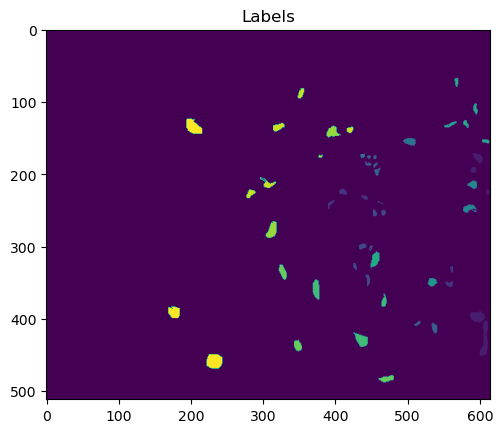

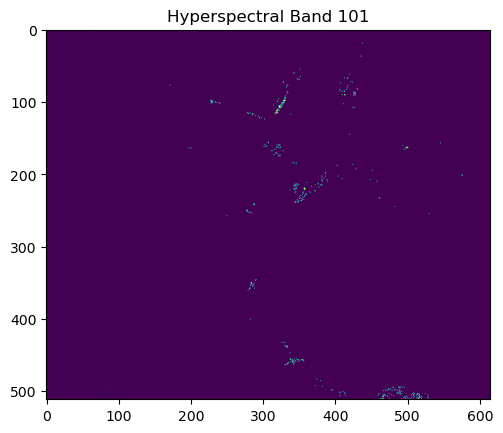

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(260, 5, 5, 176)
(65, 5, 5, 176)
(4886, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2510, PSNR: 6.0031


Epoch [1/50] Training Loss: 0.2401, PSNR: 6.1989
	[Val]   Batch [1/17] Loss: 0.2260, PSNR: 6.4596
	[Val]   Batch [10/17] Loss: 0.2264, PSNR: 6.4503
Epoch [1/50] Validation Loss: 0.2262, PSNR: 6.4542

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2195, PSNR: 6.5863


Epoch [2/50] Training Loss: 0.2039, PSNR: 6.9109
	[Val]   Batch [1/17] Loss: 0.1807, PSNR: 7.4295
	[Val]   Batch [10/17] Loss: 0.1835, PSNR: 7.3626
Epoch [2/50] Validation Loss: 0.1826, PSNR: 7.3855

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1809, PSNR: 7.4245


Epoch [3/50] Training Loss: 0.1679, PSNR: 7.7558
	[Val]   Batch [1/17] Loss: 0.1467, PSNR: 8.3356
	[Val]   Batch [10/17] Loss: 0.1497, PSNR: 8.2478
Epoch [3/50] Validation Loss: 0.1486, PSNR: 8.2808

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1480, PSNR: 8.2967


Epoch [4/50] Training Loss: 0.1358, PSNR: 7.9957
	[Val]   Batch [1/17] Loss: 0.1199, PSNR: 9.2107
	[Val]   Batch [10/17] Loss: 0.1209, PSNR: 9.1740
Epoch [4/50] Validation Loss: 0.1204, PSNR: 9.1943

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1186, PSNR: 9.2607


Epoch [5/50] Training Loss: 0.1085, PSNR: 9.6543
	[Val]   Batch [1/17] Loss: 0.0960, PSNR: 10.1785
	[Val]   Batch [10/17] Loss: 0.0973, PSNR: 10.1202
Epoch [5/50] Validation Loss: 0.0966, PSNR: 10.1516

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0945, PSNR: 10.2441


Epoch [6/50] Training Loss: 0.0867, PSNR: 9.9445
	[Val]   Batch [1/17] Loss: 0.0782, PSNR: 11.0693
	[Val]   Batch [10/17] Loss: 0.0785, PSNR: 11.0514
Epoch [6/50] Validation Loss: 0.0782, PSNR: 11.0704

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0763, PSNR: 11.1771


Epoch [7/50] Training Loss: 0.0699, PSNR: 11.5638
	[Val]   Batch [1/17] Loss: 0.0635, PSNR: 11.9730
	[Val]   Batch [10/17] Loss: 0.0637, PSNR: 11.9614
Epoch [7/50] Validation Loss: 0.0634, PSNR: 11.9765

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0616, PSNR: 12.1043


Epoch [8/50] Training Loss: 0.0571, PSNR: 11.7653
	[Val]   Batch [1/17] Loss: 0.0533, PSNR: 12.7296
	[Val]   Batch [10/17] Loss: 0.0535, PSNR: 12.7197
Epoch [8/50] Validation Loss: 0.0533, PSNR: 12.7326

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0509, PSNR: 12.9349


Epoch [9/50] Training Loss: 0.0475, PSNR: 13.2361
	[Val]   Batch [1/17] Loss: 0.0445, PSNR: 13.5147
	[Val]   Batch [10/17] Loss: 0.0446, PSNR: 13.5065
Epoch [9/50] Validation Loss: 0.0445, PSNR: 13.5178

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0424, PSNR: 13.7240


Epoch [10/50] Training Loss: 0.0402, PSNR: 13.9632
	[Val]   Batch [1/17] Loss: 0.0374, PSNR: 14.2734
	[Val]   Batch [10/17] Loss: 0.0374, PSNR: 14.2760
Epoch [10/50] Validation Loss: 0.0373, PSNR: 14.2838

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0361, PSNR: 14.4224


Epoch [11/50] Training Loss: 0.0344, PSNR: 14.6358
	[Val]   Batch [1/17] Loss: 0.0326, PSNR: 14.8652
	[Val]   Batch [10/17] Loss: 0.0328, PSNR: 14.8444
Epoch [11/50] Validation Loss: 0.0327, PSNR: 14.8606

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0317, PSNR: 14.9925


Epoch [12/50] Training Loss: 0.0298, PSNR: 14.5782
	[Val]   Batch [1/17] Loss: 0.0289, PSNR: 15.3984
	[Val]   Batch [10/17] Loss: 0.0288, PSNR: 15.4034
Epoch [12/50] Validation Loss: 0.0288, PSNR: 15.4096

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0277, PSNR: 15.5784


Epoch [13/50] Training Loss: 0.0262, PSNR: 15.1471
	[Val]   Batch [1/17] Loss: 0.0254, PSNR: 15.9458
	[Val]   Batch [10/17] Loss: 0.0257, PSNR: 15.9091
Epoch [13/50] Validation Loss: 0.0255, PSNR: 15.9286

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0243, PSNR: 16.1503


Epoch [14/50] Training Loss: 0.0231, PSNR: 16.3605
	[Val]   Batch [1/17] Loss: 0.0222, PSNR: 16.5446
	[Val]   Batch [10/17] Loss: 0.0222, PSNR: 16.5404
Epoch [14/50] Validation Loss: 0.0221, PSNR: 16.5483

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0216, PSNR: 16.6625


Epoch [15/50] Training Loss: 0.0207, PSNR: 16.8488
	[Val]   Batch [1/17] Loss: 0.0201, PSNR: 16.9757
	[Val]   Batch [10/17] Loss: 0.0202, PSNR: 16.9385
Epoch [15/50] Validation Loss: 0.0202, PSNR: 16.9541

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0194, PSNR: 17.1205


Epoch [16/50] Training Loss: 0.0186, PSNR: 17.3075
	[Val]   Batch [1/17] Loss: 0.0182, PSNR: 17.3909
	[Val]   Batch [10/17] Loss: 0.0182, PSNR: 17.3907
Epoch [16/50] Validation Loss: 0.0182, PSNR: 17.3955

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0176, PSNR: 17.5391


Epoch [17/50] Training Loss: 0.0168, PSNR: 17.7377
	[Val]   Batch [1/17] Loss: 0.0164, PSNR: 17.8431
	[Val]   Batch [10/17] Loss: 0.0166, PSNR: 17.8110
Epoch [17/50] Validation Loss: 0.0165, PSNR: 17.8219

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0159, PSNR: 17.9748


Epoch [18/50] Training Loss: 0.0153, PSNR: 18.1462
	[Val]   Batch [1/17] Loss: 0.0150, PSNR: 18.2423
	[Val]   Batch [10/17] Loss: 0.0150, PSNR: 18.2485
Epoch [18/50] Validation Loss: 0.0150, PSNR: 18.2498

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0144, PSNR: 18.4131


Epoch [19/50] Training Loss: 0.0140, PSNR: 18.5353
	[Val]   Batch [1/17] Loss: 0.0139, PSNR: 18.5683
	[Val]   Batch [10/17] Loss: 0.0140, PSNR: 18.5370
Epoch [19/50] Validation Loss: 0.0140, PSNR: 18.5496

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0134, PSNR: 18.7345


Epoch [20/50] Training Loss: 0.0129, PSNR: 18.9031
	[Val]   Batch [1/17] Loss: 0.0127, PSNR: 18.9650
	[Val]   Batch [10/17] Loss: 0.0127, PSNR: 18.9511
Epoch [20/50] Validation Loss: 0.0127, PSNR: 18.9588

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0123, PSNR: 19.1150


Epoch [21/50] Training Loss: 0.0119, PSNR: 19.2443
	[Val]   Batch [1/17] Loss: 0.0118, PSNR: 19.2783
	[Val]   Batch [10/17] Loss: 0.0119, PSNR: 19.2354
Epoch [21/50] Validation Loss: 0.0119, PSNR: 19.2532

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0115, PSNR: 19.3997


Epoch [22/50] Training Loss: 0.0110, PSNR: 19.5715
	[Val]   Batch [1/17] Loss: 0.0108, PSNR: 19.6738
	[Val]   Batch [10/17] Loss: 0.0108, PSNR: 19.6505
Epoch [22/50] Validation Loss: 0.0108, PSNR: 19.6607

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0107, PSNR: 19.6954


Epoch [23/50] Training Loss: 0.0102, PSNR: 19.8987
	[Val]   Batch [1/17] Loss: 0.0101, PSNR: 19.9365
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9130
Epoch [23/50] Validation Loss: 0.0102, PSNR: 19.9222

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1721


Epoch [24/50] Training Loss: 0.0095, PSNR: 20.2056
	[Val]   Batch [1/17] Loss: 0.0095, PSNR: 20.2123
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1680
Epoch [24/50] Validation Loss: 0.0096, PSNR: 20.1862

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0090, PSNR: 20.4811


Epoch [25/50] Training Loss: 0.0089, PSNR: 20.5017
	[Val]   Batch [1/17] Loss: 0.0089, PSNR: 20.5274
	[Val]   Batch [10/17] Loss: 0.0089, PSNR: 20.4852
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5006

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0085, PSNR: 20.7165


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.1133
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7785
	[Val]   Batch [10/17] Loss: 0.0085, PSNR: 20.7291
Epoch [26/50] Validation Loss: 0.0084, PSNR: 20.7463

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0084, PSNR: 20.7639


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0677
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0906
	[Val]   Batch [10/17] Loss: 0.0079, PSNR: 21.0381
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.0594

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0075, PSNR: 21.2722


Epoch [28/50] Training Loss: 0.0073, PSNR: 21.3411
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3303
	[Val]   Batch [10/17] Loss: 0.0074, PSNR: 21.2798
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3014

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3745


Epoch [29/50] Training Loss: 0.0069, PSNR: 21.5936
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.6210
	[Val]   Batch [10/17] Loss: 0.0070, PSNR: 21.5620
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.5856

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0066, PSNR: 21.7939


Epoch [30/50] Training Loss: 0.0065, PSNR: 21.8407
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8923
	[Val]   Batch [10/17] Loss: 0.0066, PSNR: 21.8185
Epoch [30/50] Validation Loss: 0.0065, PSNR: 21.8444

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0064, PSNR: 21.9080


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0867
	[Val]   Batch [1/17] Loss: 0.0062, PSNR: 22.1097
	[Val]   Batch [10/17] Loss: 0.0062, PSNR: 22.0441
Epoch [31/50] Validation Loss: 0.0062, PSNR: 22.0686

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0060, PSNR: 22.2183


Epoch [32/50] Training Loss: 0.0059, PSNR: 22.2954
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2505
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1619
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.1947

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4735


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.5427
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5369
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4493
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.4829

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7312


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7471
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7515
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6672
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6980

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0050, PSNR: 22.9994


Epoch [35/50] Training Loss: 0.0050, PSNR: 22.2894
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9188
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.8317
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8625

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8624


Epoch [36/50] Training Loss: 0.0048, PSNR: 22.4867
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0910
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 22.9969
Epoch [36/50] Validation Loss: 0.0050, PSNR: 23.0304

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0050, PSNR: 23.0291


Epoch [37/50] Training Loss: 0.0046, PSNR: 22.6934
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3519
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2503
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2857

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6189


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5687
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5957
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4894
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.5266

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.8133


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.7686
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7788
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6655
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.7046

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7161


Epoch [40/50] Training Loss: 0.0040, PSNR: 23.9495
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9817
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8611
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.9034

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0389


Epoch [41/50] Training Loss: 0.0039, PSNR: 23.4619
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1314
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 24.0122
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0532

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.2652


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.3159
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3178
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.1901
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.2352

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5105


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.4861
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5001
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3695
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4153

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7460


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.6504
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6974
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5648
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.6113

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8254


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.8002
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8172
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6604
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7178

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.3936


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.2992
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9559
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8119
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8619

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.8993


Epoch [47/50] Training Loss: 0.0031, PSNR: 25.1289
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1242
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9709
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.0244

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3619


Epoch [48/50] Training Loss: 0.0030, PSNR: 24.6139
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2214
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0596
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1151

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3899


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.4376
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4558
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2842
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3437

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4349


Epoch [50/50] Training Loss: 0.0028, PSNR: 24.9026
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5482
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3693
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4313


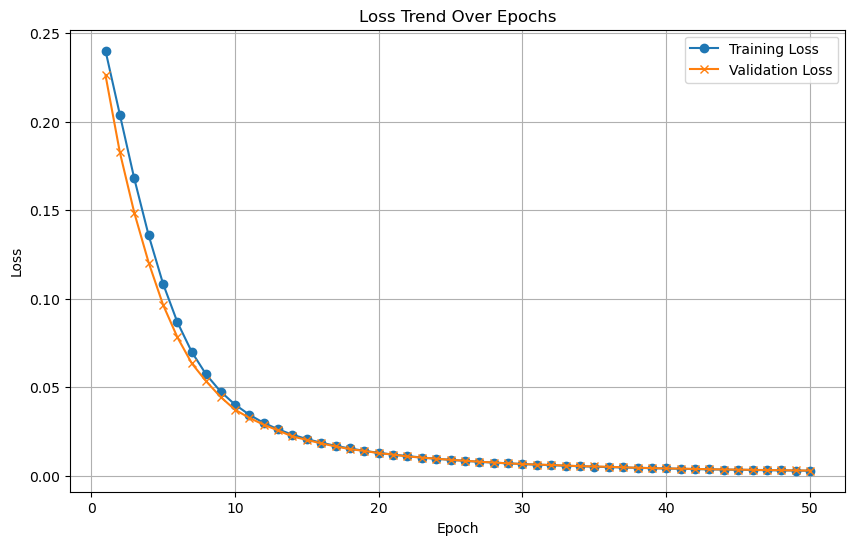

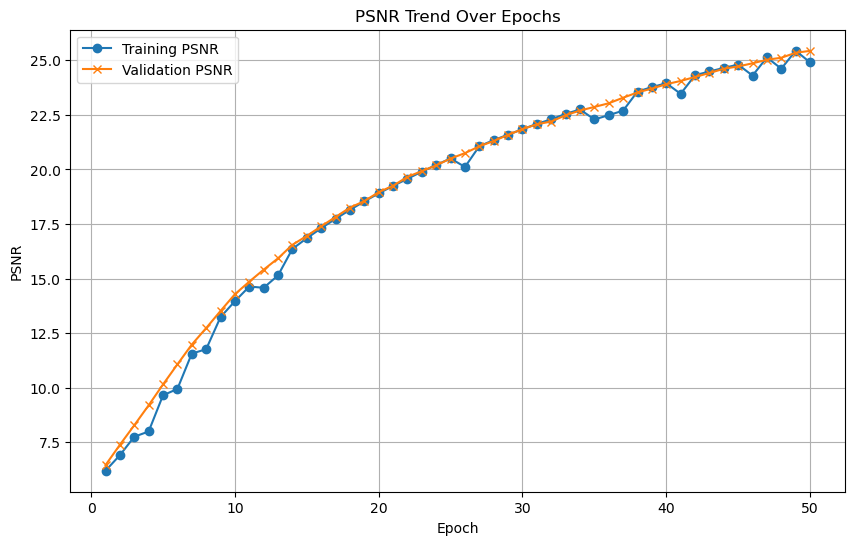

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5638
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5719. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5513
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5286
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5279
    Validation Batch [1/1], Loss: 2.5719
Validation Loss: 2.5719, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Tr

Epoch [15/1000] completed, Average Training Loss: 2.4084
    Validation Batch [1/1], Loss: 2.5717
Validation Loss: 2.5717, Validation Accuracy: 7.69%
Validation loss improved from 2.5718 to 2.5717. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 2.4059
    Validation Batch [1/1], Loss: 2.5716
Validation Loss: 2.5716, Validation Accuracy: 7.69%
Validation loss improved from 2.5717 to 2.5716. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3788
    Validation Batch [1/1], Loss: 2.5716
Validation Loss: 2.5716, Validation Accuracy: 7.69%
Validation loss improved from 2.5716 to 2.5716. Saving model...

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3711
    Validation Batch [1/1], Loss: 2.5714
Validation Loss: 2.5714, Validation Accuracy: 7.69%
Validation loss improved from 2.5716 to 2.5714. Saving model...

LOG: Epoch [19/1000] - Training
Epoch [19/10

Epoch [40/1000] completed, Average Training Loss: 2.1935
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1832
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.1626
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.1725
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.1612
    Validati

    Validation Batch [1/1], Loss: 2.5384
Validation Loss: 2.5384, Validation Accuracy: 7.69%
Validation loss improved from 2.5439 to 2.5384. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [66/1000] completed, Average Training Loss: 1.9863
    Validation Batch [1/1], Loss: 2.5323
Validation Loss: 2.5323, Validation Accuracy: 7.69%
Validation loss improved from 2.5384 to 2.5323. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 2.0030
    Validation Batch [1/1], Loss: 2.5259
Validation Loss: 2.5259, Validation Accuracy: 7.69%
Validation loss improved from 2.5323 to 2.5259. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.9772
    Validation Batch [1/1], Loss: 2.5191
Validation Loss: 2.5191, Validation Accuracy: 7.69%
Validation loss improved from 2.5259 to 2.5191. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.9599
    Validati

    Validation Batch [1/1], Loss: 2.1758
Validation Loss: 2.1758, Validation Accuracy: 35.38%
Validation loss improved from 2.1988 to 2.1758. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 1.7675
    Validation Batch [1/1], Loss: 2.1531
Validation Loss: 2.1531, Validation Accuracy: 35.38%
Validation loss improved from 2.1758 to 2.1531. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 1.7850
    Validation Batch [1/1], Loss: 2.1337
Validation Loss: 2.1337, Validation Accuracy: 40.00%
Validation loss improved from 2.1531 to 2.1337. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.7841
    Validation Batch [1/1], Loss: 2.1176
Validation Loss: 2.1176, Validation Accuracy: 41.54%
Validation loss improved from 2.1337 to 2.1176. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.7743
    Vali

Epoch [115/1000] completed, Average Training Loss: 1.5795
    Validation Batch [1/1], Loss: 1.8069
Validation Loss: 1.8069, Validation Accuracy: 60.00%
Validation loss improved from 1.8239 to 1.8069. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.5686
    Validation Batch [1/1], Loss: 1.7917
Validation Loss: 1.7917, Validation Accuracy: 60.00%
Validation loss improved from 1.8069 to 1.7917. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.5342
    Validation Batch [1/1], Loss: 1.7812
Validation Loss: 1.7812, Validation Accuracy: 60.00%
Validation loss improved from 1.7917 to 1.7812. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.5796
    Validation Batch [1/1], Loss: 1.7753
Validation Loss: 1.7753, Validation Accuracy: 60.00%
Validation loss improved from 1.7812 to 1.7753. Saving model...

LOG: Epoch [119/1000] - Training


Epoch [141/1000] completed, Average Training Loss: 1.3589
    Validation Batch [1/1], Loss: 1.5746
Validation Loss: 1.5746, Validation Accuracy: 76.92%
Validation loss improved from 1.5839 to 1.5746. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.3309
    Validation Batch [1/1], Loss: 1.5773
Validation Loss: 1.5773, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.3494
    Validation Batch [1/1], Loss: 1.5652
Validation Loss: 1.5652, Validation Accuracy: 76.92%
Validation loss improved from 1.5746 to 1.5652. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.3133
    Validation Batch [1/1], Loss: 1.5507
Validation Loss: 1.5507, Validation Accuracy: 72.31%
Validation loss improved from 1.5652 to 1.5507. Saving model...

LOG: Epoch [145/1000] - Training
Epoch [145/1000

    Validation Batch [1/1], Loss: 1.3702
Validation Loss: 1.3702, Validation Accuracy: 78.46%
Validation loss improved from 1.3796 to 1.3702. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.0772
    Validation Batch [1/1], Loss: 1.3649
Validation Loss: 1.3649, Validation Accuracy: 78.46%
Validation loss improved from 1.3702 to 1.3649. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.1168
    Validation Batch [1/1], Loss: 1.3536
Validation Loss: 1.3536, Validation Accuracy: 78.46%
Validation loss improved from 1.3649 to 1.3536. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.0766
    Validation Batch [1/1], Loss: 1.3456
Validation Loss: 1.3456, Validation Accuracy: 76.92%
Validation loss improved from 1.3536 to 1.3456. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.0846


    Validation Batch [1/1], Loss: 1.2075
Validation Loss: 1.2075, Validation Accuracy: 76.92%
Validation loss improved from 1.2117 to 1.2075. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.8759
    Validation Batch [1/1], Loss: 1.2098
Validation Loss: 1.2098, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.8785
    Validation Batch [1/1], Loss: 1.2066
Validation Loss: 1.2066, Validation Accuracy: 75.38%
Validation loss improved from 1.2075 to 1.2066. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.8412
    Validation Batch [1/1], Loss: 1.2057
Validation Loss: 1.2057, Validation Accuracy: 73.85%
Validation loss improved from 1.2066 to 1.2057. Saving model...

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Average Training Loss: 0.8743
    Validation 

Epoch [217/1000] completed, Average Training Loss: 0.6809
    Validation Batch [1/1], Loss: 1.0333
Validation Loss: 1.0333, Validation Accuracy: 78.46%
Validation loss improved from 1.0557 to 1.0333. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.6581
    Validation Batch [1/1], Loss: 1.0289
Validation Loss: 1.0289, Validation Accuracy: 80.00%
Validation loss improved from 1.0333 to 1.0289. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.6621
    Validation Batch [1/1], Loss: 1.0326
Validation Loss: 1.0326, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.6698
    Validation Batch [1/1], Loss: 1.0449
Validation Loss: 1.0449, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Av

    Validation Batch [1/1], Loss: 0.9061
Validation Loss: 0.9061, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.5157
    Validation Batch [1/1], Loss: 0.8971
Validation Loss: 0.8971, Validation Accuracy: 80.00%
Validation loss improved from 0.9054 to 0.8971. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.5193
    Validation Batch [1/1], Loss: 0.8895
Validation Loss: 0.8895, Validation Accuracy: 80.00%
Validation loss improved from 0.8971 to 0.8895. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.5234
    Validation Batch [1/1], Loss: 0.8856
Validation Loss: 0.8856, Validation Accuracy: 80.00%
Validation loss improved from 0.8895 to 0.8856. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.4936
    Validation 

Epoch [268/1000] completed, Average Training Loss: 0.3723
    Validation Batch [1/1], Loss: 0.7928
Validation Loss: 0.7928, Validation Accuracy: 81.54%
Validation loss improved from 0.7964 to 0.7928. Saving model...

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.3889
    Validation Batch [1/1], Loss: 0.7744
Validation Loss: 0.7744, Validation Accuracy: 81.54%
Validation loss improved from 0.7928 to 0.7744. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4091
    Validation Batch [1/1], Loss: 0.7698
Validation Loss: 0.7698, Validation Accuracy: 81.54%
Validation loss improved from 0.7744 to 0.7698. Saving model...

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.3665
    Validation Batch [1/1], Loss: 0.7771
Validation Loss: 0.7771, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000

Epoch [294/1000] completed, Average Training Loss: 0.2891
    Validation Batch [1/1], Loss: 0.7411
Validation Loss: 0.7411, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.2814
    Validation Batch [1/1], Loss: 0.7544
Validation Loss: 0.7544, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.2762
    Validation Batch [1/1], Loss: 0.7691
Validation Loss: 0.7691, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.2879
    Validation Batch [1/1], Loss: 0.7447
Validation Loss: 0.7447, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.2912
  

Epoch [320/1000] completed, Average Training Loss: 0.2165
    Validation Batch [1/1], Loss: 0.6978
Validation Loss: 0.6978, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2300
    Validation Batch [1/1], Loss: 0.6931
Validation Loss: 0.6931, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2243
    Validation Batch [1/1], Loss: 0.6885
Validation Loss: 0.6885, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.2315
    Validation Batch [1/1], Loss: 0.6875
Validation Loss: 0.6875, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [324/1000] - Training
Epoch [324/1000] completed, Average Training Loss: 0.2152


Epoch [347/1000] completed, Average Training Loss: 0.1728
    Validation Batch [1/1], Loss: 0.7432
Validation Loss: 0.7432, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.1739
    Validation Batch [1/1], Loss: 0.7058
Validation Loss: 0.7058, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.1660
    Validation Batch [1/1], Loss: 0.6703
Validation Loss: 0.6703, Validation Accuracy: 83.08%
Validation loss improved from 0.6838 to 0.6703. Saving model...

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.1854
    Validation Batch [1/1], Loss: 0.6755
Validation Loss: 0.6755, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Trainin

    Validation Batch [1/1], Loss: 0.6718
Validation Loss: 0.6718, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1407
    Validation Batch [1/1], Loss: 0.6531
Validation Loss: 0.6531, Validation Accuracy: 81.54%
Validation loss improved from 0.6618 to 0.6531. Saving model...

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.1384
    Validation Batch [1/1], Loss: 0.6393
Validation Loss: 0.6393, Validation Accuracy: 83.08%
Validation loss improved from 0.6531 to 0.6393. Saving model...

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.1394
    Validation Batch [1/1], Loss: 0.6675
Validation Loss: 0.6675, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.1276
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.6826
Validation Loss: 0.6826, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.0968
    Validation Batch [1/1], Loss: 0.6679
Validation Loss: 0.6679, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.1146
    Validation Batch [1/1], Loss: 0.6603
Validation Loss: 0.6603, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.1162
    Validation Batch [1/1], Loss: 0.6604
Validation Loss: 0.6604, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training Loss: 0.1042
    Validation Batch [1/1], Loss: 0.6625
Validation Loss

Epoch [417/1000] completed, Average Training Loss: 0.0989
    Validation Batch [1/1], Loss: 0.6863
Validation Loss: 0.6863, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.1018
    Validation Batch [1/1], Loss: 0.6671
Validation Loss: 0.6671, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [419/1000] - Training
Epoch [419/1000] completed, Average Training Loss: 0.1112
    Validation Batch [1/1], Loss: 0.6251
Validation Loss: 0.6251, Validation Accuracy: 83.08%
Validation loss improved from 0.6313 to 0.6251. Saving model...

LOG: Epoch [420/1000] - Training
Epoch [420/1000] completed, Average Training Loss: 0.1095
    Validation Batch [1/1], Loss: 0.6200
Validation Loss: 0.6200, Validation Accuracy: 83.08%
Validation loss improved from 0.6251 to 0.6200. Saving model...

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Av

Epoch [444/1000] completed, Average Training Loss: 0.0847
    Validation Batch [1/1], Loss: 0.6274
Validation Loss: 0.6274, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [445/1000] - Training
Epoch [445/1000] completed, Average Training Loss: 0.0925
    Validation Batch [1/1], Loss: 0.6227
Validation Loss: 0.6227, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [446/1000] - Training
Epoch [446/1000] completed, Average Training Loss: 0.0908
    Validation Batch [1/1], Loss: 0.6190
Validation Loss: 0.6190, Validation Accuracy: 84.62%
Validation loss improved from 0.6200 to 0.6190. Saving model...

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.6253
Validation Loss: 0.6253, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Trainin

Epoch [471/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.6804
Validation Loss: 0.6804, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.6597
Validation Loss: 0.6597, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.0725
    Validation Batch [1/1], Loss: 0.6409
Validation Loss: 0.6409, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0726
    Validation Batch [1/1], Loss: 0.6358
Validation Loss: 0.6358, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.072

Epoch [496/1000] completed, Average Training Loss: 0.0640
    Validation Batch [1/1], Loss: 0.8124
Validation Loss: 0.8124, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0767
    Validation Batch [1/1], Loss: 0.7505
Validation Loss: 0.7505, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0667
    Validation Batch [1/1], Loss: 0.7023
Validation Loss: 0.7023, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0731
    Validation Batch [1/1], Loss: 0.6743
Validation Loss: 0.6743, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.075

Epoch [522/1000] completed, Average Training Loss: 0.0506
    Validation Batch [1/1], Loss: 0.6096
Validation Loss: 0.6096, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.0574
    Validation Batch [1/1], Loss: 0.6198
Validation Loss: 0.6198, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0566
    Validation Batch [1/1], Loss: 0.6444
Validation Loss: 0.6444, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.6575
Validation Loss: 0.6575, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.059

Epoch [548/1000] completed, Average Training Loss: 0.0549
    Validation Batch [1/1], Loss: 0.6979
Validation Loss: 0.6979, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [549/1000] - Training
Epoch [549/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.7071
Validation Loss: 0.7071, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [550/1000] - Training
Epoch [550/1000] completed, Average Training Loss: 0.0472
    Validation Batch [1/1], Loss: 0.7267
Validation Loss: 0.7267, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [551/1000] - Training
Epoch [551/1000] completed, Average Training Loss: 0.0478
    Validation Batch [1/1], Loss: 0.7237
Validation Loss: 0.7237, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [552/1000] - Training
Epoch [552/1000] completed, Average Training Loss: 0.047

Epoch [573/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.7119
Validation Loss: 0.7119, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.7373
Validation Loss: 0.7373, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.7317
Validation Loss: 0.7317, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0505
    Validation Batch [1/1], Loss: 0.6963
Validation Loss: 0.6963, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.046

Epoch [599/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.7253
Validation Loss: 0.7253, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [600/1000] - Training
Epoch [600/1000] completed, Average Training Loss: 0.0396
    Validation Batch [1/1], Loss: 0.7291
Validation Loss: 0.7291, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [601/1000] - Training
Epoch [601/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.7351
Validation Loss: 0.7351, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [602/1000] - Training
Epoch [602/1000] completed, Average Training Loss: 0.0420
    Validation Batch [1/1], Loss: 0.7252
Validation Loss: 0.7252, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [603/1000] - Training
Epoch [603/1000] completed, Average Training Loss: 0.042

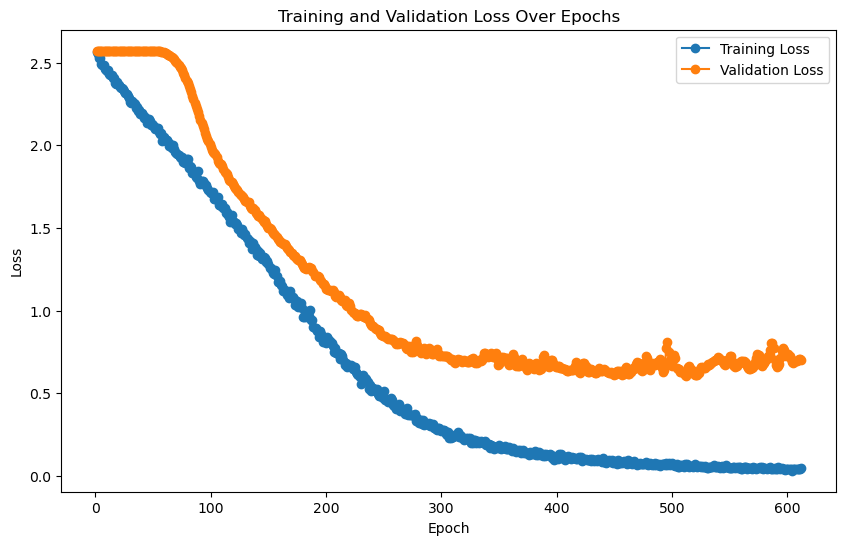

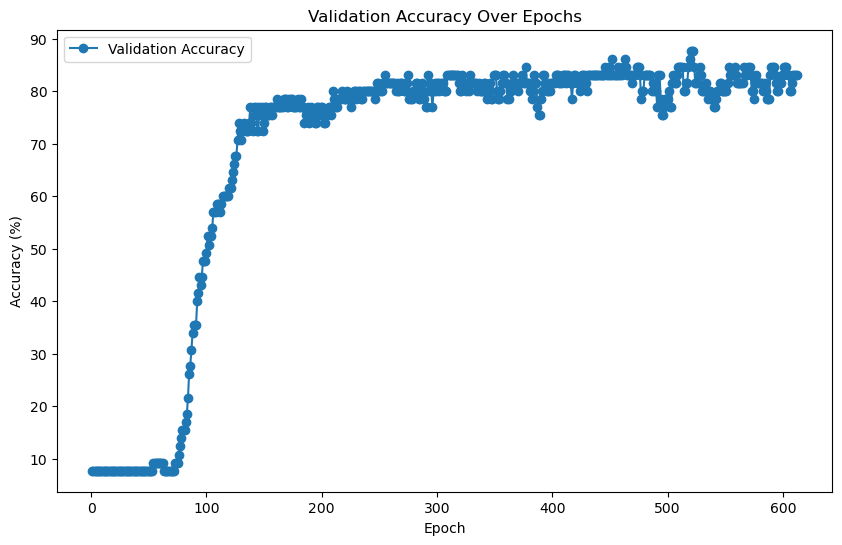


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.5807

Final Test Loss: 0.8572, Test Accuracy: 82.01%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)

LOG: Training features shape: (260, 64), Training labels shape: (260,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4886, 64), Test labels shape: (4886,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)
Train reps shape: (260, 64)
Train labels shape: (260,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4886, 64)
Test labels shape: (4886,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6367  |  Val Loss: 2.5596
Validation loss improved from inf to 2.5596.
[Epoch 2/1000] Train Loss: 2.5494  |  Val Loss: 2.5386
Validation loss improved from 2.5596 to 2.5386.
[Epoch 3/1000] Train Loss: 2.5257  |  Val Loss: 2.5184
Validation loss improved from 2.5386 to 2.5184.
[Epoch 4/1000] Train Loss: 2.5064  |  Val Loss: 2.5144
Validation loss improved from 2.5184 to 2.5144.
[Epoch 5/1000] Train Loss: 2.4957  |  Val Loss: 2.5107
Validation loss improved from 2.5144 to 2.5107.
[Epoch 6/1000] Train Loss: 2.4835  |  Val Loss: 2.4931
Validation loss improved from 2.5107 to 2.4931.
[Epoch 7/1000] Train Loss: 2.4668  |  Val Loss: 2.4841
Validation loss improved from 2.4931 to 2.4841.
[Epoch 8/1000] Train Loss: 2.4612  |  Val Loss: 2.4819
Validation loss improved from 2.4841 to 2.4819.
[Epoch 9/1000] Train Loss: 2.4507  |  Val Loss: 2.4640
Validation loss improved from 2.4819 to 2.4640.
[Epoch 10/1000] Train Loss: 2.4422  |  Val Loss: 2.4657
!! Validation loss d

[Epoch 14/1000] Train Loss: 2.4145  |  Val Loss: 2.4444
Validation loss improved from 2.4483 to 2.4444.
[Epoch 15/1000] Train Loss: 2.4123  |  Val Loss: 2.4411
Validation loss improved from 2.4444 to 2.4411.
[Epoch 16/1000] Train Loss: 2.4091  |  Val Loss: 2.4401
Validation loss improved from 2.4411 to 2.4401.
[Epoch 17/1000] Train Loss: 2.4050  |  Val Loss: 2.4359
Validation loss improved from 2.4401 to 2.4359.
[Epoch 18/1000] Train Loss: 2.3943  |  Val Loss: 2.4297
Validation loss improved from 2.4359 to 2.4297.
[Epoch 19/1000] Train Loss: 2.3855  |  Val Loss: 2.4226
Validation loss improved from 2.4297 to 2.4226.
[Epoch 20/1000] Train Loss: 2.3726  |  Val Loss: 2.4117
Validation loss improved from 2.4226 to 2.4117.


[Epoch 21/1000] Train Loss: 2.3636  |  Val Loss: 2.4050
Validation loss improved from 2.4117 to 2.4050.
[Epoch 22/1000] Train Loss: 2.3654  |  Val Loss: 2.4085
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 2.3712  |  Val Loss: 2.4061
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 24/1000] Train Loss: 2.3588  |  Val Loss: 2.3977
Validation loss improved from 2.4050 to 2.3977.
[Epoch 25/1000] Train Loss: 2.3537  |  Val Loss: 2.4103
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 26/1000] Train Loss: 2.3736  |  Val Loss: 2.4139
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 27/1000] Train Loss: 2.3553  |  Val Loss: 2.4007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 28/1000] Train Loss: 2.3574  |  Val Loss: 2.4180
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 29/1000] Train Loss: 2.3610  |  Val Loss: 2.4002
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 30/1000] Train 

[Epoch 32/1000] Train Loss: 2.3261  |  Val Loss: 2.3959
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 2.3348  |  Val Loss: 2.3856
Validation loss improved from 2.3902 to 2.3856.
[Epoch 34/1000] Train Loss: 2.3053  |  Val Loss: 2.3725
Validation loss improved from 2.3856 to 2.3725.
[Epoch 35/1000] Train Loss: 2.3011  |  Val Loss: 2.3701
Validation loss improved from 2.3725 to 2.3701.
[Epoch 36/1000] Train Loss: 2.2941  |  Val Loss: 2.3655
Validation loss improved from 2.3701 to 2.3655.
[Epoch 37/1000] Train Loss: 2.2932  |  Val Loss: 2.3600
Validation loss improved from 2.3655 to 2.3600.
[Epoch 38/1000] Train Loss: 2.2918  |  Val Loss: 2.3629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.2874  |  Val Loss: 2.3607
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 40/1000] Train Loss: 2.2831  |  Val Loss: 2.3614
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 41/1000] Train Loss: 2.2889  |  V

[Epoch 42/1000] Train Loss: 2.2700  |  Val Loss: 2.3343
Validation loss improved from 2.3600 to 2.3343.
[Epoch 43/1000] Train Loss: 2.2575  |  Val Loss: 2.3346
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 2.2618  |  Val Loss: 2.3351
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 45/1000] Train Loss: 2.2487  |  Val Loss: 2.3226
Validation loss improved from 2.3343 to 2.3226.
[Epoch 46/1000] Train Loss: 2.2483  |  Val Loss: 2.3332
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 2.2336  |  Val Loss: 2.3190
Validation loss improved from 2.3226 to 2.3190.
[Epoch 48/1000] Train Loss: 2.2259  |  Val Loss: 2.3314
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 2.2286  |  Val Loss: 2.3063
Validation loss improved from 2.3190 to 2.3063.
[Epoch 50/1000] Train Loss: 2.1964  |  Val Loss: 2.2899
Validation loss improved from 2.3063 to 2.2899.
[Epoch 51/1000] Train Loss: 2.1924  |  V

[Epoch 52/1000] Train Loss: 2.1778  |  Val Loss: 2.2923
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 53/1000] Train Loss: 2.1765  |  Val Loss: 2.2763
Validation loss improved from 2.2899 to 2.2763.
[Epoch 54/1000] Train Loss: 2.1684  |  Val Loss: 2.2733
Validation loss improved from 2.2763 to 2.2733.
[Epoch 55/1000] Train Loss: 2.1920  |  Val Loss: 2.2794
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 56/1000] Train Loss: 2.1663  |  Val Loss: 2.2654
Validation loss improved from 2.2733 to 2.2654.
[Epoch 57/1000] Train Loss: 2.1187  |  Val Loss: 2.2455
Validation loss improved from 2.2654 to 2.2455.
[Epoch 58/1000] Train Loss: 2.1239  |  Val Loss: 2.2527
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 2.1185  |  Val Loss: 2.2393
Validation loss improved from 2.2455 to 2.2393.
[Epoch 60/1000] Train Loss: 2.1053  |  Val Loss: 2.2289
Validation loss improved from 2.2393 to 2.2289.
[Epoch 61/1000] Train Loss: 2.0829  |  Val Los

[Epoch 63/1000] Train Loss: 2.0632  |  Val Loss: 2.1897
Validation loss improved from 2.1974 to 2.1897.
[Epoch 64/1000] Train Loss: 2.0427  |  Val Loss: 2.1886
Validation loss improved from 2.1897 to 2.1886.
[Epoch 65/1000] Train Loss: 2.0349  |  Val Loss: 2.1656
Validation loss improved from 2.1886 to 2.1656.
[Epoch 66/1000] Train Loss: 2.0226  |  Val Loss: 2.1795
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 67/1000] Train Loss: 2.0262  |  Val Loss: 2.1307
Validation loss improved from 2.1656 to 2.1307.
[Epoch 68/1000] Train Loss: 2.0257  |  Val Loss: 2.1452
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 2.0061  |  Val Loss: 2.1484
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 2.0479  |  Val Loss: 2.1065
Validation loss improved from 2.1307 to 2.1065.
[Epoch 71/1000] Train Loss: 1.9629  |  Val Loss: 2.0875
Validation loss improved from 2.1065 to 2.0875.


[Epoch 72/1000] Train Loss: 1.9425  |  Val Loss: 2.0887
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.9581  |  Val Loss: 2.1003
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.9557  |  Val Loss: 2.1256
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 1.9788  |  Val Loss: 2.1207
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 76/1000] Train Loss: 1.9294  |  Val Loss: 2.0755
Validation loss improved from 2.0875 to 2.0755.
[Epoch 77/1000] Train Loss: 1.8933  |  Val Loss: 2.0495
Validation loss improved from 2.0755 to 2.0495.
[Epoch 78/1000] Train Loss: 1.8940  |  Val Loss: 2.0384
Validation loss improved from 2.0495 to 2.0384.
[Epoch 79/1000] Train Loss: 1.8635  |  Val Loss: 2.0691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 80/1000] Train Loss: 1.8844  |  Val Loss: 2.0422
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 81/1000] Train Loss: 

[Epoch 82/1000] Train Loss: 1.8403  |  Val Loss: 2.0193
Validation loss improved from 2.0309 to 2.0193.
[Epoch 83/1000] Train Loss: 1.8520  |  Val Loss: 2.0660
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 84/1000] Train Loss: 1.8707  |  Val Loss: 2.0197
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 85/1000] Train Loss: 1.8418  |  Val Loss: 2.1020
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 86/1000] Train Loss: 1.9069  |  Val Loss: 2.1475
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 87/1000] Train Loss: 1.9057  |  Val Loss: 2.1064
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 88/1000] Train Loss: 1.8959  |  Val Loss: 2.1032
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 89/1000] Train Loss: 1.8562  |  Val Loss: 2.0598
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 90/1000] Train Loss: 1.9193  |  Val Loss: 2.0936
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 91/1000] Train Loss: 1.8701  |  Val Loss: 2.0502
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 92/1000] Train Loss: 2.0184  |  Val Loss: 2.0554
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 93/1000] Train Loss: 1.9696  |  Val Loss: 2.0214
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 94/1000] Train Loss: 1.8748  |  Val Loss: 1.9978
Validation loss improved from 2.0193 to 1.9978.
[Epoch 95/1000] Train Loss: 1.7935  |  Val Loss: 2.0095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 1.7734  |  Val Loss: 1.9795
Validation loss improved from 1.9978 to 1.9795.
[Epoch 97/1000] Train Loss: 1.7591  |  Val Loss: 2.0278
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.7565  |  Val Loss: 1.9566
Validation loss improved from 1.9795 to 1.9566.
[Epoch 99/1000] Train Loss

[Epoch 102/1000] Train Loss: 1.7226  |  Val Loss: 1.9503
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.7081  |  Val Loss: 1.9859
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 1.7084  |  Val Loss: 1.9339
Validation loss improved from 1.9373 to 1.9339.
[Epoch 105/1000] Train Loss: 1.7031  |  Val Loss: 1.9548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 106/1000] Train Loss: 1.6996  |  Val Loss: 1.9268
Validation loss improved from 1.9339 to 1.9268.
[Epoch 107/1000] Train Loss: 1.6846  |  Val Loss: 1.9420
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 108/1000] Train Loss: 1.6850  |  Val Loss: 1.9512
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 109/1000] Train Loss: 1.7018  |  Val Loss: 1.9432
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 110/1000] Train Loss: 1.6843  |  Val Loss: 1.9682
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 111/1000] Train Loss: 1.7197  |  Val Loss: 1.9605
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 112/1000] Train Loss: 1.7257  |  Val Loss: 1.9524
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 113/1000] Train Loss: 1.6650  |  Val Loss: 1.9848
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 114/1000] Train Loss: 1.6722  |  Val Loss: 1.9500
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 115/1000] Train Loss: 1.6634  |  Val Loss: 1.9476
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 116/1000] Train Loss: 1.6855  |  Val Loss: 2.0762
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 122/1000] Train Loss: 1.6343  |  Val Loss: 1.9231
Validation loss improved from 1.9268 to 1.9231.
[Epoch 123/1000] Train Loss: 1.6495  |  Val Loss: 1.9265
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 124/1000] Train Loss: 1.6152  |  Val Loss: 1.9149
Validation loss improved from 1.9231 to 1.9149.
[Epoch 125/1000] Train Loss: 1.6395  |  Val Loss: 1.9296
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 1.6156  |  Val Loss: 1.9509
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 1.6177  |  Val Loss: 1.9235
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 1.5939  |  Val Loss: 1.9039
Validation loss improved from 1.9149 to 1.9039.
[Epoch 129/1000] Train Loss: 1.6338  |  Val Loss: 1.9772
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 1.6108  |  Val Loss: 1.9360
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 131/1000] Tr

[Epoch 132/1000] Train Loss: 1.6355  |  Val Loss: 1.9116
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 133/1000] Train Loss: 1.6040  |  Val Loss: 1.9320
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 134/1000] Train Loss: 1.5842  |  Val Loss: 1.9202
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 135/1000] Train Loss: 1.6041  |  Val Loss: 2.0783
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 136/1000] Train Loss: 1.6721  |  Val Loss: 1.9557
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 137/1000] Train Loss: 1.6380  |  Val Loss: 1.9592
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 138/1000] Train Loss: 1.5716  |  Val Loss: 1.9682
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 139/1000] Train Loss: 1.6618  |  Val Loss: 2.2460
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 140/1000] Train Loss: 1.7518  |  Val Loss: 2.0530
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 145/1000] Train Loss: 1.5656  |  Val Loss: 1.9025
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 146/1000] Train Loss: 1.5615  |  Val Loss: 1.9512
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 147/1000] Train Loss: 1.5953  |  Val Loss: 1.9215
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 148/1000] Train Loss: 1.5687  |  Val Loss: 1.9171
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 149/1000] Train Loss: 1.5601  |  Val Loss: 1.8975
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 150/1000] Train Loss: 1.5757  |  Val Loss: 2.1016
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 151/1000] Train Loss: 1.6608  |  Val Loss: 1.9013
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 152/1000] Train Loss: 1.5406  |  Val Loss: 1.8974
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 153/1000] Train Loss: 1.5392  |  Val Loss: 1.8874
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 154/1000] Train Loss: 1.5318  |  Val Loss: 1.8922
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 155/1000] Train Loss: 1.5386  |  Val Loss: 1.8788
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 156/1000] Train Loss: 1.5347  |  Val Loss: 1.9444
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 157/1000] Train Loss: 1.5905  |  Val Loss: 1.8666
Validation loss improved from 1.8711 to 1.8666.
[Epoch 158/1000] Train Loss: 1.5172  |  Val Loss: 1.9961
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 159/1000] Train Loss: 1.5912  |  Val Loss: 1.9069
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 160/1000] Train Loss: 1.5174  |  Val Loss: 1.8945
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 161/1000] Train Loss: 1.5245  |  Val Loss: 1.8609
Validation loss improved from 1.8666 to 1.8609.
[Epoch 162/1000] Train Loss: 1.5339  |  Val Loss: 1.8768
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163

[Epoch 166/1000] Train Loss: 1.5256  |  Val Loss: 1.8548
Validation loss improved from 1.8609 to 1.8548.
[Epoch 167/1000] Train Loss: 1.5066  |  Val Loss: 1.8878
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 168/1000] Train Loss: 1.5181  |  Val Loss: 1.8361
Validation loss improved from 1.8548 to 1.8361.
[Epoch 169/1000] Train Loss: 1.5056  |  Val Loss: 1.8344
Validation loss improved from 1.8361 to 1.8344.
[Epoch 170/1000] Train Loss: 1.5269  |  Val Loss: 1.9271
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 171/1000] Train Loss: 1.5552  |  Val Loss: 1.8450
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 172/1000] Train Loss: 1.4939  |  Val Loss: 1.9206
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 173/1000] Train Loss: 1.5016  |  Val Loss: 1.8774
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 174/1000] Train Loss: 1.5145  |  Val Loss: 1.8628
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 175/1000] Train Loss: 1.5025  |  Val Loss: 1.8967
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 176/1000] Train Loss: 1.5145  |  Val Loss: 1.8717
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 177/1000] Train Loss: 1.4845  |  Val Loss: 1.8510
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 178/1000] Train Loss: 1.5057  |  Val Loss: 1.8569
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 179/1000] Train Loss: 1.4908  |  Val Loss: 1.8821
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 180/1000] Train Loss: 1.5062  |  Val Loss: 1.9269
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 181/1000] Train Loss: 1.4976  |  Val Loss: 1.8456
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 185/1000] Train Loss: 1.5842  |  Val Loss: 1.8842
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 186/1000] Train Loss: 1.5676  |  Val Loss: 2.0080
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 187/1000] Train Loss: 1.5105  |  Val Loss: 1.9492
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 188/1000] Train Loss: 1.6306  |  Val Loss: 1.9726
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 189/1000] Train Loss: 1.5043  |  Val Loss: 1.8381
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 190/1000] Train Loss: 1.4566  |  Val Loss: 1.9407
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 191/1000] Train Loss: 1.4585  |  Val Loss: 1.8588
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 192/1000] Train Loss: 1.5095  |  Val Loss: 1.8594
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 193/1000] Train Loss: 1.4639  |  Val Loss: 1.9189
!! Validation loss did NOT improve !! Patience:

[Epoch 194/1000] Train Loss: 1.5029  |  Val Loss: 1.9011
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 195/1000] Train Loss: 1.4742  |  Val Loss: 1.9088
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 196/1000] Train Loss: 1.6168  |  Val Loss: 1.9478
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 197/1000] Train Loss: 1.4937  |  Val Loss: 1.8484
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 198/1000] Train Loss: 1.4490  |  Val Loss: 1.9522
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 199/1000] Train Loss: 1.4876  |  Val Loss: 1.8548
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 200/1000] Train Loss: 1.5272  |  Val Loss: 2.0718
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 201/1000] Train Loss: 1.6430  |  Val Loss: 1.9164
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 202/1000] Train Loss: 1.5779  |  Val Loss: 1.8829
!! Validation loss did NOT improve !! Patience:

[Epoch 206/1000] Train Loss: 1.4904  |  Val Loss: 1.8552
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 1.4834  |  Val Loss: 1.8181
Validation loss improved from 1.8224 to 1.8181.
[Epoch 208/1000] Train Loss: 1.4786  |  Val Loss: 1.8599
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 1.4879  |  Val Loss: 1.8322
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 1.4784  |  Val Loss: 1.8716
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 1.4797  |  Val Loss: 1.8335
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 212/1000] Train Loss: 1.4998  |  Val Loss: 1.8159
Validation loss improved from 1.8181 to 1.8159.
[Epoch 213/1000] Train Loss: 1.4722  |  Val Loss: 1.8582
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 1.4743  |  Val Loss: 2.0234
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 215/10

[Epoch 217/1000] Train Loss: 1.7726  |  Val Loss: 1.8364
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 218/1000] Train Loss: 1.7059  |  Val Loss: 1.9508
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 219/1000] Train Loss: 1.5827  |  Val Loss: 1.9904
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 220/1000] Train Loss: 1.5156  |  Val Loss: 2.0216
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 221/1000] Train Loss: 1.6057  |  Val Loss: 1.9555
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 222/1000] Train Loss: 1.4553  |  Val Loss: 1.8334
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 223/1000] Train Loss: 1.5131  |  Val Loss: 1.8692
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 224/1000] Train Loss: 1.4718  |  Val Loss: 1.8207
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 225/1000] Train Loss: 1.4460  |  Val Loss: 1.8394
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 229/1000] Train Loss: 1.4582  |  Val Loss: 1.8373
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 230/1000] Train Loss: 1.4167  |  Val Loss: 1.8040
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 231/1000] Train Loss: 1.4161  |  Val Loss: 1.8931
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 232/1000] Train Loss: 1.4129  |  Val Loss: 1.7772
Validation loss improved from 1.7935 to 1.7772.
[Epoch 233/1000] Train Loss: 1.4309  |  Val Loss: 1.8384
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 234/1000] Train Loss: 1.4314  |  Val Loss: 1.7905
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 235/1000] Train Loss: 1.3983  |  Val Loss: 1.8245
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 236/1000] Train Loss: 1.4061  |  Val Loss: 1.8444
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 237/1000] Train Loss: 1.4020  |  Val Loss: 1.8342
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 238/1000] Train Loss: 1.3994  |  Val Loss: 1.8301
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 239/1000] Train Loss: 1.4004  |  Val Loss: 1.7980
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 240/1000] Train Loss: 1.3986  |  Val Loss: 1.8801
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 241/1000] Train Loss: 1.4879  |  Val Loss: 1.8209
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 242/1000] Train Loss: 1.5462  |  Val Loss: 1.7878
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 243/1000] Train Loss: 1.4665  |  Val Loss: 1.8568
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 244/1000] Train Loss: 1.4730  |  Val Loss: 1.8230
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 245/1000] Train Loss: 1.4248  |  Val Loss: 1.9007
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 246/1000] Train Loss: 1.4097  |  Val Loss: 1.8153
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 252/1000] Train Loss: 1.4612  |  Val Loss: 1.8151
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 253/1000] Train Loss: 1.3843  |  Val Loss: 1.7809
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 254/1000] Train Loss: 1.4245  |  Val Loss: 1.7925
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 255/1000] Train Loss: 1.4092  |  Val Loss: 1.7815
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 256/1000] Train Loss: 1.4055  |  Val Loss: 1.7786
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 257/1000] Train Loss: 1.3726  |  Val Loss: 1.8063
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 258/1000] Train Loss: 1.3782  |  Val Loss: 1.8243
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 259/1000] Train Loss: 1.4059  |  Val Loss: 1.8531
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 260/1000] Train Loss: 1.3923  |  Val Loss: 1.8225
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 261/1000] Train Loss: 1.3670  |  Val Loss: 1.7888
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 262/1000] Train Loss: 1.3776  |  Val Loss: 1.8043
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 263/1000] Train Loss: 1.3784  |  Val Loss: 1.8196
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 264/1000] Train Loss: 1.3658  |  Val Loss: 1.8120
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 265/1000] Train Loss: 1.3644  |  Val Loss: 1.8350
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 266/1000] Train Loss: 1.3633  |  Val Loss: 1.8074
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 267/1000] Train Loss: 1.3901  |  Val Loss: 1.7870
!! Validation loss did NOT improve !! Patience:

[Epoch 273/1000] Train Loss: 1.3666  |  Val Loss: 1.8353
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 274/1000] Train Loss: 1.3653  |  Val Loss: 1.8237
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 275/1000] Train Loss: 1.3811  |  Val Loss: 1.8540
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 276/1000] Train Loss: 1.3803  |  Val Loss: 1.8075
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 277/1000] Train Loss: 1.3518  |  Val Loss: 1.7962
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 278/1000] Train Loss: 1.3442  |  Val Loss: 1.8432
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 279/1000] Train Loss: 1.3550  |  Val Loss: 1.8147
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 280/1000] Train Loss: 1.3524  |  Val Loss: 1.8614
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 281/1000] Train Loss: 1.3542  |  Val Loss: 1.7938
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 282/1000] Train Loss: 1.3541  |  Val Loss: 1.8548
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 283/1000] Train Loss: 1.4146  |  Val Loss: 1.8065
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 284/1000] Train Loss: 1.4305  |  Val Loss: 1.9297
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 285/1000] Train Loss: 1.4945  |  Val Loss: 1.8176
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 286/1000] Train Loss: 1.4531  |  Val Loss: 1.8291
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 287/1000] Train Loss: 1.3744  |  Val Loss: 1.8539
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 288/1000] Train Loss: 1.4231  |  Val Loss: 1.8921
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 289/1000] Train Loss: 1.5766  |  Val Loss: 1.8119
!! Validation loss did NOT improve !! Patience:

[Epoch 294/1000] Train Loss: 1.3446  |  Val Loss: 1.7919
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 295/1000] Train Loss: 1.3590  |  Val Loss: 1.8207
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 296/1000] Train Loss: 1.3585  |  Val Loss: 1.7882
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 297/1000] Train Loss: 1.3473  |  Val Loss: 1.7994
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 298/1000] Train Loss: 1.3320  |  Val Loss: 1.8246
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 299/1000] Train Loss: 1.3471  |  Val Loss: 1.8085
!! Validation loss did NOT improve !! Patience: 67/100


[Epoch 300/1000] Train Loss: 1.3329  |  Val Loss: 1.7974
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 301/1000] Train Loss: 1.3454  |  Val Loss: 1.7824
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 302/1000] Train Loss: 1.3320  |  Val Loss: 1.7852
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 303/1000] Train Loss: 1.3472  |  Val Loss: 1.7807
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 304/1000] Train Loss: 1.3705  |  Val Loss: 1.8412
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 305/1000] Train Loss: 1.4534  |  Val Loss: 1.7742
Validation loss improved from 1.7772 to 1.7742.
[Epoch 306/1000] Train Loss: 1.3449  |  Val Loss: 1.8135
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 307/1000] Train Loss: 1.3344  |  Val Loss: 1.8350
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 308/1000] Train Loss: 1.3227  |  Val Loss: 1.8251
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 310/1000] Train Loss: 1.3876  |  Val Loss: 1.8919
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 311/1000] Train Loss: 1.3683  |  Val Loss: 1.8193
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 312/1000] Train Loss: 1.3681  |  Val Loss: 1.7971
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 313/1000] Train Loss: 1.3276  |  Val Loss: 1.8237
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 314/1000] Train Loss: 1.3262  |  Val Loss: 1.8186
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 315/1000] Train Loss: 1.3452  |  Val Loss: 1.8489
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 316/1000] Train Loss: 1.3478  |  Val Loss: 1.8342
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 317/1000] Train Loss: 1.3454  |  Val Loss: 1.8285
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 318/1000] Train Loss: 1.3456  |  Val Loss: 1.8289
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 320/1000] Train Loss: 1.3531  |  Val Loss: 1.8059
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 321/1000] Train Loss: 1.3264  |  Val Loss: 1.8665
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 322/1000] Train Loss: 1.3229  |  Val Loss: 1.8329
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 323/1000] Train Loss: 1.3270  |  Val Loss: 1.8369
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 324/1000] Train Loss: 1.4224  |  Val Loss: 1.7728
Validation loss improved from 1.7742 to 1.7728.
[Epoch 325/1000] Train Loss: 1.3234  |  Val Loss: 1.7523
Validation loss improved from 1.7728 to 1.7523.
[Epoch 326/1000] Train Loss: 1.3699  |  Val Loss: 1.9259
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 327/1000] Train Loss: 1.6005  |  Val Loss: 1.7752
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 328/1000] Train Loss: 1.4511  |  Val Loss: 1.8032
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 32

[Epoch 330/1000] Train Loss: 1.3336  |  Val Loss: 1.9044
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 331/1000] Train Loss: 1.4664  |  Val Loss: 1.8899
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 332/1000] Train Loss: 1.3712  |  Val Loss: 1.7657
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 333/1000] Train Loss: 1.3339  |  Val Loss: 1.8217
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 334/1000] Train Loss: 1.4126  |  Val Loss: 1.7951
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 335/1000] Train Loss: 1.3907  |  Val Loss: 1.8199
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 336/1000] Train Loss: 1.3847  |  Val Loss: 1.8892
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 337/1000] Train Loss: 1.3366  |  Val Loss: 1.8108
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 338/1000] Train Loss: 1.3182  |  Val Loss: 1.9218
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 342/1000] Train Loss: 1.3020  |  Val Loss: 1.7917
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 343/1000] Train Loss: 1.3153  |  Val Loss: 1.7959
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 344/1000] Train Loss: 1.3102  |  Val Loss: 1.8114
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 345/1000] Train Loss: 1.3438  |  Val Loss: 1.7704
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 346/1000] Train Loss: 1.3041  |  Val Loss: 1.7905
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 347/1000] Train Loss: 1.2982  |  Val Loss: 1.7863
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 348/1000] Train Loss: 1.3685  |  Val Loss: 1.8322
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 349/1000] Train Loss: 1.3624  |  Val Loss: 1.9507
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 350/1000] Train Loss: 1.3497  |  Val Loss: 1.8051
!! Validation loss did NOT improve !! Patience:

[Epoch 351/1000] Train Loss: 1.3159  |  Val Loss: 1.8753
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 352/1000] Train Loss: 1.3519  |  Val Loss: 1.8502
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 353/1000] Train Loss: 1.3126  |  Val Loss: 1.7970
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 354/1000] Train Loss: 1.3206  |  Val Loss: 1.8838
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 355/1000] Train Loss: 1.4280  |  Val Loss: 1.7635
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 356/1000] Train Loss: 1.3281  |  Val Loss: 1.7723
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 357/1000] Train Loss: 1.3008  |  Val Loss: 1.8324
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 358/1000] Train Loss: 1.3198  |  Val Loss: 1.8070
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 359/1000] Train Loss: 1.3048  |  Val Loss: 1.8538
!! Validation loss did NOT improve !! Patience:

[Epoch 362/1000] Train Loss: 1.3078  |  Val Loss: 1.9216
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 363/1000] Train Loss: 1.3707  |  Val Loss: 1.9807
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 364/1000] Train Loss: 1.3430  |  Val Loss: 1.8263
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 365/1000] Train Loss: 1.3002  |  Val Loss: 1.8994
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 366/1000] Train Loss: 1.4311  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 367/1000] Train Loss: 1.3742  |  Val Loss: 1.8546
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 368/1000] Train Loss: 1.3789  |  Val Loss: 1.8265
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 369/1000] Train Loss: 1.2914  |  Val Loss: 1.8076
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 370/1000] Train Loss: 1.3063  |  Val Loss: 1.8497
!! Validation loss did NOT improve !! Patience:

[Epoch 373/1000] Train Loss: 1.3539  |  Val Loss: 1.7858
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 374/1000] Train Loss: 1.4242  |  Val Loss: 1.8108
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 375/1000] Train Loss: 1.3674  |  Val Loss: 1.9250
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 376/1000] Train Loss: 1.3706  |  Val Loss: 1.9671
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 377/1000] Train Loss: 1.3320  |  Val Loss: 1.8326
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 378/1000] Train Loss: 1.3245  |  Val Loss: 1.8571
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 379/1000] Train Loss: 1.3179  |  Val Loss: 1.7797
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 380/1000] Train Loss: 1.3115  |  Val Loss: 1.8172
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 381/1000] Train Loss: 1.3533  |  Val Loss: 1.7873
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 382/1000] Train Loss: 1.3122  |  Val Loss: 1.8509
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 383/1000] Train Loss: 1.3293  |  Val Loss: 1.8195
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 384/1000] Train Loss: 1.2871  |  Val Loss: 1.7937
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 385/1000] Train Loss: 1.3083  |  Val Loss: 1.8991
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 386/1000] Train Loss: 1.3637  |  Val Loss: 1.8589
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 387/1000] Train Loss: 1.3268  |  Val Loss: 1.8080
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 388/1000] Train Loss: 1.3084  |  Val Loss: 1.7676
!! Validation loss did NOT improve !! Patience:

[Epoch 392/1000] Train Loss: 1.2931  |  Val Loss: 1.9825
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 393/1000] Train Loss: 1.4458  |  Val Loss: 1.8523
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 394/1000] Train Loss: 1.3268  |  Val Loss: 1.8308
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 395/1000] Train Loss: 1.3331  |  Val Loss: 1.8323
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 396/1000] Train Loss: 1.3127  |  Val Loss: 1.8279
!! Validation loss did NOT improve !! Patience: 71/100


[Epoch 397/1000] Train Loss: 1.2791  |  Val Loss: 1.9532
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 398/1000] Train Loss: 1.3340  |  Val Loss: 1.8157
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 399/1000] Train Loss: 1.2982  |  Val Loss: 1.8212
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 400/1000] Train Loss: 1.3383  |  Val Loss: 1.8002
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 401/1000] Train Loss: 1.3230  |  Val Loss: 1.8506
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 402/1000] Train Loss: 1.2919  |  Val Loss: 1.8765
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 403/1000] Train Loss: 1.2816  |  Val Loss: 1.7998
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 404/1000] Train Loss: 1.2590  |  Val Loss: 1.8683
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 405/1000] Train Loss: 1.3115  |  Val Loss: 1.8941
!! Validation loss did NOT improve !! Patience:

[Epoch 412/1000] Train Loss: 1.3792  |  Val Loss: 1.8118
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 413/1000] Train Loss: 1.3557  |  Val Loss: 1.7955
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 414/1000] Train Loss: 1.2770  |  Val Loss: 1.7907
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 415/1000] Train Loss: 1.3249  |  Val Loss: 1.8524
!! Validation loss did NOT improve !! Patience: 90/100


[Epoch 416/1000] Train Loss: 1.2910  |  Val Loss: 1.8541
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 417/1000] Train Loss: 1.2806  |  Val Loss: 1.7910
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 418/1000] Train Loss: 1.2802  |  Val Loss: 1.8212
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 419/1000] Train Loss: 1.2747  |  Val Loss: 1.7769
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 420/1000] Train Loss: 1.2747  |  Val Loss: 1.8062
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 421/1000] Train Loss: 1.2720  |  Val Loss: 1.7715
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 422/1000] Train Loss: 1.2720  |  Val Loss: 1.8145
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 423/1000] Train Loss: 1.2976  |  Val Loss: 1.9778
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 424/1000] Train Loss: 1.3752  |  Val Loss: 1.8603
!! Validation loss did NOT improve !! Patience:

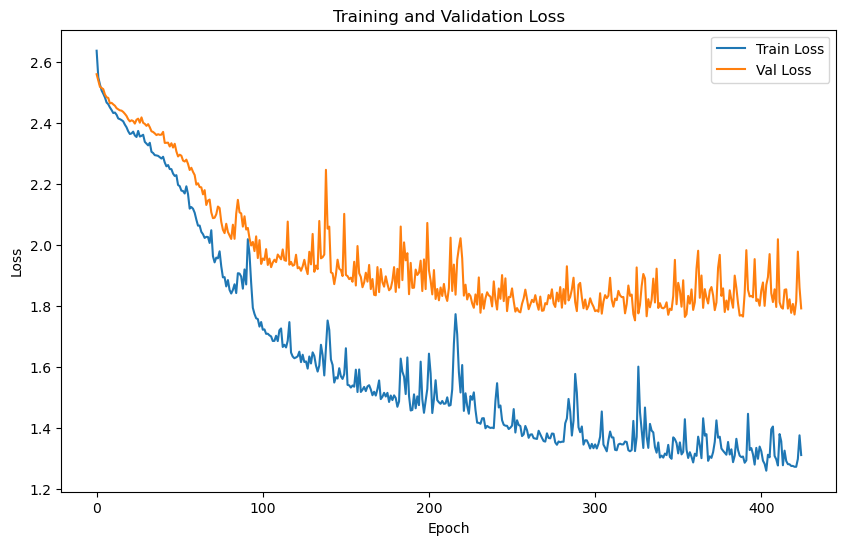

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8813 | Test Accuracy: 43.90%


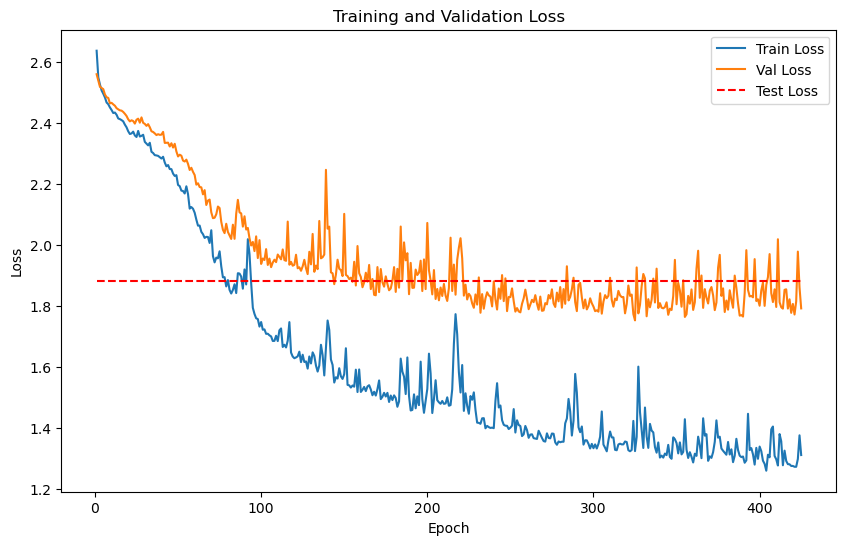

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.1351
Epoch [1/2000], Avg Train Loss: 8.1351
Epoch [1/2000], Avg Val Loss: 5.5484
Validation loss improved from inf to 5.5484. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1074
Epoch [2/2000], Avg Train Loss: 8.1074
Epoch [2/2000], Avg Val Loss: 5.5120
Validation loss improved from 5.5484 to 5.5120. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.0666
Epoch [3/2000], Avg Train Loss: 8.0666
Epoch [3/2000], Avg Val Loss: 5.4765
Validation loss improved from 5.5120 to 5.4765. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9683
Epoch [4/2000], Avg Train Loss: 7.9683
Epoch [4/2000], Avg Val Loss: 5.4415
Validation loss improved from 5.4765 to 5.4415. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.8576
Epoch [5/2000], Avg Train Loss: 7.8576
Epoch [5/2000], Avg Val Loss: 5.4072
Validation loss improved from 5.4415 to 5.4072. Saving mode

    Batch [1/1], Train Loss: 7.3489
Epoch [15/2000], Avg Train Loss: 7.3489
Epoch [15/2000], Avg Val Loss: 5.0799
Validation loss improved from 5.1113 to 5.0799. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 7.3339
Epoch [16/2000], Avg Train Loss: 7.3339
Epoch [16/2000], Avg Val Loss: 5.0487
Validation loss improved from 5.0799 to 5.0487. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 7.2582
Epoch [17/2000], Avg Train Loss: 7.2582
Epoch [17/2000], Avg Val Loss: 5.0179
Validation loss improved from 5.0487 to 5.0179. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 7.2902
Epoch [18/2000], Avg Train Loss: 7.2902
Epoch [18/2000], Avg Val Loss: 4.9875
Validation loss improved from 5.0179 to 4.9875. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 7.0885
Epoch [19/2000], Avg Train Loss: 7.0885
Epoch [19/2000], Avg Val Loss: 4.9575
Validation loss improved from 4.9875 to 4.

    Batch [1/1], Train Loss: 6.8484
Epoch [26/2000], Avg Train Loss: 6.8484
Epoch [26/2000], Avg Val Loss: 4.7565
Validation loss improved from 4.7841 to 4.7565. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.8042
Epoch [27/2000], Avg Train Loss: 6.8042
Epoch [27/2000], Avg Val Loss: 4.7294
Validation loss improved from 4.7565 to 4.7294. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.7670
Epoch [28/2000], Avg Train Loss: 6.7670
Epoch [28/2000], Avg Val Loss: 4.7026
Validation loss improved from 4.7294 to 4.7026. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.7382
Epoch [29/2000], Avg Train Loss: 6.7382
Epoch [29/2000], Avg Val Loss: 4.6764
Validation loss improved from 4.7026 to 4.6764. Saving model...

LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 6.7242
Epoch [30/2000], Avg Train Loss: 6.7242
Epoch [30/2000], Avg Val Loss: 4.6507
Validation loss improved from 4.6764 to 4.

    Batch [1/1], Train Loss: 6.4190
Epoch [37/2000], Avg Train Loss: 6.4190
Epoch [37/2000], Avg Val Loss: 4.4850
Validation loss improved from 4.5073 to 4.4850. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 6.4014
Epoch [38/2000], Avg Train Loss: 6.4014
Epoch [38/2000], Avg Val Loss: 4.4632
Validation loss improved from 4.4850 to 4.4632. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 6.3899
Epoch [39/2000], Avg Train Loss: 6.3899
Epoch [39/2000], Avg Val Loss: 4.4420
Validation loss improved from 4.4632 to 4.4420. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 6.3383
Epoch [40/2000], Avg Train Loss: 6.3383
Epoch [40/2000], Avg Val Loss: 4.4214
Validation loss improved from 4.4420 to 4.4214. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 6.3394
Epoch [41/2000], Avg Train Loss: 6.3394
Epoch [41/2000], Avg Val Loss: 4.4012
Validation loss improved from 4.4214 to 4.

Epoch [52/2000], Avg Val Loss: 4.2156
Validation loss improved from 4.2299 to 4.2156. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.9433
Epoch [53/2000], Avg Train Loss: 5.9433
Epoch [53/2000], Avg Val Loss: 4.2017
Validation loss improved from 4.2156 to 4.2017. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.9902
Epoch [54/2000], Avg Train Loss: 5.9902
Epoch [54/2000], Avg Val Loss: 4.1883
Validation loss improved from 4.2017 to 4.1883. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.9921
Epoch [55/2000], Avg Train Loss: 5.9921
Epoch [55/2000], Avg Val Loss: 4.1753
Validation loss improved from 4.1883 to 4.1753. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 6.0071
Epoch [56/2000], Avg Train Loss: 6.0071
Epoch [56/2000], Avg Val Loss: 4.1628
Validation loss improved from 4.1753 to 4.1628. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Trai

Epoch [62/2000], Avg Val Loss: 4.0964
Validation loss improved from 4.1065 to 4.0964. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 5.8490
Epoch [63/2000], Avg Train Loss: 5.8490
Epoch [63/2000], Avg Val Loss: 4.0868
Validation loss improved from 4.0964 to 4.0868. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.8226
Epoch [64/2000], Avg Train Loss: 5.8226
Epoch [64/2000], Avg Val Loss: 4.0775
Validation loss improved from 4.0868 to 4.0775. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.8379
Epoch [65/2000], Avg Train Loss: 5.8379
Epoch [65/2000], Avg Val Loss: 4.0686
Validation loss improved from 4.0775 to 4.0686. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.7783
Epoch [66/2000], Avg Train Loss: 5.7783
Epoch [66/2000], Avg Val Loss: 4.0600
Validation loss improved from 4.0686 to 4.0600. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.6934
Epoch [72/2000], Avg Train Loss: 5.6934
Epoch [72/2000], Avg Val Loss: 4.0146
Validation loss improved from 4.0215 to 4.0146. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.6724
Epoch [73/2000], Avg Train Loss: 5.6724
Epoch [73/2000], Avg Val Loss: 4.0080
Validation loss improved from 4.0146 to 4.0080. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.7055
Epoch [74/2000], Avg Train Loss: 5.7055
Epoch [74/2000], Avg Val Loss: 4.0016
Validation loss improved from 4.0080 to 4.0016. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.7569
Epoch [75/2000], Avg Train Loss: 5.7569
Epoch [75/2000], Avg Val Loss: 3.9953
Validation loss improved from 4.0016 to 3.9953. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 5.6863
Epoch [76/2000], Avg Train Loss: 5.6863
Epoch [76/2000], Avg Val Loss: 3.9892
Validation loss improved from 3.9953 to 3.

    Batch [1/1], Train Loss: 5.6080
Epoch [87/2000], Avg Train Loss: 5.6080
Epoch [87/2000], Avg Val Loss: 3.9360
Validation loss improved from 3.9400 to 3.9360. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.5257
Epoch [88/2000], Avg Train Loss: 5.5257
Epoch [88/2000], Avg Val Loss: 3.9320
Validation loss improved from 3.9360 to 3.9320. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.5448
Epoch [89/2000], Avg Train Loss: 5.5448
Epoch [89/2000], Avg Val Loss: 3.9283
Validation loss improved from 3.9320 to 3.9283. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.5945
Epoch [90/2000], Avg Train Loss: 5.5945
Epoch [90/2000], Avg Val Loss: 3.9245
Validation loss improved from 3.9283 to 3.9245. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 5.5581
Epoch [91/2000], Avg Train Loss: 5.5581
Epoch [91/2000], Avg Val Loss: 3.9209
Validation loss improved from 3.9245 to 3.

Epoch [94/2000], Avg Val Loss: 3.9107
Validation loss improved from 3.9140 to 3.9107. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.5071
Epoch [95/2000], Avg Train Loss: 5.5071
Epoch [95/2000], Avg Val Loss: 3.9076
Validation loss improved from 3.9107 to 3.9076. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.4871
Epoch [96/2000], Avg Train Loss: 5.4871
Epoch [96/2000], Avg Val Loss: 3.9045
Validation loss improved from 3.9076 to 3.9045. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.5380
Epoch [97/2000], Avg Train Loss: 5.5380
Epoch [97/2000], Avg Val Loss: 3.9015
Validation loss improved from 3.9045 to 3.9015. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 5.5083
Epoch [98/2000], Avg Train Loss: 5.5083
Epoch [98/2000], Avg Val Loss: 3.8987
Validation loss improved from 3.9015 to 3.8987. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Trai

Epoch [108/2000], Avg Val Loss: 3.8747
Validation loss improved from 3.8768 to 3.8747. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 5.4194
Epoch [109/2000], Avg Train Loss: 5.4194
Epoch [109/2000], Avg Val Loss: 3.8727
Validation loss improved from 3.8747 to 3.8727. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 5.4426
Epoch [110/2000], Avg Train Loss: 5.4426
Epoch [110/2000], Avg Val Loss: 3.8707
Validation loss improved from 3.8727 to 3.8707. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 5.3872
Epoch [111/2000], Avg Train Loss: 5.3872
Epoch [111/2000], Avg Val Loss: 3.8689
Validation loss improved from 3.8707 to 3.8689. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 5.4251
Epoch [112/2000], Avg Train Loss: 5.4251
Epoch [112/2000], Avg Val Loss: 3.8670
Validation loss improved from 3.8689 to 3.8670. Saving model...

LOG: Epoch [113/2000] - Training
    Bat

Epoch [125/2000], Avg Val Loss: 3.8460
Validation loss improved from 3.8474 to 3.8460. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 5.2798
Epoch [126/2000], Avg Train Loss: 5.2798
Epoch [126/2000], Avg Val Loss: 3.8447
Validation loss improved from 3.8460 to 3.8447. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 5.4103
Epoch [127/2000], Avg Train Loss: 5.4103
Epoch [127/2000], Avg Val Loss: 3.8434
Validation loss improved from 3.8447 to 3.8434. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 5.3165
Epoch [128/2000], Avg Train Loss: 5.3165
Epoch [128/2000], Avg Val Loss: 3.8422
Validation loss improved from 3.8434 to 3.8422. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 5.3310
Epoch [129/2000], Avg Train Loss: 5.3310
Epoch [129/2000], Avg Val Loss: 3.8409
Validation loss improved from 3.8422 to 3.8409. Saving model...

LOG: Epoch [130/2000] - Training
    Bat

Epoch [134/2000], Avg Val Loss: 3.8348
Validation loss improved from 3.8360 to 3.8348. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 5.3058
Epoch [135/2000], Avg Train Loss: 5.3058
Epoch [135/2000], Avg Val Loss: 3.8336
Validation loss improved from 3.8348 to 3.8336. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 5.2895
Epoch [136/2000], Avg Train Loss: 5.2895
Epoch [136/2000], Avg Val Loss: 3.8325
Validation loss improved from 3.8336 to 3.8325. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 5.3347
Epoch [137/2000], Avg Train Loss: 5.3347
Epoch [137/2000], Avg Val Loss: 3.8315
Validation loss improved from 3.8325 to 3.8315. Saving model...

LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 5.3556
Epoch [138/2000], Avg Train Loss: 5.3556
Epoch [138/2000], Avg Val Loss: 3.8304
Validation loss improved from 3.8315 to 3.8304. Saving model...

LOG: Epoch [139/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.2479
Epoch [149/2000], Avg Train Loss: 5.2479
Epoch [149/2000], Avg Val Loss: 3.8208
Validation loss improved from 3.8216 to 3.8208. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 5.2796
Epoch [150/2000], Avg Train Loss: 5.2796
Epoch [150/2000], Avg Val Loss: 3.8200
Validation loss improved from 3.8208 to 3.8200. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 5.2950
Epoch [151/2000], Avg Train Loss: 5.2950
Epoch [151/2000], Avg Val Loss: 3.8192
Validation loss improved from 3.8200 to 3.8192. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 5.2321
Epoch [152/2000], Avg Train Loss: 5.2321
Epoch [152/2000], Avg Val Loss: 3.8185
Validation loss improved from 3.8192 to 3.8185. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 5.2608
Epoch [153/2000], Avg Train Loss: 5.2608
Epoch [153/2000], Avg Val Loss: 3.8177
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2317
Epoch [165/2000], Avg Train Loss: 5.2317
Epoch [165/2000], Avg Val Loss: 3.8106
Validation loss improved from 3.8112 to 3.8106. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 5.2566
Epoch [166/2000], Avg Train Loss: 5.2566
Epoch [166/2000], Avg Val Loss: 3.8101
Validation loss improved from 3.8106 to 3.8101. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 5.2148
Epoch [167/2000], Avg Train Loss: 5.2148
Epoch [167/2000], Avg Val Loss: 3.8096
Validation loss improved from 3.8101 to 3.8096. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 5.2148
Epoch [168/2000], Avg Train Loss: 5.2148
Epoch [168/2000], Avg Val Loss: 3.8091
Validation loss improved from 3.8096 to 3.8091. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 5.2421
Epoch [169/2000], Avg Train Loss: 5.2421
Epoch [169/2000], Avg Val Loss: 3.8086
Validation loss improved fro

    Batch [1/1], Train Loss: 5.2241
Epoch [176/2000], Avg Train Loss: 5.2241
Epoch [176/2000], Avg Val Loss: 3.8050
Validation loss improved from 3.8055 to 3.8050. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 5.2127
Epoch [177/2000], Avg Train Loss: 5.2127
Epoch [177/2000], Avg Val Loss: 3.8045
Validation loss improved from 3.8050 to 3.8045. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 5.1868
Epoch [178/2000], Avg Train Loss: 5.1868
Epoch [178/2000], Avg Val Loss: 3.8040
Validation loss improved from 3.8045 to 3.8040. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 5.2291
Epoch [179/2000], Avg Train Loss: 5.2291
Epoch [179/2000], Avg Val Loss: 3.8036
Validation loss improved from 3.8040 to 3.8036. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 5.2359
Epoch [180/2000], Avg Train Loss: 5.2359
Epoch [180/2000], Avg Val Loss: 3.8031
Validation loss improved fro

    Batch [1/1], Train Loss: 5.1683
Epoch [189/2000], Avg Train Loss: 5.1683
Epoch [189/2000], Avg Val Loss: 3.7994
Validation loss improved from 3.7999 to 3.7994. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 5.1904
Epoch [190/2000], Avg Train Loss: 5.1904
Epoch [190/2000], Avg Val Loss: 3.7990
Validation loss improved from 3.7994 to 3.7990. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 5.1904
Epoch [191/2000], Avg Train Loss: 5.1904
Epoch [191/2000], Avg Val Loss: 3.7985
Validation loss improved from 3.7990 to 3.7985. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 5.1679
Epoch [192/2000], Avg Train Loss: 5.1679
Epoch [192/2000], Avg Val Loss: 3.7980
Validation loss improved from 3.7985 to 3.7980. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 5.1713
Epoch [193/2000], Avg Train Loss: 5.1713
Epoch [193/2000], Avg Val Loss: 3.7975
Validation loss improved fro

Epoch [200/2000], Avg Val Loss: 3.7947
Validation loss improved from 3.7951 to 3.7947. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 5.1864
Epoch [201/2000], Avg Train Loss: 5.1864
Epoch [201/2000], Avg Val Loss: 3.7943
Validation loss improved from 3.7947 to 3.7943. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 5.1689
Epoch [202/2000], Avg Train Loss: 5.1689
Epoch [202/2000], Avg Val Loss: 3.7940
Validation loss improved from 3.7943 to 3.7940. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 5.1581
Epoch [203/2000], Avg Train Loss: 5.1581
Epoch [203/2000], Avg Val Loss: 3.7936
Validation loss improved from 3.7940 to 3.7936. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 5.1139
Epoch [204/2000], Avg Train Loss: 5.1139
Epoch [204/2000], Avg Val Loss: 3.7932
Validation loss improved from 3.7936 to 3.7932. Saving model...

LOG: Epoch [205/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1364
Epoch [211/2000], Avg Train Loss: 5.1364
Epoch [211/2000], Avg Val Loss: 3.7918
Validation loss improved from 3.7919 to 3.7918. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 5.1290
Epoch [212/2000], Avg Train Loss: 5.1290
Epoch [212/2000], Avg Val Loss: 3.7916
Validation loss improved from 3.7918 to 3.7916. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 5.1216
Epoch [213/2000], Avg Train Loss: 5.1216
Epoch [213/2000], Avg Val Loss: 3.7914
Validation loss improved from 3.7916 to 3.7914. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 5.1516
Epoch [214/2000], Avg Train Loss: 5.1516
Epoch [214/2000], Avg Val Loss: 3.7913
Validation loss improved from 3.7914 to 3.7913. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 5.1345
Epoch [215/2000], Avg Train Loss: 5.1345
Epoch [215/2000], Avg Val Loss: 3.7911
Validation loss improved fro

Epoch [224/2000], Avg Val Loss: 3.7897
Validation loss improved from 3.7898 to 3.7897. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 5.1073
Epoch [225/2000], Avg Train Loss: 5.1073
Epoch [225/2000], Avg Val Loss: 3.7896
Validation loss improved from 3.7897 to 3.7896. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 5.1070
Epoch [226/2000], Avg Train Loss: 5.1070
Epoch [226/2000], Avg Val Loss: 3.7895
Validation loss improved from 3.7896 to 3.7895. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 5.1272
Epoch [227/2000], Avg Train Loss: 5.1272
Epoch [227/2000], Avg Val Loss: 3.7894
Validation loss improved from 3.7895 to 3.7894. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 5.1293
Epoch [228/2000], Avg Train Loss: 5.1293
Epoch [228/2000], Avg Val Loss: 3.7893
Validation loss improved from 3.7894 to 3.7893. Saving model...

LOG: Epoch [229/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.1152
Epoch [237/2000], Avg Train Loss: 5.1152
Epoch [237/2000], Avg Val Loss: 3.7879
Validation loss improved from 3.7881 to 3.7879. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 5.0869
Epoch [238/2000], Avg Train Loss: 5.0869
Epoch [238/2000], Avg Val Loss: 3.7876
Validation loss improved from 3.7879 to 3.7876. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 5.0816
Epoch [239/2000], Avg Train Loss: 5.0816
Epoch [239/2000], Avg Val Loss: 3.7874
Validation loss improved from 3.7876 to 3.7874. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 5.1238
Epoch [240/2000], Avg Train Loss: 5.1238
Epoch [240/2000], Avg Val Loss: 3.7871
Validation loss improved from 3.7874 to 3.7871. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 5.1321
Epoch [241/2000], Avg Train Loss: 5.1321
Epoch [241/2000], Avg Val Loss: 3.7868
Validation loss improved fro

Epoch [247/2000], Avg Val Loss: 3.7851
Validation loss improved from 3.7855 to 3.7851. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 5.0826
Epoch [248/2000], Avg Train Loss: 5.0826
Epoch [248/2000], Avg Val Loss: 3.7848
Validation loss improved from 3.7851 to 3.7848. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 5.1580
Epoch [249/2000], Avg Train Loss: 5.1580
Epoch [249/2000], Avg Val Loss: 3.7844
Validation loss improved from 3.7848 to 3.7844. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 5.0880
Epoch [250/2000], Avg Train Loss: 5.0880
Epoch [250/2000], Avg Val Loss: 3.7840
Validation loss improved from 3.7844 to 3.7840. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 5.0806
Epoch [251/2000], Avg Train Loss: 5.0806
Epoch [251/2000], Avg Val Loss: 3.7836
Validation loss improved from 3.7840 to 3.7836. Saving model...

LOG: Epoch [252/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0818
Epoch [261/2000], Avg Train Loss: 5.0818
Epoch [261/2000], Avg Val Loss: 3.7802
Validation loss improved from 3.7804 to 3.7802. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 5.0761
Epoch [262/2000], Avg Train Loss: 5.0761
Epoch [262/2000], Avg Val Loss: 3.7800
Validation loss improved from 3.7802 to 3.7800. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 5.1150
Epoch [263/2000], Avg Train Loss: 5.1150
Epoch [263/2000], Avg Val Loss: 3.7797
Validation loss improved from 3.7800 to 3.7797. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 5.0266
Epoch [264/2000], Avg Train Loss: 5.0266
Epoch [264/2000], Avg Val Loss: 3.7794
Validation loss improved from 3.7797 to 3.7794. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 5.0547
Epoch [265/2000], Avg Train Loss: 5.0547
Epoch [265/2000], Avg Val Loss: 3.7792
Validation loss improved fro

Epoch [273/2000], Avg Val Loss: 3.7778
Validation loss improved from 3.7779 to 3.7778. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 5.0621
Epoch [274/2000], Avg Train Loss: 5.0621
Epoch [274/2000], Avg Val Loss: 3.7777
Validation loss improved from 3.7778 to 3.7777. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 5.0774
Epoch [275/2000], Avg Train Loss: 5.0774
Epoch [275/2000], Avg Val Loss: 3.7776
Validation loss improved from 3.7777 to 3.7776. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 5.0428
Epoch [276/2000], Avg Train Loss: 5.0428
Epoch [276/2000], Avg Val Loss: 3.7775
Validation loss improved from 3.7776 to 3.7775. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 5.0630
Epoch [277/2000], Avg Train Loss: 5.0630
Epoch [277/2000], Avg Val Loss: 3.7773
Validation loss improved from 3.7775 to 3.7773. Saving model...

LOG: Epoch [278/2000] - Training
    Bat

    Batch [1/1], Train Loss: 5.0638
Epoch [284/2000], Avg Train Loss: 5.0638
Epoch [284/2000], Avg Val Loss: 3.7763
Validation loss improved from 3.7765 to 3.7763. Saving model...

LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 5.0568
Epoch [285/2000], Avg Train Loss: 5.0568
Epoch [285/2000], Avg Val Loss: 3.7762
Validation loss improved from 3.7763 to 3.7762. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 5.0330
Epoch [286/2000], Avg Train Loss: 5.0330
Epoch [286/2000], Avg Val Loss: 3.7760
Validation loss improved from 3.7762 to 3.7760. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 5.0374
Epoch [287/2000], Avg Train Loss: 5.0374
Epoch [287/2000], Avg Val Loss: 3.7760
Validation loss improved from 3.7760 to 3.7760. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 5.0702
Epoch [288/2000], Avg Train Loss: 5.0702
Epoch [288/2000], Avg Val Loss: 3.7758
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0707
Epoch [299/2000], Avg Train Loss: 5.0707
Epoch [299/2000], Avg Val Loss: 3.7747
Validation loss improved from 3.7748 to 3.7747. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 5.0507
Epoch [300/2000], Avg Train Loss: 5.0507
Epoch [300/2000], Avg Val Loss: 3.7744
Validation loss improved from 3.7747 to 3.7744. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 5.0322
Epoch [301/2000], Avg Train Loss: 5.0322
Epoch [301/2000], Avg Val Loss: 3.7742
Validation loss improved from 3.7744 to 3.7742. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 5.0488
Epoch [302/2000], Avg Train Loss: 5.0488
Epoch [302/2000], Avg Val Loss: 3.7740
Validation loss improved from 3.7742 to 3.7740. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 5.0180
Epoch [303/2000], Avg Train Loss: 5.0180
Epoch [303/2000], Avg Val Loss: 3.7738
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0374
Epoch [313/2000], Avg Train Loss: 5.0374
Epoch [313/2000], Avg Val Loss: 3.7729
Validation loss improved from 3.7730 to 3.7729. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.9954
Epoch [314/2000], Avg Train Loss: 4.9954
Epoch [314/2000], Avg Val Loss: 3.7728
Validation loss improved from 3.7729 to 3.7728. Saving model...

LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 5.0230
Epoch [315/2000], Avg Train Loss: 5.0230
Epoch [315/2000], Avg Val Loss: 3.7728
Validation loss improved from 3.7728 to 3.7728. Saving model...

LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 5.0237
Epoch [316/2000], Avg Train Loss: 5.0237
Epoch [316/2000], Avg Val Loss: 3.7727
Validation loss improved from 3.7728 to 3.7727. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 5.0287
Epoch [317/2000], Avg Train Loss: 5.0287
Epoch [317/2000], Avg Val Loss: 3.7726
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0203
Epoch [321/2000], Avg Train Loss: 5.0203
Epoch [321/2000], Avg Val Loss: 3.7724
Validation loss improved from 3.7725 to 3.7724. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 5.0066
Epoch [322/2000], Avg Train Loss: 5.0066
Epoch [322/2000], Avg Val Loss: 3.7724
Validation loss improved from 3.7724 to 3.7724. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 5.0092
Epoch [323/2000], Avg Train Loss: 5.0092
Epoch [323/2000], Avg Val Loss: 3.7723
Validation loss improved from 3.7724 to 3.7723. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 5.0214
Epoch [324/2000], Avg Train Loss: 5.0214
Epoch [324/2000], Avg Val Loss: 3.7722
Validation loss improved from 3.7723 to 3.7722. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 4.9993
Epoch [325/2000], Avg Train Loss: 4.9993
Epoch [325/2000], Avg Val Loss: 3.7722
Validation loss improved fro

Epoch [335/2000], Avg Val Loss: 3.7708
Validation loss improved from 3.7710 to 3.7708. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.9994
Epoch [336/2000], Avg Train Loss: 4.9994
Epoch [336/2000], Avg Val Loss: 3.7707
Validation loss improved from 3.7708 to 3.7707. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.9967
Epoch [337/2000], Avg Train Loss: 4.9967
Epoch [337/2000], Avg Val Loss: 3.7706
Validation loss improved from 3.7707 to 3.7706. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.9890
Epoch [338/2000], Avg Train Loss: 4.9890
Epoch [338/2000], Avg Val Loss: 3.7705
Validation loss improved from 3.7706 to 3.7705. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.9994
Epoch [339/2000], Avg Train Loss: 4.9994
Epoch [339/2000], Avg Val Loss: 3.7703
Validation loss improved from 3.7705 to 3.7703. Saving model...

LOG: Epoch [340/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9986
Epoch [354/2000], Avg Train Loss: 4.9986
Epoch [354/2000], Avg Val Loss: 3.7676
Validation loss improved from 3.7678 to 3.7676. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 4.9936
Epoch [355/2000], Avg Train Loss: 4.9936
Epoch [355/2000], Avg Val Loss: 3.7675
Validation loss improved from 3.7676 to 3.7675. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 4.9846
Epoch [356/2000], Avg Train Loss: 4.9846
Epoch [356/2000], Avg Val Loss: 3.7673
Validation loss improved from 3.7675 to 3.7673. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 5.0200
Epoch [357/2000], Avg Train Loss: 5.0200
Epoch [357/2000], Avg Val Loss: 3.7670
Validation loss improved from 3.7673 to 3.7670. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 4.9936
Epoch [358/2000], Avg Train Loss: 4.9936
Epoch [358/2000], Avg Val Loss: 3.7668
Validation loss improved fro

    Batch [1/1], Train Loss: 5.0093
Epoch [359/2000], Avg Train Loss: 5.0093
Epoch [359/2000], Avg Val Loss: 3.7665
Validation loss improved from 3.7668 to 3.7665. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 4.9911
Epoch [360/2000], Avg Train Loss: 4.9911
Epoch [360/2000], Avg Val Loss: 3.7662
Validation loss improved from 3.7665 to 3.7662. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 4.9910
Epoch [361/2000], Avg Train Loss: 4.9910
Epoch [361/2000], Avg Val Loss: 3.7658
Validation loss improved from 3.7662 to 3.7658. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 5.0136
Epoch [362/2000], Avg Train Loss: 5.0136
Epoch [362/2000], Avg Val Loss: 3.7654
Validation loss improved from 3.7658 to 3.7654. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 4.9849
Epoch [363/2000], Avg Train Loss: 4.9849
Epoch [363/2000], Avg Val Loss: 3.7650
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9681
Epoch [375/2000], Avg Train Loss: 4.9681
Epoch [375/2000], Avg Val Loss: 3.7618
Validation loss improved from 3.7619 to 3.7618. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.9653
Epoch [376/2000], Avg Train Loss: 4.9653
Epoch [376/2000], Avg Val Loss: 3.7616
Validation loss improved from 3.7618 to 3.7616. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.9803
Epoch [377/2000], Avg Train Loss: 4.9803
Epoch [377/2000], Avg Val Loss: 3.7616
Validation loss improved from 3.7616 to 3.7616. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.9786
Epoch [378/2000], Avg Train Loss: 4.9786
Epoch [378/2000], Avg Val Loss: 3.7614
Validation loss improved from 3.7616 to 3.7614. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.9868
Epoch [379/2000], Avg Train Loss: 4.9868
Epoch [379/2000], Avg Val Loss: 3.7613
Validation loss improved fro

Epoch [393/2000], Avg Val Loss: 3.7593
Validation loss improved from 3.7594 to 3.7593. Saving model...

LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 4.9639
Epoch [394/2000], Avg Train Loss: 4.9639
Epoch [394/2000], Avg Val Loss: 3.7592
Validation loss improved from 3.7593 to 3.7592. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.9803
Epoch [395/2000], Avg Train Loss: 4.9803
Epoch [395/2000], Avg Val Loss: 3.7590
Validation loss improved from 3.7592 to 3.7590. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.9726
Epoch [396/2000], Avg Train Loss: 4.9726
Epoch [396/2000], Avg Val Loss: 3.7588
Validation loss improved from 3.7590 to 3.7588. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.9606
Epoch [397/2000], Avg Train Loss: 4.9606
Epoch [397/2000], Avg Val Loss: 3.7587
Validation loss improved from 3.7588 to 3.7587. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.9600
Epoch [398/2000], Avg Train Loss: 4.9600
Epoch [398/2000], Avg Val Loss: 3.7587
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9620
Epoch [415/2000], Avg Train Loss: 4.9620
Epoch [415/2000], Avg Val Loss: 3.7588
Validation loss did not improve. Patience: 17/100

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.9402
Epoch [416/2000], Avg Train Loss: 4.9402
Epoch [416/2000], Avg Val Loss: 3.7587
Validation loss did not improve. Patience: 18/100

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 4.9309
Epoch [417/2000], Avg Train Loss: 4.9309
Epoch [417/2000], Avg Val Loss: 3.7586
Validation loss improved from 3.7587 to 3.7586. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 4.9388
Epoch [418/2000], Avg Train Loss: 4.9388
Epoch [418/2000], Avg Val Loss: 3.7585
Validation loss improved from 3.7586 to 3.7585. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 4.9644
Epoch [419/2000], Avg Train Loss: 4.9644
Epoch [419/2000], Avg Val Loss: 3.7584
Validation loss improved from 3.7585 to 3.7584. Saving m

    Batch [1/1], Train Loss: 4.9574
Epoch [434/2000], Avg Train Loss: 4.9574
Epoch [434/2000], Avg Val Loss: 3.7562
Validation loss improved from 3.7565 to 3.7562. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 4.9366
Epoch [435/2000], Avg Train Loss: 4.9366
Epoch [435/2000], Avg Val Loss: 3.7560
Validation loss improved from 3.7562 to 3.7560. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.9193
Epoch [436/2000], Avg Train Loss: 4.9193
Epoch [436/2000], Avg Val Loss: 3.7558
Validation loss improved from 3.7560 to 3.7558. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.9195
Epoch [437/2000], Avg Train Loss: 4.9195
Epoch [437/2000], Avg Val Loss: 3.7556
Validation loss improved from 3.7558 to 3.7556. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.9406
Epoch [438/2000], Avg Train Loss: 4.9406
Epoch [438/2000], Avg Val Loss: 3.7555
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8964
Epoch [452/2000], Avg Train Loss: 4.8964
Epoch [452/2000], Avg Val Loss: 3.7523
Validation loss improved from 3.7523 to 3.7523. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 4.9459
Epoch [453/2000], Avg Train Loss: 4.9459
Epoch [453/2000], Avg Val Loss: 3.7521
Validation loss improved from 3.7523 to 3.7521. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.9431
Epoch [454/2000], Avg Train Loss: 4.9431
Epoch [454/2000], Avg Val Loss: 3.7521
Validation loss improved from 3.7521 to 3.7521. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.8994
Epoch [455/2000], Avg Train Loss: 4.8994
Epoch [455/2000], Avg Val Loss: 3.7521
Validation loss did not improve. Patience: 1/100

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 4.9128
Epoch [456/2000], Avg Train Loss: 4.9128
Epoch [456/2000], Avg Val Loss: 3.7521
Validation loss improved from 3.7521 to 3.7

    Batch [1/1], Train Loss: 4.9114
Epoch [475/2000], Avg Train Loss: 4.9114
Epoch [475/2000], Avg Val Loss: 3.7505
Validation loss improved from 3.7506 to 3.7505. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.9137
Epoch [476/2000], Avg Train Loss: 4.9137
Epoch [476/2000], Avg Val Loss: 3.7504
Validation loss improved from 3.7505 to 3.7504. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.9214
Epoch [477/2000], Avg Train Loss: 4.9214
Epoch [477/2000], Avg Val Loss: 3.7503
Validation loss improved from 3.7504 to 3.7503. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.8707
Epoch [478/2000], Avg Train Loss: 4.8707
Epoch [478/2000], Avg Val Loss: 3.7503
Validation loss did not improve. Patience: 1/100

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.9249
Epoch [479/2000], Avg Train Loss: 4.9249
Epoch [479/2000], Avg Val Loss: 3.7504
Validation loss did not improve. Patience: 

Epoch [490/2000], Avg Val Loss: 3.7516
Validation loss did not improve. Patience: 13/100

LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 4.8796
Epoch [491/2000], Avg Train Loss: 4.8796
Epoch [491/2000], Avg Val Loss: 3.7517
Validation loss did not improve. Patience: 14/100

LOG: Epoch [492/2000] - Training
    Batch [1/1], Train Loss: 4.8946
Epoch [492/2000], Avg Train Loss: 4.8946
Epoch [492/2000], Avg Val Loss: 3.7517
Validation loss did not improve. Patience: 15/100

LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 4.8927
Epoch [493/2000], Avg Train Loss: 4.8927
Epoch [493/2000], Avg Val Loss: 3.7515
Validation loss did not improve. Patience: 16/100

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 4.8872
Epoch [494/2000], Avg Train Loss: 4.8872
Epoch [494/2000], Avg Val Loss: 3.7513
Validation loss did not improve. Patience: 17/100

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 4.8815
Epoch [495/2000], Avg Train Loss: 4.8815


Epoch [513/2000], Avg Val Loss: 3.7482
Validation loss improved from 3.7485 to 3.7482. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.8962
Epoch [514/2000], Avg Train Loss: 4.8962
Epoch [514/2000], Avg Val Loss: 3.7478
Validation loss improved from 3.7482 to 3.7478. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.9099
Epoch [515/2000], Avg Train Loss: 4.9099
Epoch [515/2000], Avg Val Loss: 3.7475
Validation loss improved from 3.7478 to 3.7475. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.8913
Epoch [516/2000], Avg Train Loss: 4.8913
Epoch [516/2000], Avg Val Loss: 3.7471
Validation loss improved from 3.7475 to 3.7471. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.8582
Epoch [517/2000], Avg Train Loss: 4.8582
Epoch [517/2000], Avg Val Loss: 3.7467
Validation loss improved from 3.7471 to 3.7467. Saving model...

LOG: Epoch [518/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8661
Epoch [527/2000], Avg Train Loss: 4.8661
Epoch [527/2000], Avg Val Loss: 3.7427
Validation loss improved from 3.7431 to 3.7427. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.9127
Epoch [528/2000], Avg Train Loss: 4.9127
Epoch [528/2000], Avg Val Loss: 3.7425
Validation loss improved from 3.7427 to 3.7425. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.8753
Epoch [529/2000], Avg Train Loss: 4.8753
Epoch [529/2000], Avg Val Loss: 3.7424
Validation loss improved from 3.7425 to 3.7424. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.8475
Epoch [530/2000], Avg Train Loss: 4.8475
Epoch [530/2000], Avg Val Loss: 3.7423
Validation loss improved from 3.7424 to 3.7423. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.8874
Epoch [531/2000], Avg Train Loss: 4.8874
Epoch [531/2000], Avg Val Loss: 3.7423
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8965
Epoch [549/2000], Avg Train Loss: 4.8965
Epoch [549/2000], Avg Val Loss: 3.7406
Validation loss improved from 3.7408 to 3.7406. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.8875
Epoch [550/2000], Avg Train Loss: 4.8875
Epoch [550/2000], Avg Val Loss: 3.7404
Validation loss improved from 3.7406 to 3.7404. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.8701
Epoch [551/2000], Avg Train Loss: 4.8701
Epoch [551/2000], Avg Val Loss: 3.7403
Validation loss improved from 3.7404 to 3.7403. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.8814
Epoch [552/2000], Avg Train Loss: 4.8814
Epoch [552/2000], Avg Val Loss: 3.7401
Validation loss improved from 3.7403 to 3.7401. Saving model...

LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 4.8807
Epoch [553/2000], Avg Train Loss: 4.8807
Epoch [553/2000], Avg Val Loss: 3.7400
Validation loss improved fro

Epoch [565/2000], Avg Val Loss: 3.7374
Validation loss improved from 3.7374 to 3.7374. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.8605
Epoch [566/2000], Avg Train Loss: 4.8605
Epoch [566/2000], Avg Val Loss: 3.7372
Validation loss improved from 3.7374 to 3.7372. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.8346
Epoch [567/2000], Avg Train Loss: 4.8346
Epoch [567/2000], Avg Val Loss: 3.7371
Validation loss improved from 3.7372 to 3.7371. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.8673
Epoch [568/2000], Avg Train Loss: 4.8673
Epoch [568/2000], Avg Val Loss: 3.7370
Validation loss improved from 3.7371 to 3.7370. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.8458
Epoch [569/2000], Avg Train Loss: 4.8458
Epoch [569/2000], Avg Val Loss: 3.7369
Validation loss improved from 3.7370 to 3.7369. Saving model...

LOG: Epoch [570/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8555
Epoch [588/2000], Avg Train Loss: 4.8555
Epoch [588/2000], Avg Val Loss: 3.7320
Validation loss improved from 3.7324 to 3.7320. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.8368
Epoch [589/2000], Avg Train Loss: 4.8368
Epoch [589/2000], Avg Val Loss: 3.7319
Validation loss improved from 3.7320 to 3.7319. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.8318
Epoch [590/2000], Avg Train Loss: 4.8318
Epoch [590/2000], Avg Val Loss: 3.7317
Validation loss improved from 3.7319 to 3.7317. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 4.8210
Epoch [591/2000], Avg Train Loss: 4.8210
Epoch [591/2000], Avg Val Loss: 3.7316
Validation loss improved from 3.7317 to 3.7316. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 4.8520
Epoch [592/2000], Avg Train Loss: 4.8520
Epoch [592/2000], Avg Val Loss: 3.7314
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8111
Epoch [604/2000], Avg Train Loss: 4.8111
Epoch [604/2000], Avg Val Loss: 3.7295
Validation loss improved from 3.7295 to 3.7295. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 4.8314
Epoch [605/2000], Avg Train Loss: 4.8314
Epoch [605/2000], Avg Val Loss: 3.7295
Validation loss improved from 3.7295 to 3.7295. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 4.8393
Epoch [606/2000], Avg Train Loss: 4.8393
Epoch [606/2000], Avg Val Loss: 3.7293
Validation loss improved from 3.7295 to 3.7293. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 4.8386
Epoch [607/2000], Avg Train Loss: 4.8386
Epoch [607/2000], Avg Val Loss: 3.7292
Validation loss improved from 3.7293 to 3.7292. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 4.8024
Epoch [608/2000], Avg Train Loss: 4.8024
Epoch [608/2000], Avg Val Loss: 3.7292
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8031
Epoch [625/2000], Avg Train Loss: 4.8031
Epoch [625/2000], Avg Val Loss: 3.7248
Validation loss improved from 3.7249 to 3.7248. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 4.8048
Epoch [626/2000], Avg Train Loss: 4.8048
Epoch [626/2000], Avg Val Loss: 3.7248
Validation loss did not improve. Patience: 1/100

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 4.8344
Epoch [627/2000], Avg Train Loss: 4.8344
Epoch [627/2000], Avg Val Loss: 3.7248
Validation loss improved from 3.7248 to 3.7248. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 4.8029
Epoch [628/2000], Avg Train Loss: 4.8029
Epoch [628/2000], Avg Val Loss: 3.7247
Validation loss improved from 3.7248 to 3.7247. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 4.8150
Epoch [629/2000], Avg Train Loss: 4.8150
Epoch [629/2000], Avg Val Loss: 3.7245
Validation loss improved from 3.7247 to 3.7

    Batch [1/1], Train Loss: 4.8067
Epoch [642/2000], Avg Train Loss: 4.8067
Epoch [642/2000], Avg Val Loss: 3.7215
Validation loss improved from 3.7218 to 3.7215. Saving model...

LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 4.7896
Epoch [643/2000], Avg Train Loss: 4.7896
Epoch [643/2000], Avg Val Loss: 3.7213
Validation loss improved from 3.7215 to 3.7213. Saving model...

LOG: Epoch [644/2000] - Training
    Batch [1/1], Train Loss: 4.8158
Epoch [644/2000], Avg Train Loss: 4.8158
Epoch [644/2000], Avg Val Loss: 3.7211
Validation loss improved from 3.7213 to 3.7211. Saving model...

LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 4.7603
Epoch [645/2000], Avg Train Loss: 4.7603
Epoch [645/2000], Avg Val Loss: 3.7211
Validation loss did not improve. Patience: 1/100

LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 4.7919
Epoch [646/2000], Avg Train Loss: 4.7919
Epoch [646/2000], Avg Val Loss: 3.7211
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.8145
Epoch [663/2000], Avg Train Loss: 4.8145
Epoch [663/2000], Avg Val Loss: 3.7200
Validation loss improved from 3.7205 to 3.7200. Saving model...

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.7907
Epoch [664/2000], Avg Train Loss: 4.7907
Epoch [664/2000], Avg Val Loss: 3.7197
Validation loss improved from 3.7200 to 3.7197. Saving model...

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.8113
Epoch [665/2000], Avg Train Loss: 4.8113
Epoch [665/2000], Avg Val Loss: 3.7194
Validation loss improved from 3.7197 to 3.7194. Saving model...

LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 4.8315
Epoch [666/2000], Avg Train Loss: 4.8315
Epoch [666/2000], Avg Val Loss: 3.7191
Validation loss improved from 3.7194 to 3.7191. Saving model...

LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 4.7907
Epoch [667/2000], Avg Train Loss: 4.7907
Epoch [667/2000], Avg Val Loss: 3.7188
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8002
Epoch [684/2000], Avg Train Loss: 4.8002
Epoch [684/2000], Avg Val Loss: 3.7115
Validation loss improved from 3.7119 to 3.7115. Saving model...

LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 4.7826
Epoch [685/2000], Avg Train Loss: 4.7826
Epoch [685/2000], Avg Val Loss: 3.7111
Validation loss improved from 3.7115 to 3.7111. Saving model...

LOG: Epoch [686/2000] - Training
    Batch [1/1], Train Loss: 4.7848
Epoch [686/2000], Avg Train Loss: 4.7848
Epoch [686/2000], Avg Val Loss: 3.7107
Validation loss improved from 3.7111 to 3.7107. Saving model...

LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 4.7568
Epoch [687/2000], Avg Train Loss: 4.7568
Epoch [687/2000], Avg Val Loss: 3.7105
Validation loss improved from 3.7107 to 3.7105. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 4.8004
Epoch [688/2000], Avg Train Loss: 4.8004
Epoch [688/2000], Avg Val Loss: 3.7103
Validation loss improved fro

Epoch [703/2000], Avg Val Loss: 3.7075
Validation loss improved from 3.7076 to 3.7075. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 4.7967
Epoch [704/2000], Avg Train Loss: 4.7967
Epoch [704/2000], Avg Val Loss: 3.7074
Validation loss improved from 3.7075 to 3.7074. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 4.7656
Epoch [705/2000], Avg Train Loss: 4.7656
Epoch [705/2000], Avg Val Loss: 3.7073
Validation loss improved from 3.7074 to 3.7073. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 4.7797
Epoch [706/2000], Avg Train Loss: 4.7797
Epoch [706/2000], Avg Val Loss: 3.7072
Validation loss improved from 3.7073 to 3.7072. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 4.7452
Epoch [707/2000], Avg Train Loss: 4.7452
Epoch [707/2000], Avg Val Loss: 3.7070
Validation loss improved from 3.7072 to 3.7070. Saving model...

LOG: Epoch [708/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7765
Epoch [724/2000], Avg Train Loss: 4.7765
Epoch [724/2000], Avg Val Loss: 3.7022
Validation loss did not improve. Patience: 3/100

LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 4.7489
Epoch [725/2000], Avg Train Loss: 4.7489
Epoch [725/2000], Avg Val Loss: 3.7023
Validation loss did not improve. Patience: 4/100

LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 4.7382
Epoch [726/2000], Avg Train Loss: 4.7382
Epoch [726/2000], Avg Val Loss: 3.7024
Validation loss did not improve. Patience: 5/100

LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 4.7439
Epoch [727/2000], Avg Train Loss: 4.7439
Epoch [727/2000], Avg Val Loss: 3.7023
Validation loss did not improve. Patience: 6/100

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 4.7361
Epoch [728/2000], Avg Train Loss: 4.7361
Epoch [728/2000], Avg Val Loss: 3.7022
Validation loss did not improve. Patience: 7/100

LOG: Epoch [729/2000] - Training
    B

    Batch [1/1], Train Loss: 4.7278
Epoch [742/2000], Avg Train Loss: 4.7278
Epoch [742/2000], Avg Val Loss: 3.7021
Validation loss did not improve. Patience: 6/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.7684
Epoch [743/2000], Avg Train Loss: 4.7684
Epoch [743/2000], Avg Val Loss: 3.7022
Validation loss did not improve. Patience: 7/100

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 4.7523
Epoch [744/2000], Avg Train Loss: 4.7523
Epoch [744/2000], Avg Val Loss: 3.7023
Validation loss did not improve. Patience: 8/100

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 4.7190
Epoch [745/2000], Avg Train Loss: 4.7190
Epoch [745/2000], Avg Val Loss: 3.7024
Validation loss did not improve. Patience: 9/100

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 4.7743
Epoch [746/2000], Avg Train Loss: 4.7743
Epoch [746/2000], Avg Val Loss: 3.7027
Validation loss did not improve. Patience: 10/100

LOG: Epoch [747/2000] - Training
    

    Batch [1/1], Train Loss: 4.7051
Epoch [763/2000], Avg Train Loss: 4.7051
Epoch [763/2000], Avg Val Loss: 3.7010
Validation loss improved from 3.7011 to 3.7010. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 4.7244
Epoch [764/2000], Avg Train Loss: 4.7244
Epoch [764/2000], Avg Val Loss: 3.7006
Validation loss improved from 3.7010 to 3.7006. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 4.6955
Epoch [765/2000], Avg Train Loss: 4.6955
Epoch [765/2000], Avg Val Loss: 3.7003
Validation loss improved from 3.7006 to 3.7003. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 4.7271
Epoch [766/2000], Avg Train Loss: 4.7271
Epoch [766/2000], Avg Val Loss: 3.7000
Validation loss improved from 3.7003 to 3.7000. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 4.7323
Epoch [767/2000], Avg Train Loss: 4.7323
Epoch [767/2000], Avg Val Loss: 3.6998
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6959
Epoch [781/2000], Avg Train Loss: 4.6959
Epoch [781/2000], Avg Val Loss: 3.7001
Validation loss did not improve. Patience: 6/100

LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 4.7418
Epoch [782/2000], Avg Train Loss: 4.7418
Epoch [782/2000], Avg Val Loss: 3.7001
Validation loss did not improve. Patience: 7/100

LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 4.7425
Epoch [783/2000], Avg Train Loss: 4.7425
Epoch [783/2000], Avg Val Loss: 3.7000
Validation loss did not improve. Patience: 8/100

LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 4.7412
Epoch [784/2000], Avg Train Loss: 4.7412
Epoch [784/2000], Avg Val Loss: 3.6999
Validation loss did not improve. Patience: 9/100

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 4.7202
Epoch [785/2000], Avg Train Loss: 4.7202
Epoch [785/2000], Avg Val Loss: 3.6997
Validation loss did not improve. Patience: 10/100

LOG: Epoch [786/2000] - Training
    

    Batch [1/1], Train Loss: 4.7284
Epoch [799/2000], Avg Train Loss: 4.7284
Epoch [799/2000], Avg Val Loss: 3.6949
Validation loss improved from 3.6951 to 3.6949. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 4.7269
Epoch [800/2000], Avg Train Loss: 4.7269
Epoch [800/2000], Avg Val Loss: 3.6947
Validation loss improved from 3.6949 to 3.6947. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 4.7332
Epoch [801/2000], Avg Train Loss: 4.7332
Epoch [801/2000], Avg Val Loss: 3.6946
Validation loss improved from 3.6947 to 3.6946. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 4.7152
Epoch [802/2000], Avg Train Loss: 4.7152
Epoch [802/2000], Avg Val Loss: 3.6946
Validation loss improved from 3.6946 to 3.6946. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 4.7097
Epoch [803/2000], Avg Train Loss: 4.7097
Epoch [803/2000], Avg Val Loss: 3.6945
Validation loss improved fro

Epoch [818/2000], Avg Val Loss: 3.6943
Validation loss did not improve. Patience: 5/100

LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 4.7051
Epoch [819/2000], Avg Train Loss: 4.7051
Epoch [819/2000], Avg Val Loss: 3.6949
Validation loss did not improve. Patience: 6/100

LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 4.7032
Epoch [820/2000], Avg Train Loss: 4.7032
Epoch [820/2000], Avg Val Loss: 3.6958
Validation loss did not improve. Patience: 7/100

LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 4.7224
Epoch [821/2000], Avg Train Loss: 4.7224
Epoch [821/2000], Avg Val Loss: 3.6967
Validation loss did not improve. Patience: 8/100

LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 4.7052
Epoch [822/2000], Avg Train Loss: 4.7052
Epoch [822/2000], Avg Val Loss: 3.6975
Validation loss did not improve. Patience: 9/100

LOG: Epoch [823/2000] - Training
    Batch [1/1], Train Loss: 4.6537
Epoch [823/2000], Avg Train Loss: 4.6537
Epoch

    Batch [1/1], Train Loss: 4.7010
Epoch [836/2000], Avg Train Loss: 4.7010
Epoch [836/2000], Avg Val Loss: 3.6977
Validation loss did not improve. Patience: 23/100

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 4.6784
Epoch [837/2000], Avg Train Loss: 4.6784
Epoch [837/2000], Avg Val Loss: 3.6967
Validation loss did not improve. Patience: 24/100

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 4.7228
Epoch [838/2000], Avg Train Loss: 4.7228
Epoch [838/2000], Avg Val Loss: 3.6960
Validation loss did not improve. Patience: 25/100

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 4.6948
Epoch [839/2000], Avg Train Loss: 4.6948
Epoch [839/2000], Avg Val Loss: 3.6953
Validation loss did not improve. Patience: 26/100

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 4.6544
Epoch [840/2000], Avg Train Loss: 4.6544
Epoch [840/2000], Avg Val Loss: 3.6949
Validation loss did not improve. Patience: 27/100

LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 4.6860
Epoch [856/2000], Avg Train Loss: 4.6860
Epoch [856/2000], Avg Val Loss: 3.6893
Validation loss improved from 3.6899 to 3.6893. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 4.6865
Epoch [857/2000], Avg Train Loss: 4.6865
Epoch [857/2000], Avg Val Loss: 3.6886
Validation loss improved from 3.6893 to 3.6886. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/1], Train Loss: 4.6794
Epoch [858/2000], Avg Train Loss: 4.6794
Epoch [858/2000], Avg Val Loss: 3.6879
Validation loss improved from 3.6886 to 3.6879. Saving model...

LOG: Epoch [859/2000] - Training
    Batch [1/1], Train Loss: 4.6518
Epoch [859/2000], Avg Train Loss: 4.6518
Epoch [859/2000], Avg Val Loss: 3.6871
Validation loss improved from 3.6879 to 3.6871. Saving model...

LOG: Epoch [860/2000] - Training
    Batch [1/1], Train Loss: 4.6775
Epoch [860/2000], Avg Train Loss: 4.6775
Epoch [860/2000], Avg Val Loss: 3.6866
Validation loss improved fro

Epoch [875/2000], Avg Val Loss: 3.6845
Validation loss did not improve. Patience: 8/100

LOG: Epoch [876/2000] - Training
    Batch [1/1], Train Loss: 4.6733
Epoch [876/2000], Avg Train Loss: 4.6733
Epoch [876/2000], Avg Val Loss: 3.6841
Validation loss did not improve. Patience: 9/100

LOG: Epoch [877/2000] - Training
    Batch [1/1], Train Loss: 4.6709
Epoch [877/2000], Avg Train Loss: 4.6709
Epoch [877/2000], Avg Val Loss: 3.6840
Validation loss did not improve. Patience: 10/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 4.6400
Epoch [878/2000], Avg Train Loss: 4.6400
Epoch [878/2000], Avg Val Loss: 3.6840
Validation loss did not improve. Patience: 11/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 4.6491
Epoch [879/2000], Avg Train Loss: 4.6491
Epoch [879/2000], Avg Val Loss: 3.6841
Validation loss did not improve. Patience: 12/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 4.6541
Epoch [880/2000], Avg Train Loss: 4.6541
Ep

    Batch [1/1], Train Loss: 4.6634
Epoch [893/2000], Avg Train Loss: 4.6634
Epoch [893/2000], Avg Val Loss: 3.6863
Validation loss did not improve. Patience: 26/100

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 4.6520
Epoch [894/2000], Avg Train Loss: 4.6520
Epoch [894/2000], Avg Val Loss: 3.6867
Validation loss did not improve. Patience: 27/100

LOG: Epoch [895/2000] - Training
    Batch [1/1], Train Loss: 4.6394
Epoch [895/2000], Avg Train Loss: 4.6394
Epoch [895/2000], Avg Val Loss: 3.6872
Validation loss did not improve. Patience: 28/100

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 4.6506
Epoch [896/2000], Avg Train Loss: 4.6506
Epoch [896/2000], Avg Val Loss: 3.6876
Validation loss did not improve. Patience: 29/100

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 4.6899
Epoch [897/2000], Avg Train Loss: 4.6899
Epoch [897/2000], Avg Val Loss: 3.6878
Validation loss did not improve. Patience: 30/100

LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 4.6596
Epoch [913/2000], Avg Train Loss: 4.6596
Epoch [913/2000], Avg Val Loss: 3.6909
Validation loss did not improve. Patience: 46/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 4.6439
Epoch [914/2000], Avg Train Loss: 4.6439
Epoch [914/2000], Avg Val Loss: 3.6906
Validation loss did not improve. Patience: 47/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 4.6511
Epoch [915/2000], Avg Train Loss: 4.6511
Epoch [915/2000], Avg Val Loss: 3.6903
Validation loss did not improve. Patience: 48/100

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 4.6295
Epoch [916/2000], Avg Train Loss: 4.6295
Epoch [916/2000], Avg Val Loss: 3.6901
Validation loss did not improve. Patience: 49/100

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 4.6297
Epoch [917/2000], Avg Train Loss: 4.6297
Epoch [917/2000], Avg Val Loss: 3.6898
Validation loss did not improve. Patience: 50/100

LOG: Epoch [918/2000] - Training


Epoch [933/2000], Avg Val Loss: 3.6863
Validation loss did not improve. Patience: 66/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 4.6335
Epoch [934/2000], Avg Train Loss: 4.6335
Epoch [934/2000], Avg Val Loss: 3.6866
Validation loss did not improve. Patience: 67/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 4.6524
Epoch [935/2000], Avg Train Loss: 4.6524
Epoch [935/2000], Avg Val Loss: 3.6870
Validation loss did not improve. Patience: 68/100

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 4.6168
Epoch [936/2000], Avg Train Loss: 4.6168
Epoch [936/2000], Avg Val Loss: 3.6875
Validation loss did not improve. Patience: 69/100

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 4.6313
Epoch [937/2000], Avg Train Loss: 4.6313
Epoch [937/2000], Avg Val Loss: 3.6880
Validation loss did not improve. Patience: 70/100

LOG: Epoch [938/2000] - Training
    Batch [1/1], Train Loss: 4.6232
Epoch [938/2000], Avg Train Loss: 4.6232


    Batch [1/1], Train Loss: 4.6155
Epoch [952/2000], Avg Train Loss: 4.6155
Epoch [952/2000], Avg Val Loss: 3.6900
Validation loss did not improve. Patience: 85/100

LOG: Epoch [953/2000] - Training
    Batch [1/1], Train Loss: 4.5989
Epoch [953/2000], Avg Train Loss: 4.5989
Epoch [953/2000], Avg Val Loss: 3.6901
Validation loss did not improve. Patience: 86/100

LOG: Epoch [954/2000] - Training
    Batch [1/1], Train Loss: 4.6576
Epoch [954/2000], Avg Train Loss: 4.6576
Epoch [954/2000], Avg Val Loss: 3.6903
Validation loss did not improve. Patience: 87/100

LOG: Epoch [955/2000] - Training
    Batch [1/1], Train Loss: 4.6158
Epoch [955/2000], Avg Train Loss: 4.6158
Epoch [955/2000], Avg Val Loss: 3.6904
Validation loss did not improve. Patience: 88/100

LOG: Epoch [956/2000] - Training
    Batch [1/1], Train Loss: 4.5829
Epoch [956/2000], Avg Train Loss: 4.5829
Epoch [956/2000], Avg Val Loss: 3.6901
Validation loss did not improve. Patience: 89/100

LOG: Epoch [957/2000] - Training


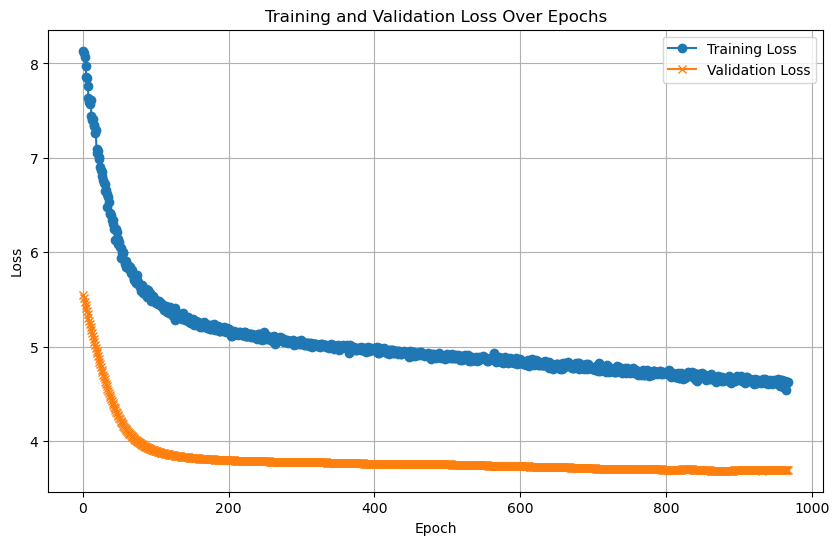

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.2899


Test Batch [20/20], Loss: 4.8078

Test Loss: 4.8613


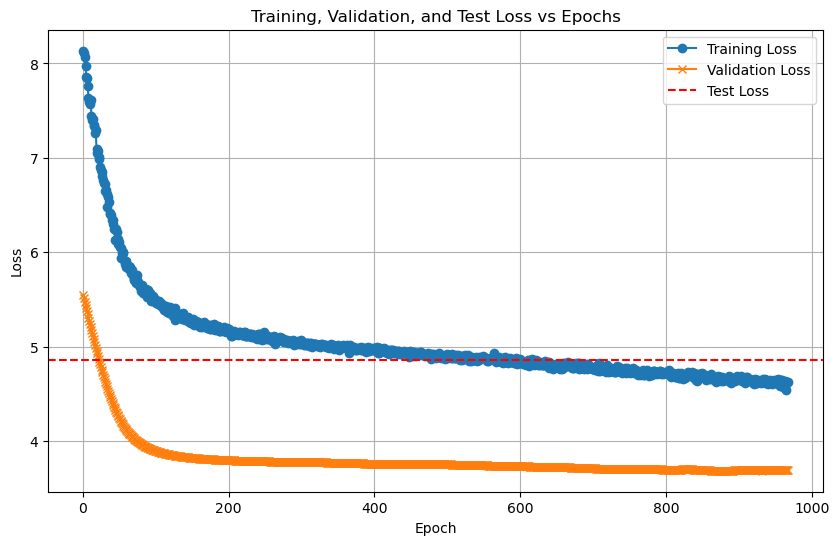

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 44.62%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.00      0.00      0.00         5
           2       0.14      0.20      0.17         5
           3       0.00      0.00      0.00         5
           4       0.40      0.80      0.53         5
           5       1.00      0.60      0.75         5
           6       0.30      0.60      0.40         5
           7       0.44      0.80      0.57         5
           8       0.80      0.80      0.80         5
           9       0.40      0.40      0.40         5
          10       1.00      0.40      0.57         5
          11       0.33      0.20      0.25         5
          12       1.00      0.80      0.89         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6695  |  Val Loss: 2.6109
Validation loss improved from inf to 2.6109.
[Epoch 2/1000] Train Loss: 2.6404  |  Val Loss: 2.5931
Validation loss improved from 2.6109 to 2.5931.
[Epoch 3/1000] Train Loss: 2.6185  |  Val Loss: 2.5767
Validation loss improved from 2.5931 to 2.5767.
[Epoch 4/1000] Train Loss: 2.5963  |  Val Loss: 2.5623
Validation loss improved from 2.5767 to 2.5623.
[Epoch 5/1000] Train Loss: 2.5754  |  Val Loss: 2.5516
Validation loss improved from 2.5623 to 2.5516.
[Epoch 6/1000] Train Loss: 2.5596  |  Val Loss: 2.5444
Validation loss improved from 2.5516 to 2.5444.
[Epoch 7/1000] Train Loss: 2.5452  |  Val Loss: 2.5388
Validation loss improved from 2.5444 to 2.5388.
[Epoch 8/1000] Train Loss: 2.5334  |  Val Loss: 2.5331
Validation loss improved from 2.5388 to 2.5331.
[Epoch 9/1000] Train Loss: 2.5234  |  Val Loss: 2.5269
Validation loss improved from 2.5331 to 2.5269.


[Epoch 10/1000] Train Loss: 2.5135  |  Val Loss: 2.5209
Validation loss improved from 2.5269 to 2.5209.
[Epoch 11/1000] Train Loss: 2.5045  |  Val Loss: 2.5138
Validation loss improved from 2.5209 to 2.5138.
[Epoch 12/1000] Train Loss: 2.4954  |  Val Loss: 2.5091
Validation loss improved from 2.5138 to 2.5091.
[Epoch 13/1000] Train Loss: 2.4882  |  Val Loss: 2.5053
Validation loss improved from 2.5091 to 2.5053.
[Epoch 14/1000] Train Loss: 2.4822  |  Val Loss: 2.5017
Validation loss improved from 2.5053 to 2.5017.
[Epoch 15/1000] Train Loss: 2.4763  |  Val Loss: 2.4982
Validation loss improved from 2.5017 to 2.4982.
[Epoch 16/1000] Train Loss: 2.4707  |  Val Loss: 2.4946
Validation loss improved from 2.4982 to 2.4946.
[Epoch 17/1000] Train Loss: 2.4655  |  Val Loss: 2.4908
Validation loss improved from 2.4946 to 2.4908.


[Epoch 18/1000] Train Loss: 2.4610  |  Val Loss: 2.4881
Validation loss improved from 2.4908 to 2.4881.
[Epoch 19/1000] Train Loss: 2.4566  |  Val Loss: 2.4863
Validation loss improved from 2.4881 to 2.4863.
[Epoch 20/1000] Train Loss: 2.4529  |  Val Loss: 2.4845
Validation loss improved from 2.4863 to 2.4845.


[Epoch 21/1000] Train Loss: 2.4488  |  Val Loss: 2.4822
Validation loss improved from 2.4845 to 2.4822.
[Epoch 22/1000] Train Loss: 2.4450  |  Val Loss: 2.4802
Validation loss improved from 2.4822 to 2.4802.
[Epoch 23/1000] Train Loss: 2.4411  |  Val Loss: 2.4783
Validation loss improved from 2.4802 to 2.4783.
[Epoch 24/1000] Train Loss: 2.4373  |  Val Loss: 2.4770
Validation loss improved from 2.4783 to 2.4770.
[Epoch 25/1000] Train Loss: 2.4346  |  Val Loss: 2.4769
Validation loss improved from 2.4770 to 2.4769.
[Epoch 26/1000] Train Loss: 2.4303  |  Val Loss: 2.4751
Validation loss improved from 2.4769 to 2.4751.
[Epoch 27/1000] Train Loss: 2.4269  |  Val Loss: 2.4734
Validation loss improved from 2.4751 to 2.4734.
[Epoch 28/1000] Train Loss: 2.4234  |  Val Loss: 2.4726
Validation loss improved from 2.4734 to 2.4726.
[Epoch 29/1000] Train Loss: 2.4200  |  Val Loss: 2.4713
Validation loss improved from 2.4726 to 2.4713.


[Epoch 30/1000] Train Loss: 2.4167  |  Val Loss: 2.4693
Validation loss improved from 2.4713 to 2.4693.
[Epoch 31/1000] Train Loss: 2.4131  |  Val Loss: 2.4674
Validation loss improved from 2.4693 to 2.4674.
[Epoch 32/1000] Train Loss: 2.4098  |  Val Loss: 2.4656
Validation loss improved from 2.4674 to 2.4656.
[Epoch 33/1000] Train Loss: 2.4059  |  Val Loss: 2.4638
Validation loss improved from 2.4656 to 2.4638.
[Epoch 34/1000] Train Loss: 2.4025  |  Val Loss: 2.4620
Validation loss improved from 2.4638 to 2.4620.
[Epoch 35/1000] Train Loss: 2.3990  |  Val Loss: 2.4599
Validation loss improved from 2.4620 to 2.4599.
[Epoch 36/1000] Train Loss: 2.3961  |  Val Loss: 2.4581
Validation loss improved from 2.4599 to 2.4581.


[Epoch 37/1000] Train Loss: 2.3926  |  Val Loss: 2.4563
Validation loss improved from 2.4581 to 2.4563.
[Epoch 38/1000] Train Loss: 2.3896  |  Val Loss: 2.4550
Validation loss improved from 2.4563 to 2.4550.
[Epoch 39/1000] Train Loss: 2.3875  |  Val Loss: 2.4557
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 2.3846  |  Val Loss: 2.4554
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 41/1000] Train Loss: 2.3816  |  Val Loss: 2.4545
Validation loss improved from 2.4550 to 2.4545.
[Epoch 42/1000] Train Loss: 2.3781  |  Val Loss: 2.4526
Validation loss improved from 2.4545 to 2.4526.
[Epoch 43/1000] Train Loss: 2.3743  |  Val Loss: 2.4499
Validation loss improved from 2.4526 to 2.4499.
[Epoch 44/1000] Train Loss: 2.3705  |  Val Loss: 2.4476
Validation loss improved from 2.4499 to 2.4476.
[Epoch 45/1000] Train Loss: 2.3678  |  Val Loss: 2.4466
Validation loss improved from 2.4476 to 2.4466.
[Epoch 46/1000] Train Loss: 2.3680  |  Val Loss: 2.4

[Epoch 47/1000] Train Loss: 2.3679  |  Val Loss: 2.4445
Validation loss improved from 2.4459 to 2.4445.
[Epoch 48/1000] Train Loss: 2.3640  |  Val Loss: 2.4423
Validation loss improved from 2.4445 to 2.4423.
[Epoch 49/1000] Train Loss: 2.3590  |  Val Loss: 2.4409
Validation loss improved from 2.4423 to 2.4409.
[Epoch 50/1000] Train Loss: 2.3550  |  Val Loss: 2.4397
Validation loss improved from 2.4409 to 2.4397.
[Epoch 51/1000] Train Loss: 2.3521  |  Val Loss: 2.4384
Validation loss improved from 2.4397 to 2.4384.
[Epoch 52/1000] Train Loss: 2.3492  |  Val Loss: 2.4366
Validation loss improved from 2.4384 to 2.4366.
[Epoch 53/1000] Train Loss: 2.3468  |  Val Loss: 2.4338
Validation loss improved from 2.4366 to 2.4338.
[Epoch 54/1000] Train Loss: 2.3431  |  Val Loss: 2.4315
Validation loss improved from 2.4338 to 2.4315.
[Epoch 55/1000] Train Loss: 2.3390  |  Val Loss: 2.4292
Validation loss improved from 2.4315 to 2.4292.


[Epoch 56/1000] Train Loss: 2.3358  |  Val Loss: 2.4260
Validation loss improved from 2.4292 to 2.4260.
[Epoch 57/1000] Train Loss: 2.3315  |  Val Loss: 2.4245
Validation loss improved from 2.4260 to 2.4245.
[Epoch 58/1000] Train Loss: 2.3282  |  Val Loss: 2.4228
Validation loss improved from 2.4245 to 2.4228.
[Epoch 59/1000] Train Loss: 2.3252  |  Val Loss: 2.4210
Validation loss improved from 2.4228 to 2.4210.
[Epoch 60/1000] Train Loss: 2.3221  |  Val Loss: 2.4189
Validation loss improved from 2.4210 to 2.4189.
[Epoch 61/1000] Train Loss: 2.3190  |  Val Loss: 2.4170
Validation loss improved from 2.4189 to 2.4170.
[Epoch 62/1000] Train Loss: 2.3158  |  Val Loss: 2.4151
Validation loss improved from 2.4170 to 2.4151.
[Epoch 63/1000] Train Loss: 2.3123  |  Val Loss: 2.4133
Validation loss improved from 2.4151 to 2.4133.
[Epoch 64/1000] Train Loss: 2.3095  |  Val Loss: 2.4136
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 2.3062  |  Val Loss: 2.4126
Va

[Epoch 68/1000] Train Loss: 2.2966  |  Val Loss: 2.4080
Validation loss improved from 2.4091 to 2.4080.
[Epoch 69/1000] Train Loss: 2.2928  |  Val Loss: 2.4048
Validation loss improved from 2.4080 to 2.4048.
[Epoch 70/1000] Train Loss: 2.2889  |  Val Loss: 2.4018
Validation loss improved from 2.4048 to 2.4018.
[Epoch 71/1000] Train Loss: 2.2855  |  Val Loss: 2.3995
Validation loss improved from 2.4018 to 2.3995.
[Epoch 72/1000] Train Loss: 2.2815  |  Val Loss: 2.3987
Validation loss improved from 2.3995 to 2.3987.
[Epoch 73/1000] Train Loss: 2.2778  |  Val Loss: 2.3974
Validation loss improved from 2.3987 to 2.3974.
[Epoch 74/1000] Train Loss: 2.2735  |  Val Loss: 2.3948
Validation loss improved from 2.3974 to 2.3948.
[Epoch 75/1000] Train Loss: 2.2699  |  Val Loss: 2.3917
Validation loss improved from 2.3948 to 2.3917.
[Epoch 76/1000] Train Loss: 2.2665  |  Val Loss: 2.3878
Validation loss improved from 2.3917 to 2.3878.
[Epoch 77/1000] Train Loss: 2.2622  |  Val Loss: 2.3839
Validati

[Epoch 78/1000] Train Loss: 2.2579  |  Val Loss: 2.3805
Validation loss improved from 2.3839 to 2.3805.
[Epoch 79/1000] Train Loss: 2.2533  |  Val Loss: 2.3780
Validation loss improved from 2.3805 to 2.3780.
[Epoch 80/1000] Train Loss: 2.2491  |  Val Loss: 2.3760
Validation loss improved from 2.3780 to 2.3760.
[Epoch 81/1000] Train Loss: 2.2448  |  Val Loss: 2.3737
Validation loss improved from 2.3760 to 2.3737.
[Epoch 82/1000] Train Loss: 2.2410  |  Val Loss: 2.3717
Validation loss improved from 2.3737 to 2.3717.
[Epoch 83/1000] Train Loss: 2.2371  |  Val Loss: 2.3695
Validation loss improved from 2.3717 to 2.3695.
[Epoch 84/1000] Train Loss: 2.2323  |  Val Loss: 2.3674
Validation loss improved from 2.3695 to 2.3674.
[Epoch 85/1000] Train Loss: 2.2277  |  Val Loss: 2.3657
Validation loss improved from 2.3674 to 2.3657.
[Epoch 86/1000] Train Loss: 2.2217  |  Val Loss: 2.3633
Validation loss improved from 2.3657 to 2.3633.
[Epoch 87/1000] Train Loss: 2.2169  |  Val Loss: 2.3614
Validati

[Epoch 90/1000] Train Loss: 2.2021  |  Val Loss: 2.3559
Validation loss improved from 2.3581 to 2.3559.
[Epoch 91/1000] Train Loss: 2.1972  |  Val Loss: 2.3524
Validation loss improved from 2.3559 to 2.3524.
[Epoch 92/1000] Train Loss: 2.1924  |  Val Loss: 2.3494
Validation loss improved from 2.3524 to 2.3494.
[Epoch 93/1000] Train Loss: 2.1880  |  Val Loss: 2.3467
Validation loss improved from 2.3494 to 2.3467.
[Epoch 94/1000] Train Loss: 2.1830  |  Val Loss: 2.3433
Validation loss improved from 2.3467 to 2.3433.
[Epoch 95/1000] Train Loss: 2.1779  |  Val Loss: 2.3401
Validation loss improved from 2.3433 to 2.3401.
[Epoch 96/1000] Train Loss: 2.1731  |  Val Loss: 2.3371
Validation loss improved from 2.3401 to 2.3371.


[Epoch 97/1000] Train Loss: 2.1689  |  Val Loss: 2.3339
Validation loss improved from 2.3371 to 2.3339.
[Epoch 98/1000] Train Loss: 2.1641  |  Val Loss: 2.3316
Validation loss improved from 2.3339 to 2.3316.
[Epoch 99/1000] Train Loss: 2.1603  |  Val Loss: 2.3313
Validation loss improved from 2.3316 to 2.3313.
[Epoch 100/1000] Train Loss: 2.1559  |  Val Loss: 2.3292
Validation loss improved from 2.3313 to 2.3292.
[Epoch 101/1000] Train Loss: 2.1515  |  Val Loss: 2.3276
Validation loss improved from 2.3292 to 2.3276.
[Epoch 102/1000] Train Loss: 2.1484  |  Val Loss: 2.3277
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 2.1437  |  Val Loss: 2.3249
Validation loss improved from 2.3276 to 2.3249.
[Epoch 104/1000] Train Loss: 2.1390  |  Val Loss: 2.3214
Validation loss improved from 2.3249 to 2.3214.
[Epoch 105/1000] Train Loss: 2.1344  |  Val Loss: 2.3177
Validation loss improved from 2.3214 to 2.3177.
[Epoch 106/1000] Train Loss: 2.1295  |  Val Loss: 2.

[Epoch 110/1000] Train Loss: 2.1160  |  Val Loss: 2.2999
Validation loss improved from 2.3015 to 2.2999.
[Epoch 111/1000] Train Loss: 2.1094  |  Val Loss: 2.3023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 112/1000] Train Loss: 2.1059  |  Val Loss: 2.3029
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 113/1000] Train Loss: 2.1002  |  Val Loss: 2.2990
Validation loss improved from 2.2999 to 2.2990.
[Epoch 114/1000] Train Loss: 2.0945  |  Val Loss: 2.2942
Validation loss improved from 2.2990 to 2.2942.
[Epoch 115/1000] Train Loss: 2.0889  |  Val Loss: 2.2899
Validation loss improved from 2.2942 to 2.2899.
[Epoch 116/1000] Train Loss: 2.0841  |  Val Loss: 2.2866
Validation loss improved from 2.2899 to 2.2866.
[Epoch 117/1000] Train Loss: 2.0793  |  Val Loss: 2.2836
Validation loss improved from 2.2866 to 2.2836.
[Epoch 118/1000] Train Loss: 2.0744  |  Val Loss: 2.2804
Validation loss improved from 2.2836 to 2.2804.


[Epoch 119/1000] Train Loss: 2.0696  |  Val Loss: 2.2775
Validation loss improved from 2.2804 to 2.2775.
[Epoch 120/1000] Train Loss: 2.0650  |  Val Loss: 2.2744
Validation loss improved from 2.2775 to 2.2744.
[Epoch 121/1000] Train Loss: 2.0604  |  Val Loss: 2.2720
Validation loss improved from 2.2744 to 2.2720.
[Epoch 122/1000] Train Loss: 2.0553  |  Val Loss: 2.2704
Validation loss improved from 2.2720 to 2.2704.
[Epoch 123/1000] Train Loss: 2.0509  |  Val Loss: 2.2678
Validation loss improved from 2.2704 to 2.2678.
[Epoch 124/1000] Train Loss: 2.0457  |  Val Loss: 2.2669
Validation loss improved from 2.2678 to 2.2669.
[Epoch 125/1000] Train Loss: 2.0408  |  Val Loss: 2.2663
Validation loss improved from 2.2669 to 2.2663.
[Epoch 126/1000] Train Loss: 2.0370  |  Val Loss: 2.2636
Validation loss improved from 2.2663 to 2.2636.
[Epoch 127/1000] Train Loss: 2.0327  |  Val Loss: 2.2603
Validation loss improved from 2.2636 to 2.2603.


[Epoch 128/1000] Train Loss: 2.0275  |  Val Loss: 2.2572
Validation loss improved from 2.2603 to 2.2572.
[Epoch 129/1000] Train Loss: 2.0228  |  Val Loss: 2.2534
Validation loss improved from 2.2572 to 2.2534.
[Epoch 130/1000] Train Loss: 2.0164  |  Val Loss: 2.2544
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 2.0122  |  Val Loss: 2.2512
Validation loss improved from 2.2534 to 2.2512.
[Epoch 132/1000] Train Loss: 2.0073  |  Val Loss: 2.2409
Validation loss improved from 2.2512 to 2.2409.
[Epoch 133/1000] Train Loss: 2.0025  |  Val Loss: 2.2358
Validation loss improved from 2.2409 to 2.2358.
[Epoch 134/1000] Train Loss: 1.9972  |  Val Loss: 2.2334
Validation loss improved from 2.2358 to 2.2334.
[Epoch 135/1000] Train Loss: 1.9915  |  Val Loss: 2.2310
Validation loss improved from 2.2334 to 2.2310.
[Epoch 136/1000] Train Loss: 1.9850  |  Val Loss: 2.2301
Validation loss improved from 2.2310 to 2.2301.
[Epoch 137/1000] Train Loss: 1.9785  |  Val Loss:

[Epoch 139/1000] Train Loss: 1.9722  |  Val Loss: 2.2354
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 140/1000] Train Loss: 1.9680  |  Val Loss: 2.2290
Validation loss improved from 2.2301 to 2.2290.
[Epoch 141/1000] Train Loss: 1.9628  |  Val Loss: 2.2236
Validation loss improved from 2.2290 to 2.2236.
[Epoch 142/1000] Train Loss: 1.9560  |  Val Loss: 2.2169
Validation loss improved from 2.2236 to 2.2169.
[Epoch 143/1000] Train Loss: 1.9514  |  Val Loss: 2.2119
Validation loss improved from 2.2169 to 2.2119.


[Epoch 144/1000] Train Loss: 1.9447  |  Val Loss: 2.2073
Validation loss improved from 2.2119 to 2.2073.
[Epoch 145/1000] Train Loss: 1.9381  |  Val Loss: 2.2045
Validation loss improved from 2.2073 to 2.2045.
[Epoch 146/1000] Train Loss: 1.9329  |  Val Loss: 2.2050
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 1.9293  |  Val Loss: 2.2036
Validation loss improved from 2.2045 to 2.2036.
[Epoch 148/1000] Train Loss: 1.9244  |  Val Loss: 2.2013
Validation loss improved from 2.2036 to 2.2013.
[Epoch 149/1000] Train Loss: 1.9191  |  Val Loss: 2.1933
Validation loss improved from 2.2013 to 2.1933.
[Epoch 150/1000] Train Loss: 1.9152  |  Val Loss: 2.1879
Validation loss improved from 2.1933 to 2.1879.
[Epoch 151/1000] Train Loss: 1.9103  |  Val Loss: 2.1837
Validation loss improved from 2.1879 to 2.1837.
[Epoch 152/1000] Train Loss: 1.9030  |  Val Loss: 2.1837
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 153/1000] Train Loss: 1.8984  |  Val

[Epoch 159/1000] Train Loss: 1.8681  |  Val Loss: 2.1700
Validation loss improved from 2.1754 to 2.1700.
[Epoch 160/1000] Train Loss: 1.8631  |  Val Loss: 2.1645
Validation loss improved from 2.1700 to 2.1645.
[Epoch 161/1000] Train Loss: 1.8576  |  Val Loss: 2.1599
Validation loss improved from 2.1645 to 2.1599.
[Epoch 162/1000] Train Loss: 1.8520  |  Val Loss: 2.1547
Validation loss improved from 2.1599 to 2.1547.
[Epoch 163/1000] Train Loss: 1.8479  |  Val Loss: 2.1522
Validation loss improved from 2.1547 to 2.1522.


[Epoch 164/1000] Train Loss: 1.8426  |  Val Loss: 2.1507
Validation loss improved from 2.1522 to 2.1507.
[Epoch 165/1000] Train Loss: 1.8369  |  Val Loss: 2.1513
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 166/1000] Train Loss: 1.8318  |  Val Loss: 2.1506
Validation loss improved from 2.1507 to 2.1506.
[Epoch 167/1000] Train Loss: 1.8263  |  Val Loss: 2.1481
Validation loss improved from 2.1506 to 2.1481.
[Epoch 168/1000] Train Loss: 1.8217  |  Val Loss: 2.1458
Validation loss improved from 2.1481 to 2.1458.
[Epoch 169/1000] Train Loss: 1.8164  |  Val Loss: 2.1400
Validation loss improved from 2.1458 to 2.1400.
[Epoch 170/1000] Train Loss: 1.8114  |  Val Loss: 2.1336
Validation loss improved from 2.1400 to 2.1336.
[Epoch 171/1000] Train Loss: 1.8070  |  Val Loss: 2.1314
Validation loss improved from 2.1336 to 2.1314.
[Epoch 172/1000] Train Loss: 1.8024  |  Val Loss: 2.1325
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 1.7974  |  Val

[Epoch 179/1000] Train Loss: 1.7673  |  Val Loss: 2.1239
Validation loss improved from 2.1265 to 2.1239.
[Epoch 180/1000] Train Loss: 1.7638  |  Val Loss: 2.1250
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 1.7572  |  Val Loss: 2.1224
Validation loss improved from 2.1239 to 2.1224.
[Epoch 182/1000] Train Loss: 1.7521  |  Val Loss: 2.1237
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 183/1000] Train Loss: 1.7482  |  Val Loss: 2.1212
Validation loss improved from 2.1224 to 2.1212.


[Epoch 184/1000] Train Loss: 1.7427  |  Val Loss: 2.1139
Validation loss improved from 2.1212 to 2.1139.
[Epoch 185/1000] Train Loss: 1.7365  |  Val Loss: 2.1067
Validation loss improved from 2.1139 to 2.1067.
[Epoch 186/1000] Train Loss: 1.7310  |  Val Loss: 2.1034
Validation loss improved from 2.1067 to 2.1034.
[Epoch 187/1000] Train Loss: 1.7255  |  Val Loss: 2.1066
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 1.7228  |  Val Loss: 2.1052
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 1.7186  |  Val Loss: 2.1007
Validation loss improved from 2.1034 to 2.1007.
[Epoch 190/1000] Train Loss: 1.7126  |  Val Loss: 2.0959
Validation loss improved from 2.1007 to 2.0959.
[Epoch 191/1000] Train Loss: 1.7069  |  Val Loss: 2.0943
Validation loss improved from 2.0959 to 2.0943.
[Epoch 192/1000] Train Loss: 1.7020  |  Val Loss: 2.0862
Validation loss improved from 2.0943 to 2.0862.
[Epoch 193/1000] Train Loss: 1.6963  |  Val

[Epoch 197/1000] Train Loss: 1.6794  |  Val Loss: 2.0785
Validation loss improved from 2.0805 to 2.0785.
[Epoch 198/1000] Train Loss: 1.6748  |  Val Loss: 2.0749
Validation loss improved from 2.0785 to 2.0749.
[Epoch 199/1000] Train Loss: 1.6685  |  Val Loss: 2.0733
Validation loss improved from 2.0749 to 2.0733.
[Epoch 200/1000] Train Loss: 1.6633  |  Val Loss: 2.0809
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 1.6655  |  Val Loss: 2.0947
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 1.6616  |  Val Loss: 2.0894
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 1.6540  |  Val Loss: 2.0727
Validation loss improved from 2.0733 to 2.0727.


[Epoch 204/1000] Train Loss: 1.6459  |  Val Loss: 2.0610
Validation loss improved from 2.0727 to 2.0610.
[Epoch 205/1000] Train Loss: 1.6399  |  Val Loss: 2.0550
Validation loss improved from 2.0610 to 2.0550.
[Epoch 206/1000] Train Loss: 1.6356  |  Val Loss: 2.0525
Validation loss improved from 2.0550 to 2.0525.
[Epoch 207/1000] Train Loss: 1.6303  |  Val Loss: 2.0546
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 1.6252  |  Val Loss: 2.0614
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 1.6216  |  Val Loss: 2.0652
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 210/1000] Train Loss: 1.6174  |  Val Loss: 2.0654
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 211/1000] Train Loss: 1.6126  |  Val Loss: 2.0587
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 212/1000] Train Loss: 1.6071  |  Val Loss: 2.0533
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 213/1000] Tr

[Epoch 214/1000] Train Loss: 1.5990  |  Val Loss: 2.0505
Validation loss improved from 2.0519 to 2.0505.
[Epoch 215/1000] Train Loss: 1.5923  |  Val Loss: 2.0385
Validation loss improved from 2.0505 to 2.0385.
[Epoch 216/1000] Train Loss: 1.5964  |  Val Loss: 2.0490
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 217/1000] Train Loss: 1.6006  |  Val Loss: 2.0512
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 218/1000] Train Loss: 1.5948  |  Val Loss: 2.0473
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 219/1000] Train Loss: 1.5794  |  Val Loss: 2.0359
Validation loss improved from 2.0385 to 2.0359.
[Epoch 220/1000] Train Loss: 1.5747  |  Val Loss: 2.0375
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 1.5754  |  Val Loss: 2.0326
Validation loss improved from 2.0359 to 2.0326.


[Epoch 222/1000] Train Loss: 1.5691  |  Val Loss: 2.0319
Validation loss improved from 2.0326 to 2.0319.
[Epoch 223/1000] Train Loss: 1.5638  |  Val Loss: 2.0556
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 224/1000] Train Loss: 1.5641  |  Val Loss: 2.0692
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 225/1000] Train Loss: 1.5629  |  Val Loss: 2.0630
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 226/1000] Train Loss: 1.5552  |  Val Loss: 2.0501
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 227/1000] Train Loss: 1.5460  |  Val Loss: 2.0404
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 228/1000] Train Loss: 1.5383  |  Val Loss: 2.0433
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 229/1000] Train Loss: 1.5379  |  Val Loss: 2.0438
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 230/1000] Train Loss: 1.5388  |  Val Loss: 2.0428
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 234/1000] Train Loss: 1.5192  |  Val Loss: 2.0279
Validation loss improved from 2.0319 to 2.0279.
[Epoch 235/1000] Train Loss: 1.5122  |  Val Loss: 2.0190
Validation loss improved from 2.0279 to 2.0190.
[Epoch 236/1000] Train Loss: 1.5057  |  Val Loss: 2.0116
Validation loss improved from 2.0190 to 2.0116.
[Epoch 237/1000] Train Loss: 1.5013  |  Val Loss: 2.0099
Validation loss improved from 2.0116 to 2.0099.
[Epoch 238/1000] Train Loss: 1.4991  |  Val Loss: 2.0114
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 239/1000] Train Loss: 1.4949  |  Val Loss: 2.0138
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 240/1000] Train Loss: 1.4912  |  Val Loss: 2.0099
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 241/1000] Train Loss: 1.4924  |  Val Loss: 1.9992
Validation loss improved from 2.0099 to 1.9992.
[Epoch 242/1000] Train Loss: 1.5000  |  Val Loss: 2.0011
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 243/1000] Train Loss: 1.4997  |  Val Loss: 1.9984
Validation loss improved from 1.9992 to 1.9984.
[Epoch 244/1000] Train Loss: 1.4792  |  Val Loss: 2.0101
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 245/1000] Train Loss: 1.4733  |  Val Loss: 2.0262
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 246/1000] Train Loss: 1.4802  |  Val Loss: 2.0345
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 247/1000] Train Loss: 1.4799  |  Val Loss: 2.0346
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 248/1000] Train Loss: 1.4735  |  Val Loss: 2.0267
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 249/10

[Epoch 257/1000] Train Loss: 1.4313  |  Val Loss: 1.9944
Validation loss improved from 1.9958 to 1.9944.
[Epoch 258/1000] Train Loss: 1.4277  |  Val Loss: 1.9942
Validation loss improved from 1.9944 to 1.9942.
[Epoch 259/1000] Train Loss: 1.4243  |  Val Loss: 1.9955
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 1.4208  |  Val Loss: 1.9979
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.4176  |  Val Loss: 1.9924
Validation loss improved from 1.9942 to 1.9924.


[Epoch 262/1000] Train Loss: 1.4154  |  Val Loss: 1.9903
Validation loss improved from 1.9924 to 1.9903.
[Epoch 263/1000] Train Loss: 1.4134  |  Val Loss: 1.9911
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 1.4103  |  Val Loss: 1.9942
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 1.4078  |  Val Loss: 2.0100
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 1.4100  |  Val Loss: 2.0203
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 267/1000] Train Loss: 1.4061  |  Val Loss: 2.0151
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 268/1000] Train Loss: 1.3991  |  Val Loss: 2.0088
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 269/1000] Train Loss: 1.3940  |  Val Loss: 2.0022
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 270/1000] Train Loss: 1.3890  |  Val Loss: 1.9944
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 277/1000] Train Loss: 1.3684  |  Val Loss: 1.9854
Validation loss improved from 1.9880 to 1.9854.
[Epoch 278/1000] Train Loss: 1.3665  |  Val Loss: 1.9850
Validation loss improved from 1.9854 to 1.9850.
[Epoch 279/1000] Train Loss: 1.3624  |  Val Loss: 1.9893
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 280/1000] Train Loss: 1.3588  |  Val Loss: 1.9894
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 281/1000] Train Loss: 1.3555  |  Val Loss: 1.9861
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 282/1000] Train Loss: 1.3539  |  Val Loss: 1.9862
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 283/1000] Train Loss: 1.3513  |  Val Loss: 1.9889
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 284/1000] Train Loss: 1.3479  |  Val Loss: 1.9988
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 285/1000] Train Loss: 1.3480  |  Val Loss: 2.0004
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 286/1000] Train Loss: 1.3462  |  Val Loss: 1.9964
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 287/1000] Train Loss: 1.3412  |  Val Loss: 1.9924
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 288/1000] Train Loss: 1.3359  |  Val Loss: 1.9882
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 289/1000] Train Loss: 1.3326  |  Val Loss: 1.9851
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 290/1000] Train Loss: 1.3298  |  Val Loss: 1.9836
Validation loss improved from 1.9850 to 1.9836.
[Epoc

[Epoch 295/1000] Train Loss: 1.3158  |  Val Loss: 1.9934
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 296/1000] Train Loss: 1.3137  |  Val Loss: 1.9972
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 297/1000] Train Loss: 1.3107  |  Val Loss: 1.9992
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 298/1000] Train Loss: 1.3084  |  Val Loss: 2.0002
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 299/1000] Train Loss: 1.3072  |  Val Loss: 1.9919
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 300/1000] Train Loss: 1.3040  |  Val Loss: 1.9870
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 301/1000] Train Loss: 1.3031  |  Val Loss: 1.9857
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 302/1000] Train Loss: 1.2989  |  Val Loss: 1.9937
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 303/1000] Train Loss: 1.2969  |  Val Loss: 1.9973
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 304/1000] Train Loss: 1.2950  |  Val Loss: 1.9983
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 305/1000] Train Loss: 1.2929  |  Val Loss: 2.0053
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 306/1000] Train Loss: 1.2905  |  Val Loss: 2.0039
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 307/1000] Train Loss: 1.2877  |  Val Loss: 1.9978
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 308/1000] Train Loss: 1.2877  |  Val Loss: 1.9934
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 309/1000] Train Loss: 1.2873  |  Val Loss: 1.9881
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 310/1000] Train Loss: 1.2868  |  Val Loss: 1.9846
!! Validation loss did NOT improve !! Patience:

[Epoch 313/1000] Train Loss: 1.2752  |  Val Loss: 1.9919
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 314/1000] Train Loss: 1.2759  |  Val Loss: 1.9971
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 315/1000] Train Loss: 1.2808  |  Val Loss: 1.9958
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 316/1000] Train Loss: 1.2717  |  Val Loss: 1.9949
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 317/1000] Train Loss: 1.2641  |  Val Loss: 1.9979
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 318/1000] Train Loss: 1.2627  |  Val Loss: 2.0020
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 319/1000] Train Loss: 1.2618  |  Val Loss: 2.0117
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 320/1000] Train Loss: 1.2632  |  Val Loss: 2.0164
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 321/1000] Train Loss: 1.2621  |  Val Loss: 2.0056
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 322/1000] Train Loss: 1.2569  |  Val Loss: 1.9832
Validation loss improved from 1.9836 to 1.9832.
[Epoch 323/1000] Train Loss: 1.2622  |  Val Loss: 1.9814
Validation loss improved from 1.9832 to 1.9814.
[Epoch 324/1000] Train Loss: 1.2578  |  Val Loss: 1.9875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 325/1000] Train Loss: 1.2487  |  Val Loss: 1.9985
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 326/1000] Train Loss: 1.2485  |  Val Loss: 2.0067
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 327/1000] Train Loss: 1.2480  |  Val Loss: 2.0121
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 328

[Epoch 333/1000] Train Loss: 1.2313  |  Val Loss: 1.9990
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 334/1000] Train Loss: 1.2321  |  Val Loss: 1.9985
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 335/1000] Train Loss: 1.2306  |  Val Loss: 1.9997
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 336/1000] Train Loss: 1.2275  |  Val Loss: 2.0036
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 337/1000] Train Loss: 1.2243  |  Val Loss: 2.0087
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 338/1000] Train Loss: 1.2240  |  Val Loss: 2.0185
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 339/1000] Train Loss: 1.2221  |  Val Loss: 2.0258
!! Validation loss did NOT improve !! Patience: 16/100


[Epoch 340/1000] Train Loss: 1.2209  |  Val Loss: 2.0247
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 341/1000] Train Loss: 1.2177  |  Val Loss: 2.0173
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 342/1000] Train Loss: 1.2152  |  Val Loss: 2.0101
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 343/1000] Train Loss: 1.2132  |  Val Loss: 2.0034
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 344/1000] Train Loss: 1.2101  |  Val Loss: 2.0131
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 345/1000] Train Loss: 1.2119  |  Val Loss: 2.0156
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 346/1000] Train Loss: 1.2058  |  Val Loss: 2.0052
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 347/1000] Train Loss: 1.2080  |  Val Loss: 2.0086
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 348/1000] Train Loss: 1.2113  |  Val Loss: 2.0088
!! Validation loss did NOT improve !! Patience:

[Epoch 354/1000] Train Loss: 1.1965  |  Val Loss: 2.0259
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 355/1000] Train Loss: 1.1926  |  Val Loss: 2.0226
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 356/1000] Train Loss: 1.1912  |  Val Loss: 2.0204
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 357/1000] Train Loss: 1.1891  |  Val Loss: 2.0155
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 358/1000] Train Loss: 1.1874  |  Val Loss: 2.0128
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 359/1000] Train Loss: 1.1928  |  Val Loss: 2.0216
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 360/1000] Train Loss: 1.2025  |  Val Loss: 2.0271
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 361/1000] Train Loss: 1.1978  |  Val Loss: 2.0204
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 362/1000] Train Loss: 1.1838  |  Val Loss: 2.0182
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 363/1000] Train Loss: 1.1764  |  Val Loss: 2.0255
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 364/1000] Train Loss: 1.1806  |  Val Loss: 2.0435
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 365/1000] Train Loss: 1.1843  |  Val Loss: 2.0480
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 366/1000] Train Loss: 1.1807  |  Val Loss: 2.0387
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 367/1000] Train Loss: 1.1750  |  Val Loss: 2.0329
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 368/1000] Train Loss: 1.1701  |  Val Loss: 2.0253
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 369/1000] Train Loss: 1.1670  |  Val Loss: 2.0154
!! Validation loss did NOT improve !! Patience:

[Epoch 372/1000] Train Loss: 1.1649  |  Val Loss: 2.0148
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 373/1000] Train Loss: 1.1611  |  Val Loss: 2.0196
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 374/1000] Train Loss: 1.1591  |  Val Loss: 2.0304
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 375/1000] Train Loss: 1.1573  |  Val Loss: 2.0399
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 376/1000] Train Loss: 1.1570  |  Val Loss: 2.0440
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 377/1000] Train Loss: 1.1550  |  Val Loss: 2.0420
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 378/1000] Train Loss: 1.1528  |  Val Loss: 2.0404
!! Validation loss did NOT improve !! Patience: 55/100


[Epoch 379/1000] Train Loss: 1.1509  |  Val Loss: 2.0397
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 380/1000] Train Loss: 1.1498  |  Val Loss: 2.0421
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 381/1000] Train Loss: 1.1490  |  Val Loss: 2.0420
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 382/1000] Train Loss: 1.1470  |  Val Loss: 2.0423
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 383/1000] Train Loss: 1.1451  |  Val Loss: 2.0444
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 384/1000] Train Loss: 1.1432  |  Val Loss: 2.0502
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 385/1000] Train Loss: 1.1428  |  Val Loss: 2.0555
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 386/1000] Train Loss: 1.1421  |  Val Loss: 2.0553
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 387/1000] Train Loss: 1.1399  |  Val Loss: 2.0510
!! Validation loss did NOT improve !! Patience:

[Epoch 391/1000] Train Loss: 1.1330  |  Val Loss: 2.0450
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 392/1000] Train Loss: 1.1323  |  Val Loss: 2.0476
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 393/1000] Train Loss: 1.1309  |  Val Loss: 2.0567
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 394/1000] Train Loss: 1.1354  |  Val Loss: 2.0607
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 395/1000] Train Loss: 1.1341  |  Val Loss: 2.0570
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 396/1000] Train Loss: 1.1304  |  Val Loss: 2.0564
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 397/1000] Train Loss: 1.1279  |  Val Loss: 2.0565
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 398/1000] Train Loss: 1.1238  |  Val Loss: 2.0550
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 399/1000] Train Loss: 1.1227  |  Val Loss: 2.0550
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 400/1000] Train Loss: 1.1226  |  Val Loss: 2.0591
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 401/1000] Train Loss: 1.1225  |  Val Loss: 2.0634
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 402/1000] Train Loss: 1.1219  |  Val Loss: 2.0679
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 403/1000] Train Loss: 1.1204  |  Val Loss: 2.0663
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 404/1000] Train Loss: 1.1168  |  Val Loss: 2.0632
!! Validation loss did NOT improve !! Patience:

[Epoch 407/1000] Train Loss: 1.1108  |  Val Loss: 2.0590
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 408/1000] Train Loss: 1.1144  |  Val Loss: 2.0662
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 409/1000] Train Loss: 1.1225  |  Val Loss: 2.0703
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 410/1000] Train Loss: 1.1165  |  Val Loss: 2.0660
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 411/1000] Train Loss: 1.1077  |  Val Loss: 2.0679
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 412/1000] Train Loss: 1.1049  |  Val Loss: 2.0689
!! Validation loss did NOT improve !! Patience: 89/100


[Epoch 413/1000] Train Loss: 1.1046  |  Val Loss: 2.0706
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 414/1000] Train Loss: 1.1045  |  Val Loss: 2.0690
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 415/1000] Train Loss: 1.1010  |  Val Loss: 2.0647
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 416/1000] Train Loss: 1.0991  |  Val Loss: 2.0656
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 417/1000] Train Loss: 1.0986  |  Val Loss: 2.0673
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 418/1000] Train Loss: 1.0975  |  Val Loss: 2.0669
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 419/1000] Train Loss: 1.0970  |  Val Loss: 2.0640
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 420/1000] Train Loss: 1.0998  |  Val Loss: 2.0618
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 421/1000] Train Loss: 1.0974  |  Val Loss: 2.0624
!! Validation loss did NOT improve !! Patience:

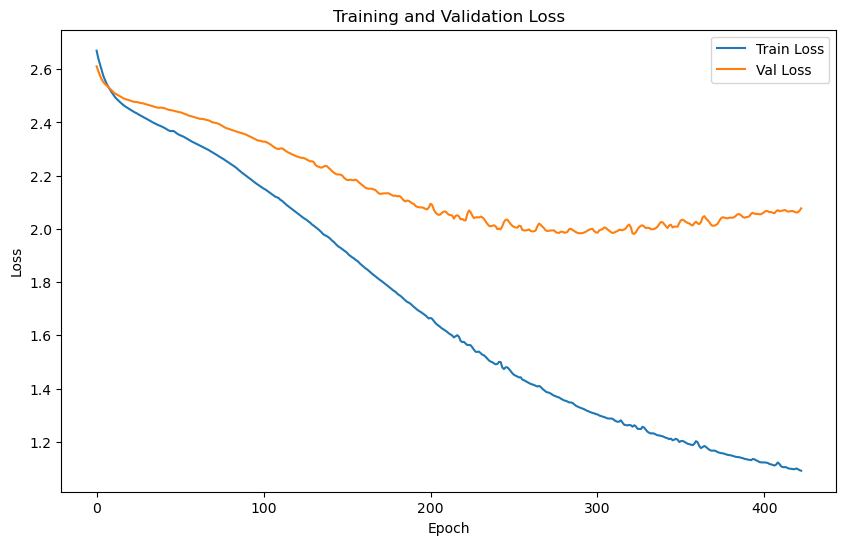

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.7843 | Test Accuracy: 50.06%


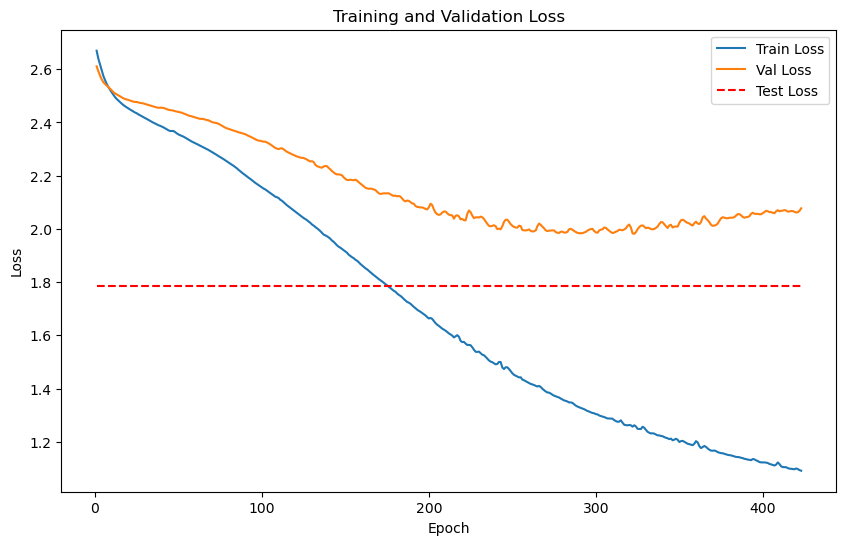

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 260 samples with 64 features each
LOG: Labels shape: (260,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4886 samples with 64 features each
LOG: Labels shape: (4886,)


Train embeddings shape: (260, 64), 
Train labels shape: (260,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4886, 64), 
Test labels shape: (4886,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5362
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6365
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5362, Avg Val Loss: 0.5682

Validation loss improved from inf to 0.5682. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5330
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6348
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5330, Avg Val Loss: 0.5674

Validation loss improved from 0.5682 to 0.5674. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5348
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6339
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5348, Avg Val Loss: 0.5670

Validation loss improved from 0.5674 to 0.5670. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5313
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6333
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5313, Avg Val Loss: 0.5666

Validation loss improved from 0.5670 to 0.5666. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5312
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6325
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5312, Avg Val Loss: 0.5663

Validation loss improved from 0.5666 to 0.5663. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.5310
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6314
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5310, Avg Val Loss: 0.5657

Validation loss improved from 0.5663 to 0.5657. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5302
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.6302
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5302, Avg Val Loss: 0.5651

Validation loss improved from 0.5657 to 0.5651. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.5289
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.6298
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5289, Avg Val Loss: 0.5649

Validation loss improved from 0.5651 to 0.5649. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5281
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.6284
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5281, Avg Val Loss: 0.5642

Validation loss improved from 0.5649 to 0.5642. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5261
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.6267
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5261, Avg Val Loss: 0.5634

Validation loss improved from 0.5642 to 0.5634. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.5261
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.6255
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5261, Avg Val Loss: 0.5627

Validation loss improved from 0.5634 to 0.5627. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5268
LOG: Epoch [12/2000] - Validation


    Batch [1/2], Val Loss: 0.6234
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5268, Avg Val Loss: 0.5617

Validation loss improved from 0.5627 to 0.5617. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5271
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.6216
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5271, Avg Val Loss: 0.5608

Validation loss improved from 0.5617 to 0.5608. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.5229
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.6196
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5229, Avg Val Loss: 0.5598

Validation loss improved from 0.5608 to 0.5598. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5231
LOG: Epoch [15/2000] - Validation


    Batch [1/2], Val Loss: 0.6176
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5231, Avg Val Loss: 0.5588

Validation loss improved from 0.5598 to 0.5588. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5199
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.6153
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5199, Avg Val Loss: 0.5577

Validation loss improved from 0.5588 to 0.5577. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.5214
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.6125
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5214, Avg Val Loss: 0.5563

Validation loss improved from 0.5577 to 0.5563. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5197
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.6094
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5197, Avg Val Loss: 0.5547

Validation loss improved from 0.5563 to 0.5547. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5207
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.6063
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5207, Avg Val Loss: 0.5532

Validation loss improved from 0.5547 to 0.5532. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5201
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.6036
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5201, Avg Val Loss: 0.5518

Validation loss improved from 0.5532 to 0.5518. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5159
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.6005
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5159, Avg Val Loss: 0.5503

Validation loss improved from 0.5518 to 0.5503. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5158
LOG: Epoch [22/2000] - Validation


    Batch [1/2], Val Loss: 0.5978
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5158, Avg Val Loss: 0.5489

Validation loss improved from 0.5503 to 0.5489. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 0.5173
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5949
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5173, Avg Val Loss: 0.5474

Validation loss improved from 0.5489 to 0.5474. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5156
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5918
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5156, Avg Val Loss: 0.5459

Validation loss improved from 0.5474 to 0.5459. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5184
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5888
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5444

Validation loss improved from 0.5459 to 0.5444. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5859
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5429

Validation loss improved from 0.5444 to 0.5429. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5150
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5835
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5150, Avg Val Loss: 0.5417

Validation loss improved from 0.5429 to 0.5417. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5143
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.5814
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5143, Avg Val Loss: 0.5407

Validation loss improved from 0.5417 to 0.5407. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.5157
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5793
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5157, Avg Val Loss: 0.5397

Validation loss improved from 0.5407 to 0.5397. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5128
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5779
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5128, Avg Val Loss: 0.5389

Validation loss improved from 0.5397 to 0.5389. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5148
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5766
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5148, Avg Val Loss: 0.5383

Validation loss improved from 0.5389 to 0.5383. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5152
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5752
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5152, Avg Val Loss: 0.5376

Validation loss improved from 0.5383 to 0.5376. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5135
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5736
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5135, Avg Val Loss: 0.5368

Validation loss improved from 0.5376 to 0.5368. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.5138
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5721
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5138, Avg Val Loss: 0.5361

Validation loss improved from 0.5368 to 0.5361. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5115
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5707
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5115, Avg Val Loss: 0.5353

Validation loss improved from 0.5361 to 0.5353. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.5116
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5693
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5116, Avg Val Loss: 0.5346

Validation loss improved from 0.5353 to 0.5346. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5087
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.5678
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5087, Avg Val Loss: 0.5339

Validation loss improved from 0.5346 to 0.5339. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5104
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5666
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.5333

Validation loss improved from 0.5339 to 0.5333. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5654
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5327

Validation loss improved from 0.5333 to 0.5327. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.5111
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5643
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5111, Avg Val Loss: 0.5321

Validation loss improved from 0.5327 to 0.5321. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.5073
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5633
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5073, Avg Val Loss: 0.5316

Validation loss improved from 0.5321 to 0.5316. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5623
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5311

Validation loss improved from 0.5316 to 0.5311. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5094
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.5613
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5094, Avg Val Loss: 0.5307

Validation loss improved from 0.5311 to 0.5307. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5604
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5302

Validation loss improved from 0.5307 to 0.5302. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.5087
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5595
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5087, Avg Val Loss: 0.5297

Validation loss improved from 0.5302 to 0.5297. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5081
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5586
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.5293

Validation loss improved from 0.5297 to 0.5293. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5086
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5577
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5086, Avg Val Loss: 0.5288

Validation loss improved from 0.5293 to 0.5288. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5078
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5567
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5284

Validation loss improved from 0.5288 to 0.5284. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5067
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5557
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5067, Avg Val Loss: 0.5279

Validation loss improved from 0.5284 to 0.5279. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5548
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5274

Validation loss improved from 0.5279 to 0.5274. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5540
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5270

Validation loss improved from 0.5274 to 0.5270. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5531
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5265

Validation loss improved from 0.5270 to 0.5265. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.5075
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5521
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5075, Avg Val Loss: 0.5261

Validation loss improved from 0.5265 to 0.5261. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5512
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5256

Validation loss improved from 0.5261 to 0.5256. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.5502
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5251

Validation loss improved from 0.5256 to 0.5251. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5074
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5492
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5074, Avg Val Loss: 0.5246

Validation loss improved from 0.5251 to 0.5246. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.5054
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5483
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5054, Avg Val Loss: 0.5241

Validation loss improved from 0.5246 to 0.5241. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.5474
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5237

Validation loss improved from 0.5241 to 0.5237. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.5054
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5465
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5054, Avg Val Loss: 0.5233

Validation loss improved from 0.5237 to 0.5233. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5457
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5228

Validation loss improved from 0.5233 to 0.5228. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5449
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5225

Validation loss improved from 0.5228 to 0.5225. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5043
LOG: Epoch [62/2000] - Validation


    Batch [1/2], Val Loss: 0.5441
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5043, Avg Val Loss: 0.5221

Validation loss improved from 0.5225 to 0.5221. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.5056
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5434
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5056, Avg Val Loss: 0.5217

Validation loss improved from 0.5221 to 0.5217. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5427
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5213

Validation loss improved from 0.5217 to 0.5213. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5420
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.5210

Validation loss improved from 0.5213 to 0.5210. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.5413
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5207

Validation loss improved from 0.5210 to 0.5207. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5407
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5204

Validation loss improved from 0.5207 to 0.5204. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5402
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5201

Validation loss improved from 0.5204 to 0.5201. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.5020
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.5398
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.5199

Validation loss improved from 0.5201 to 0.5199. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5393
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5196

Validation loss improved from 0.5199 to 0.5196. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5027
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5388
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.5194

Validation loss improved from 0.5196 to 0.5194. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.5018
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5384
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5192

Validation loss improved from 0.5194 to 0.5192. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.5380
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5190

Validation loss improved from 0.5192 to 0.5190. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5188

Validation loss improved from 0.5190 to 0.5188. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5372
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5186

Validation loss improved from 0.5188 to 0.5186. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5369
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5184

Validation loss improved from 0.5186 to 0.5184. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5032
LOG: Epoch [77/2000] - Validation


    Batch [1/2], Val Loss: 0.5365
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5032, Avg Val Loss: 0.5183

Validation loss improved from 0.5184 to 0.5183. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5362
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.5181

Validation loss improved from 0.5183 to 0.5181. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5022
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5358
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5022, Avg Val Loss: 0.5179

Validation loss improved from 0.5181 to 0.5179. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.5005
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5355
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5178

Validation loss improved from 0.5179 to 0.5178. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5353
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5176

Validation loss improved from 0.5178 to 0.5176. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5350
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5175

Validation loss improved from 0.5176 to 0.5175. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.5012
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5347
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5173

Validation loss improved from 0.5175 to 0.5173. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.5019
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5019, Avg Val Loss: 0.5172

Validation loss improved from 0.5173 to 0.5172. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5340
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5170

Validation loss improved from 0.5172 to 0.5170. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5337
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5169

Validation loss improved from 0.5170 to 0.5169. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5334
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.5167

Validation loss improved from 0.5169 to 0.5167. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.5331
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5165

Validation loss improved from 0.5167 to 0.5165. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5328
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5164

Validation loss improved from 0.5165 to 0.5164. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4997
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5325
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5162

Validation loss improved from 0.5164 to 0.5162. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.5322
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.5161

Validation loss improved from 0.5162 to 0.5161. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4992
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5319
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4992, Avg Val Loss: 0.5159

Validation loss improved from 0.5161 to 0.5159. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5316
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5158

Validation loss improved from 0.5159 to 0.5158. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.5312
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5156

Validation loss improved from 0.5158 to 0.5156. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5154

Validation loss improved from 0.5156 to 0.5154. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5306
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5153

Validation loss improved from 0.5154 to 0.5153. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4950
LOG: Epoch [97/2000] - Validation


    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4950, Avg Val Loss: 0.5152

Validation loss improved from 0.5153 to 0.5152. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5302
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5151

Validation loss improved from 0.5152 to 0.5151. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4962
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5300
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4962, Avg Val Loss: 0.5150

Validation loss improved from 0.5151 to 0.5150. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4997
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5298
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5149

Validation loss improved from 0.5150 to 0.5149. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4980
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4980, Avg Val Loss: 0.5148

Validation loss improved from 0.5149 to 0.5148. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4968
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.5148

Validation loss improved from 0.5148 to 0.5148. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [103/2000] - Validation


    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5147

Validation loss improved from 0.5148 to 0.5147. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5147

Validation loss improved from 0.5147 to 0.5147. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5147

Validation loss improved from 0.5147 to 0.5147. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5292
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5146

Validation loss improved from 0.5147 to 0.5146. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5146

Validation loss improved from 0.5146 to 0.5146. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4969
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5290
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4969, Avg Val Loss: 0.5145

Validation loss improved from 0.5146 to 0.5145. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4966
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4966, Avg Val Loss: 0.5145

Validation loss improved from 0.5145 to 0.5145. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5144

Validation loss improved from 0.5145 to 0.5144. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5143

Validation loss improved from 0.5144 to 0.5143. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5142

Validation loss improved from 0.5143 to 0.5142. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4939
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5283
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4933
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.5141

Validation loss improved from 0.5141 to 0.5141. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5140

Validation loss improved from 0.5141 to 0.5140. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4951
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.5279
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5140

Validation loss improved from 0.5140 to 0.5140. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4946
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5139

Validation loss improved from 0.5140 to 0.5139. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4902
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5138

Validation loss improved from 0.5139 to 0.5138. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5275
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5138

Validation loss improved from 0.5138 to 0.5138. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5273
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5137

Validation loss improved from 0.5138 to 0.5137. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5136

Validation loss improved from 0.5137 to 0.5136. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.5269
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5134

Validation loss improved from 0.5136 to 0.5134. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5266
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5133

Validation loss improved from 0.5134 to 0.5133. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5264
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5132

Validation loss improved from 0.5133 to 0.5132. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5261
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5131

Validation loss improved from 0.5132 to 0.5131. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5129

Validation loss improved from 0.5131 to 0.5129. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [129/2000] - Validation


    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5128

Validation loss improved from 0.5129 to 0.5128. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5126

Validation loss improved from 0.5128 to 0.5126. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4936
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4936, Avg Val Loss: 0.5125

Validation loss improved from 0.5126 to 0.5125. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5124

Validation loss improved from 0.5125 to 0.5124. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4903
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4903, Avg Val Loss: 0.5123

Validation loss improved from 0.5124 to 0.5123. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4911
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.5243
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4911, Avg Val Loss: 0.5122

Validation loss improved from 0.5123 to 0.5122. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5121

Validation loss improved from 0.5122 to 0.5121. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5119

Validation loss improved from 0.5121 to 0.5119. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5119

Validation loss improved from 0.5119 to 0.5119. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4925
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5118

Validation loss improved from 0.5119 to 0.5118. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5118

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5118

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4896
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4896, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5120

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5120

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5240
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5120

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5119

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4886
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5118

Validation loss improved from 0.5118 to 0.5118. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5117

Validation loss improved from 0.5118 to 0.5117. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [154/2000] - Validation


    Batch [1/2], Val Loss: 0.5232
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5116

Validation loss improved from 0.5117 to 0.5116. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.4892
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5231
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4892, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5115

Validation loss improved from 0.5115 to 0.5115. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.5228
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.5114

Validation loss improved from 0.5115 to 0.5114. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4855
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.5226
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.5113

Validation loss improved from 0.5114 to 0.5113. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [159/2000] - Validation


    Batch [1/2], Val Loss: 0.5224
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4860
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4860, Avg Val Loss: 0.5111

Validation loss improved from 0.5112 to 0.5111. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.5219
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5110

Validation loss improved from 0.5111 to 0.5110. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4859
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.5108

Validation loss improved from 0.5108 to 0.5108. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4867
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5105

Validation loss improved from 0.5105 to 0.5105. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4832
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5208
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.5104

Validation loss improved from 0.5105 to 0.5104. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.5103

Validation loss improved from 0.5104 to 0.5103. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [174/2000] - Validation


    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.5200
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4840
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4840, Avg Val Loss: 0.5099

Validation loss improved from 0.5100 to 0.5099. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4836
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4836, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.5198
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5099

Validation loss improved from 0.5099 to 0.5099. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.5098

Validation loss improved from 0.5099 to 0.5098. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5196
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5098

Validation loss improved from 0.5098 to 0.5098. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5098

Validation loss improved from 0.5098 to 0.5098. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.5098

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5096

Validation loss improved from 0.5096 to 0.5096. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.5095

Validation loss improved from 0.5095 to 0.5095. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.5095

Validation loss improved from 0.5095 to 0.5095. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [193/2000] - Validation


    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5192
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.5096

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.5095

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.5094

Validation loss improved from 0.5095 to 0.5094. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5092

Validation loss improved from 0.5094 to 0.5092. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5091

Validation loss improved from 0.5092 to 0.5091. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.5180
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.5090

Validation loss improved from 0.5091 to 0.5090. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5089

Validation loss improved from 0.5090 to 0.5089. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.5175
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.5087

Validation loss improved from 0.5089 to 0.5087. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [204/2000] - Validation


    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.5086

Validation loss improved from 0.5087 to 0.5086. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.5171
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5086

Validation loss improved from 0.5086 to 0.5086. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.5085

Validation loss improved from 0.5086 to 0.5085. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5084

Validation loss improved from 0.5085 to 0.5084. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4812
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4812, Avg Val Loss: 0.5085

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4757
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4757, Avg Val Loss: 0.5085

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5085

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5168
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5084

Validation loss improved from 0.5084 to 0.5084. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5083

Validation loss improved from 0.5084 to 0.5083. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5083

Validation loss improved from 0.5083 to 0.5083. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.5164
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.5081

Validation loss improved from 0.5082 to 0.5081. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5080

Validation loss improved from 0.5081 to 0.5080. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5079

Validation loss improved from 0.5080 to 0.5079. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.5077

Validation loss improved from 0.5079 to 0.5077. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.5074

Validation loss improved from 0.5077 to 0.5074. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [220/2000] - Validation


    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5072

Validation loss improved from 0.5074 to 0.5072. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5070

Validation loss improved from 0.5072 to 0.5070. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4742
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5068

Validation loss improved from 0.5068 to 0.5068. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5066

Validation loss improved from 0.5066 to 0.5066. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4756
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4756, Avg Val Loss: 0.5069

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.5069

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5071

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.5145
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4749
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5072

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5071

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5070

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [240/2000] - Validation


    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5069

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4692
LOG: Epoch [246/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5068

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4702
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.5063

Validation loss improved from 0.5066 to 0.5063. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5117
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5059

Validation loss improved from 0.5063 to 0.5059. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.5108
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.5054

Validation loss improved from 0.5059 to 0.5054. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4663
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.5050

Validation loss improved from 0.5054 to 0.5050. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5046

Validation loss improved from 0.5050 to 0.5046. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [259/2000] - Validation


    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5043

Validation loss improved from 0.5046 to 0.5043. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5039

Validation loss improved from 0.5043 to 0.5039. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5037

Validation loss improved from 0.5039 to 0.5037. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [262/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5035

Validation loss improved from 0.5037 to 0.5035. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5033

Validation loss improved from 0.5035 to 0.5033. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5031

Validation loss improved from 0.5033 to 0.5031. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5057
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5028

Validation loss improved from 0.5030 to 0.5028. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [269/2000] - Validation


    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [270/2000] - Validation


    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5025

Validation loss improved from 0.5025 to 0.5025. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5024

Validation loss improved from 0.5024 to 0.5024. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [273/2000] - Validation


    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.4688
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4688, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [278/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [281/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [284/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [285/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4673
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4673, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [294/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4693
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4693, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [298/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [301/2000] - Validation


    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4670
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4670, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4642
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.5022

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4648
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4648, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [322/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [329/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4652
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4652, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [336/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [340/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [343/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [356/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.5046


    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [364/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [369/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4679
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4679, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4682
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4640
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4640, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4671
LOG: Epoch [384/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4671, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 395!!
No improvement for 100 epochs


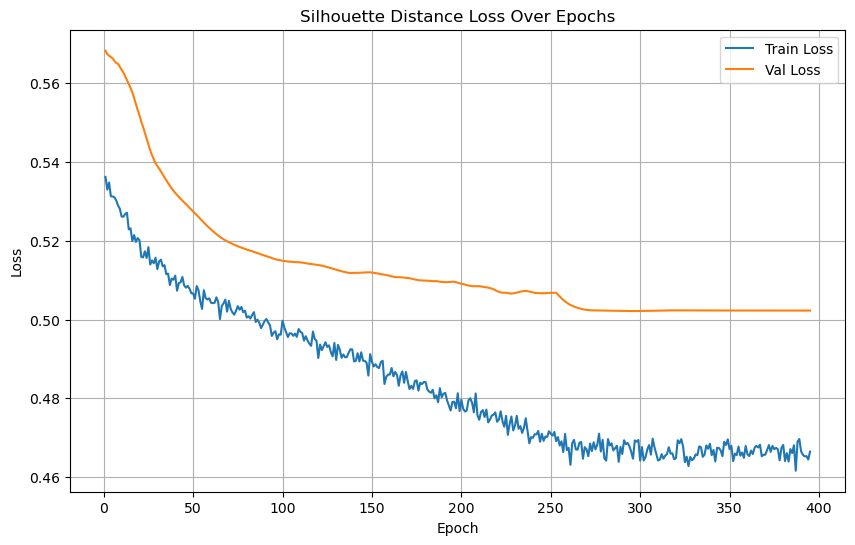

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/77], Loss: 0.3505


Test Batch [20/77], Loss: 0.0556
Test Batch [30/77], Loss: 0.1645
Test Batch [40/77], Loss: 0.5000
Test Batch [50/77], Loss: 0.2808


Test Batch [60/77], Loss: 0.3709
Test Batch [70/77], Loss: 0.5000

Test Loss: 0.3335


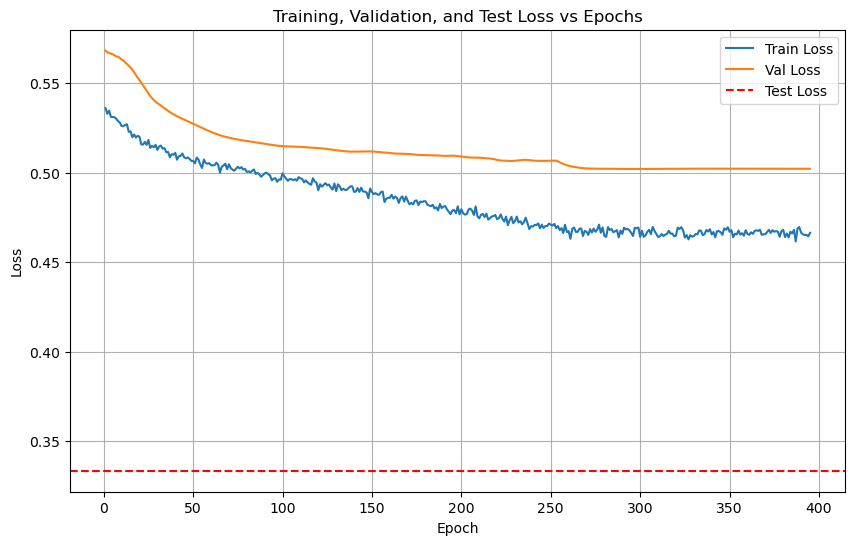

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/77 for test dataset.
  Processed batch 20/77 for test dataset.


  Processed batch 30/77 for test dataset.
  Processed batch 40/77 for test dataset.


  Processed batch 50/77 for test dataset.
  Processed batch 60/77 for test dataset.


  Processed batch 70/77 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.00      0.00      0.00         5
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         5
           4       0.33      0.60      0.43         5
           5       0.75      0.60      0.67         5
           6       0.21      0.60      0.32         5
           7       0.50      0.80      0.62         5
           8       0.80      0.80      0.80         5
           9       0.50      0.20      0.29         5
          10       1.00      0.60      0.75         5
          11       0.38      0.60      0.46         5
          12       1.00      0.80      0.89         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (260, 128)
Train labels shape: (260,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4886, 128)
Test labels shape: (4886,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5706  |  Val Loss: 2.5567
Validation loss improved from inf to 2.5567.
[Epoch 2/1000] Train Loss: 2.5628  |  Val Loss: 2.5533
Validation loss improved from 2.5567 to 2.5533.
[Epoch 3/1000] Train Loss: 2.5561  |  Val Loss: 2.5496
Validation loss improved from 2.5533 to 2.5496.
[Epoch 4/1000] Train Loss: 2.5504  |  Val Loss: 2.5461
Validation loss improved from 2.5496 to 2.5461.
[Epoch 5/1000] Train Loss: 2.5444  |  Val Loss: 2.5428
Validation loss improved from 2.5461 to 2.5428.
[Epoch 6/1000] Train Loss: 2.5394  |  Val Loss: 2.5396
Validation loss improved from 2.5428 to 2.5396.
[Epoch 7/1000] Train Loss: 2.5337  |  Val Loss: 2.5365
Validation loss improved from 2.5396 to 2.5365.
[Epoch 8/1000] Train Loss: 2.5286  |  Val Loss: 2.5334
Validation loss improved from 2.5365 to 2.5334.
[Epoch 9/1000] Train Loss: 2.5239  |  Val Loss: 2.5303
Validation loss improved from 2.5334 to 2.5303.
[Epoch 10/1000] Train Loss: 2.5191  |  Val Loss: 2.5266
Validation loss impr

[Epoch 11/1000] Train Loss: 2.5146  |  Val Loss: 2.5230
Validation loss improved from 2.5266 to 2.5230.
[Epoch 12/1000] Train Loss: 2.5100  |  Val Loss: 2.5192
Validation loss improved from 2.5230 to 2.5192.
[Epoch 13/1000] Train Loss: 2.5055  |  Val Loss: 2.5155
Validation loss improved from 2.5192 to 2.5155.
[Epoch 14/1000] Train Loss: 2.5011  |  Val Loss: 2.5119
Validation loss improved from 2.5155 to 2.5119.
[Epoch 15/1000] Train Loss: 2.4963  |  Val Loss: 2.5088
Validation loss improved from 2.5119 to 2.5088.
[Epoch 16/1000] Train Loss: 2.4922  |  Val Loss: 2.5057
Validation loss improved from 2.5088 to 2.5057.
[Epoch 17/1000] Train Loss: 2.4878  |  Val Loss: 2.5025
Validation loss improved from 2.5057 to 2.5025.


[Epoch 18/1000] Train Loss: 2.4833  |  Val Loss: 2.4993
Validation loss improved from 2.5025 to 2.4993.
[Epoch 19/1000] Train Loss: 2.4787  |  Val Loss: 2.4961
Validation loss improved from 2.4993 to 2.4961.
[Epoch 20/1000] Train Loss: 2.4741  |  Val Loss: 2.4934
Validation loss improved from 2.4961 to 2.4934.
[Epoch 21/1000] Train Loss: 2.4701  |  Val Loss: 2.4905
Validation loss improved from 2.4934 to 2.4905.
[Epoch 22/1000] Train Loss: 2.4657  |  Val Loss: 2.4875
Validation loss improved from 2.4905 to 2.4875.
[Epoch 23/1000] Train Loss: 2.4610  |  Val Loss: 2.4846
Validation loss improved from 2.4875 to 2.4846.
[Epoch 24/1000] Train Loss: 2.4568  |  Val Loss: 2.4813
Validation loss improved from 2.4846 to 2.4813.
[Epoch 25/1000] Train Loss: 2.4524  |  Val Loss: 2.4781
Validation loss improved from 2.4813 to 2.4781.
[Epoch 26/1000] Train Loss: 2.4476  |  Val Loss: 2.4750
Validation loss improved from 2.4781 to 2.4750.
[Epoch 27/1000] Train Loss: 2.4436  |  Val Loss: 2.4721
Validati

[Epoch 29/1000] Train Loss: 2.4355  |  Val Loss: 2.4664
Validation loss improved from 2.4692 to 2.4664.
[Epoch 30/1000] Train Loss: 2.4313  |  Val Loss: 2.4635
Validation loss improved from 2.4664 to 2.4635.
[Epoch 31/1000] Train Loss: 2.4273  |  Val Loss: 2.4608
Validation loss improved from 2.4635 to 2.4608.
[Epoch 32/1000] Train Loss: 2.4230  |  Val Loss: 2.4580
Validation loss improved from 2.4608 to 2.4580.
[Epoch 33/1000] Train Loss: 2.4186  |  Val Loss: 2.4552
Validation loss improved from 2.4580 to 2.4552.
[Epoch 34/1000] Train Loss: 2.4143  |  Val Loss: 2.4522
Validation loss improved from 2.4552 to 2.4522.
[Epoch 35/1000] Train Loss: 2.4099  |  Val Loss: 2.4491
Validation loss improved from 2.4522 to 2.4491.


[Epoch 36/1000] Train Loss: 2.4050  |  Val Loss: 2.4460
Validation loss improved from 2.4491 to 2.4460.
[Epoch 37/1000] Train Loss: 2.4001  |  Val Loss: 2.4431
Validation loss improved from 2.4460 to 2.4431.
[Epoch 38/1000] Train Loss: 2.3956  |  Val Loss: 2.4405
Validation loss improved from 2.4431 to 2.4405.
[Epoch 39/1000] Train Loss: 2.3913  |  Val Loss: 2.4380
Validation loss improved from 2.4405 to 2.4380.
[Epoch 40/1000] Train Loss: 2.3868  |  Val Loss: 2.4355
Validation loss improved from 2.4380 to 2.4355.
[Epoch 41/1000] Train Loss: 2.3824  |  Val Loss: 2.4328
Validation loss improved from 2.4355 to 2.4328.
[Epoch 42/1000] Train Loss: 2.3778  |  Val Loss: 2.4301
Validation loss improved from 2.4328 to 2.4301.
[Epoch 43/1000] Train Loss: 2.3729  |  Val Loss: 2.4276
Validation loss improved from 2.4301 to 2.4276.
[Epoch 44/1000] Train Loss: 2.3681  |  Val Loss: 2.4251
Validation loss improved from 2.4276 to 2.4251.
[Epoch 45/1000] Train Loss: 2.3629  |  Val Loss: 2.4225
Validati

[Epoch 52/1000] Train Loss: 2.3284  |  Val Loss: 2.4034
Validation loss improved from 2.4061 to 2.4034.
[Epoch 53/1000] Train Loss: 2.3229  |  Val Loss: 2.4005
Validation loss improved from 2.4034 to 2.4005.
[Epoch 54/1000] Train Loss: 2.3173  |  Val Loss: 2.3976
Validation loss improved from 2.4005 to 2.3976.


[Epoch 55/1000] Train Loss: 2.3121  |  Val Loss: 2.3944
Validation loss improved from 2.3976 to 2.3944.
[Epoch 56/1000] Train Loss: 2.3065  |  Val Loss: 2.3912
Validation loss improved from 2.3944 to 2.3912.
[Epoch 57/1000] Train Loss: 2.3005  |  Val Loss: 2.3882
Validation loss improved from 2.3912 to 2.3882.
[Epoch 58/1000] Train Loss: 2.2952  |  Val Loss: 2.3848
Validation loss improved from 2.3882 to 2.3848.
[Epoch 59/1000] Train Loss: 2.2894  |  Val Loss: 2.3814
Validation loss improved from 2.3848 to 2.3814.
[Epoch 60/1000] Train Loss: 2.2835  |  Val Loss: 2.3780
Validation loss improved from 2.3814 to 2.3780.
[Epoch 61/1000] Train Loss: 2.2779  |  Val Loss: 2.3747
Validation loss improved from 2.3780 to 2.3747.
[Epoch 62/1000] Train Loss: 2.2721  |  Val Loss: 2.3714
Validation loss improved from 2.3747 to 2.3714.
[Epoch 63/1000] Train Loss: 2.2671  |  Val Loss: 2.3682
Validation loss improved from 2.3714 to 2.3682.
[Epoch 64/1000] Train Loss: 2.2614  |  Val Loss: 2.3653
Validati

[Epoch 72/1000] Train Loss: 2.2123  |  Val Loss: 2.3361
Validation loss improved from 2.3398 to 2.3361.


[Epoch 73/1000] Train Loss: 2.2054  |  Val Loss: 2.3323
Validation loss improved from 2.3361 to 2.3323.
[Epoch 74/1000] Train Loss: 2.1993  |  Val Loss: 2.3285
Validation loss improved from 2.3323 to 2.3285.
[Epoch 75/1000] Train Loss: 2.1929  |  Val Loss: 2.3247
Validation loss improved from 2.3285 to 2.3247.
[Epoch 76/1000] Train Loss: 2.1861  |  Val Loss: 2.3208
Validation loss improved from 2.3247 to 2.3208.
[Epoch 77/1000] Train Loss: 2.1794  |  Val Loss: 2.3168
Validation loss improved from 2.3208 to 2.3168.
[Epoch 78/1000] Train Loss: 2.1724  |  Val Loss: 2.3123
Validation loss improved from 2.3168 to 2.3123.
[Epoch 79/1000] Train Loss: 2.1647  |  Val Loss: 2.3073
Validation loss improved from 2.3123 to 2.3073.
[Epoch 80/1000] Train Loss: 2.1576  |  Val Loss: 2.3028
Validation loss improved from 2.3073 to 2.3028.
[Epoch 81/1000] Train Loss: 2.1507  |  Val Loss: 2.2983
Validation loss improved from 2.3028 to 2.2983.
[Epoch 82/1000] Train Loss: 2.1437  |  Val Loss: 2.2940
Validati

[Epoch 92/1000] Train Loss: 2.0729  |  Val Loss: 2.2511
Validation loss improved from 2.2562 to 2.2511.
[Epoch 93/1000] Train Loss: 2.0647  |  Val Loss: 2.2455
Validation loss improved from 2.2511 to 2.2455.
[Epoch 94/1000] Train Loss: 2.0562  |  Val Loss: 2.2402
Validation loss improved from 2.2455 to 2.2402.
[Epoch 95/1000] Train Loss: 2.0483  |  Val Loss: 2.2346
Validation loss improved from 2.2402 to 2.2346.
[Epoch 96/1000] Train Loss: 2.0400  |  Val Loss: 2.2296
Validation loss improved from 2.2346 to 2.2296.
[Epoch 97/1000] Train Loss: 2.0316  |  Val Loss: 2.2256
Validation loss improved from 2.2296 to 2.2256.
[Epoch 98/1000] Train Loss: 2.0232  |  Val Loss: 2.2204
Validation loss improved from 2.2256 to 2.2204.
[Epoch 99/1000] Train Loss: 2.0151  |  Val Loss: 2.2152
Validation loss improved from 2.2204 to 2.2152.
[Epoch 100/1000] Train Loss: 2.0069  |  Val Loss: 2.2101
Validation loss improved from 2.2152 to 2.2101.
[Epoch 101/1000] Train Loss: 1.9990  |  Val Loss: 2.2052
Valida

[Epoch 110/1000] Train Loss: 1.9267  |  Val Loss: 2.1546
Validation loss improved from 2.1600 to 2.1546.
[Epoch 111/1000] Train Loss: 1.9188  |  Val Loss: 2.1493
Validation loss improved from 2.1546 to 2.1493.
[Epoch 112/1000] Train Loss: 1.9107  |  Val Loss: 2.1439
Validation loss improved from 2.1493 to 2.1439.
[Epoch 113/1000] Train Loss: 1.9028  |  Val Loss: 2.1381
Validation loss improved from 2.1439 to 2.1381.
[Epoch 114/1000] Train Loss: 1.8947  |  Val Loss: 2.1324
Validation loss improved from 2.1381 to 2.1324.
[Epoch 115/1000] Train Loss: 1.8871  |  Val Loss: 2.1270
Validation loss improved from 2.1324 to 2.1270.
[Epoch 116/1000] Train Loss: 1.8793  |  Val Loss: 2.1216
Validation loss improved from 2.1270 to 2.1216.
[Epoch 117/1000] Train Loss: 1.8712  |  Val Loss: 2.1166
Validation loss improved from 2.1216 to 2.1166.
[Epoch 118/1000] Train Loss: 1.8634  |  Val Loss: 2.1107
Validation loss improved from 2.1166 to 2.1107.
[Epoch 119/1000] Train Loss: 1.8549  |  Val Loss: 2.105

[Epoch 132/1000] Train Loss: 1.7506  |  Val Loss: 2.0313
Validation loss improved from 2.0368 to 2.0313.
[Epoch 133/1000] Train Loss: 1.7427  |  Val Loss: 2.0252
Validation loss improved from 2.0313 to 2.0252.
[Epoch 134/1000] Train Loss: 1.7350  |  Val Loss: 2.0193
Validation loss improved from 2.0252 to 2.0193.
[Epoch 135/1000] Train Loss: 1.7278  |  Val Loss: 2.0140
Validation loss improved from 2.0193 to 2.0140.
[Epoch 136/1000] Train Loss: 1.7197  |  Val Loss: 2.0078
Validation loss improved from 2.0140 to 2.0078.
[Epoch 137/1000] Train Loss: 1.7116  |  Val Loss: 2.0038
Validation loss improved from 2.0078 to 2.0038.
[Epoch 138/1000] Train Loss: 1.7040  |  Val Loss: 2.0023
Validation loss improved from 2.0038 to 2.0023.
[Epoch 139/1000] Train Loss: 1.6964  |  Val Loss: 1.9977
Validation loss improved from 2.0023 to 1.9977.
[Epoch 140/1000] Train Loss: 1.6890  |  Val Loss: 1.9903
Validation loss improved from 1.9977 to 1.9903.
[Epoch 141/1000] Train Loss: 1.6816  |  Val Loss: 1.984

[Epoch 154/1000] Train Loss: 1.5878  |  Val Loss: 1.9158
Validation loss improved from 1.9204 to 1.9158.
[Epoch 155/1000] Train Loss: 1.5803  |  Val Loss: 1.9144
Validation loss improved from 1.9158 to 1.9144.
[Epoch 156/1000] Train Loss: 1.5732  |  Val Loss: 1.9113
Validation loss improved from 1.9144 to 1.9113.
[Epoch 157/1000] Train Loss: 1.5661  |  Val Loss: 1.9064
Validation loss improved from 1.9113 to 1.9064.
[Epoch 158/1000] Train Loss: 1.5588  |  Val Loss: 1.9002
Validation loss improved from 1.9064 to 1.9002.
[Epoch 159/1000] Train Loss: 1.5514  |  Val Loss: 1.8936
Validation loss improved from 1.9002 to 1.8936.
[Epoch 160/1000] Train Loss: 1.5439  |  Val Loss: 1.8878
Validation loss improved from 1.8936 to 1.8878.
[Epoch 161/1000] Train Loss: 1.5368  |  Val Loss: 1.8811
Validation loss improved from 1.8878 to 1.8811.
[Epoch 162/1000] Train Loss: 1.5296  |  Val Loss: 1.8761
Validation loss improved from 1.8811 to 1.8761.
[Epoch 163/1000] Train Loss: 1.5226  |  Val Loss: 1.870

[Epoch 173/1000] Train Loss: 1.4564  |  Val Loss: 1.8319
Validation loss improved from 1.8326 to 1.8319.
[Epoch 174/1000] Train Loss: 1.4503  |  Val Loss: 1.8281
Validation loss improved from 1.8319 to 1.8281.
[Epoch 175/1000] Train Loss: 1.4442  |  Val Loss: 1.8221
Validation loss improved from 1.8281 to 1.8221.
[Epoch 176/1000] Train Loss: 1.4376  |  Val Loss: 1.8153
Validation loss improved from 1.8221 to 1.8153.
[Epoch 177/1000] Train Loss: 1.4305  |  Val Loss: 1.8099
Validation loss improved from 1.8153 to 1.8099.
[Epoch 178/1000] Train Loss: 1.4237  |  Val Loss: 1.8036
Validation loss improved from 1.8099 to 1.8036.
[Epoch 179/1000] Train Loss: 1.4173  |  Val Loss: 1.7978
Validation loss improved from 1.8036 to 1.7978.
[Epoch 180/1000] Train Loss: 1.4111  |  Val Loss: 1.7925
Validation loss improved from 1.7978 to 1.7925.
[Epoch 181/1000] Train Loss: 1.4049  |  Val Loss: 1.7868
Validation loss improved from 1.7925 to 1.7868.
[Epoch 182/1000] Train Loss: 1.3988  |  Val Loss: 1.778

[Epoch 190/1000] Train Loss: 1.3526  |  Val Loss: 1.7455
Validation loss improved from 1.7469 to 1.7455.
[Epoch 191/1000] Train Loss: 1.3468  |  Val Loss: 1.7429
Validation loss improved from 1.7455 to 1.7429.
[Epoch 192/1000] Train Loss: 1.3412  |  Val Loss: 1.7397
Validation loss improved from 1.7429 to 1.7397.
[Epoch 193/1000] Train Loss: 1.3355  |  Val Loss: 1.7374
Validation loss improved from 1.7397 to 1.7374.
[Epoch 194/1000] Train Loss: 1.3298  |  Val Loss: 1.7335
Validation loss improved from 1.7374 to 1.7335.
[Epoch 195/1000] Train Loss: 1.3238  |  Val Loss: 1.7296
Validation loss improved from 1.7335 to 1.7296.
[Epoch 196/1000] Train Loss: 1.3177  |  Val Loss: 1.7257
Validation loss improved from 1.7296 to 1.7257.
[Epoch 197/1000] Train Loss: 1.3119  |  Val Loss: 1.7217
Validation loss improved from 1.7257 to 1.7217.
[Epoch 198/1000] Train Loss: 1.3064  |  Val Loss: 1.7199
Validation loss improved from 1.7217 to 1.7199.
[Epoch 199/1000] Train Loss: 1.3005  |  Val Loss: 1.716

[Epoch 210/1000] Train Loss: 1.2430  |  Val Loss: 1.6847
Validation loss improved from 1.6881 to 1.6847.
[Epoch 211/1000] Train Loss: 1.2380  |  Val Loss: 1.6812
Validation loss improved from 1.6847 to 1.6812.
[Epoch 212/1000] Train Loss: 1.2329  |  Val Loss: 1.6780
Validation loss improved from 1.6812 to 1.6780.
[Epoch 213/1000] Train Loss: 1.2278  |  Val Loss: 1.6741
Validation loss improved from 1.6780 to 1.6741.
[Epoch 214/1000] Train Loss: 1.2229  |  Val Loss: 1.6707
Validation loss improved from 1.6741 to 1.6707.
[Epoch 215/1000] Train Loss: 1.2180  |  Val Loss: 1.6686
Validation loss improved from 1.6707 to 1.6686.
[Epoch 216/1000] Train Loss: 1.2130  |  Val Loss: 1.6666
Validation loss improved from 1.6686 to 1.6666.
[Epoch 217/1000] Train Loss: 1.2086  |  Val Loss: 1.6641
Validation loss improved from 1.6666 to 1.6641.
[Epoch 218/1000] Train Loss: 1.2035  |  Val Loss: 1.6601
Validation loss improved from 1.6641 to 1.6601.
[Epoch 219/1000] Train Loss: 1.1991  |  Val Loss: 1.654

[Epoch 230/1000] Train Loss: 1.1486  |  Val Loss: 1.6261
Validation loss improved from 1.6286 to 1.6261.
[Epoch 231/1000] Train Loss: 1.1443  |  Val Loss: 1.6232
Validation loss improved from 1.6261 to 1.6232.
[Epoch 232/1000] Train Loss: 1.1402  |  Val Loss: 1.6197
Validation loss improved from 1.6232 to 1.6197.
[Epoch 233/1000] Train Loss: 1.1354  |  Val Loss: 1.6154
Validation loss improved from 1.6197 to 1.6154.
[Epoch 234/1000] Train Loss: 1.1306  |  Val Loss: 1.6141
Validation loss improved from 1.6154 to 1.6141.
[Epoch 235/1000] Train Loss: 1.1268  |  Val Loss: 1.6132
Validation loss improved from 1.6141 to 1.6132.
[Epoch 236/1000] Train Loss: 1.1232  |  Val Loss: 1.6125
Validation loss improved from 1.6132 to 1.6125.
[Epoch 237/1000] Train Loss: 1.1195  |  Val Loss: 1.6113
Validation loss improved from 1.6125 to 1.6113.
[Epoch 238/1000] Train Loss: 1.1155  |  Val Loss: 1.6106
Validation loss improved from 1.6113 to 1.6106.
[Epoch 239/1000] Train Loss: 1.1108  |  Val Loss: 1.606

[Epoch 253/1000] Train Loss: 1.0566  |  Val Loss: 1.5759
Validation loss improved from 1.5793 to 1.5759.
[Epoch 254/1000] Train Loss: 1.0541  |  Val Loss: 1.5738
Validation loss improved from 1.5759 to 1.5738.
[Epoch 255/1000] Train Loss: 1.0504  |  Val Loss: 1.5693
Validation loss improved from 1.5738 to 1.5693.
[Epoch 256/1000] Train Loss: 1.0467  |  Val Loss: 1.5640
Validation loss improved from 1.5693 to 1.5640.
[Epoch 257/1000] Train Loss: 1.0425  |  Val Loss: 1.5599
Validation loss improved from 1.5640 to 1.5599.
[Epoch 258/1000] Train Loss: 1.0393  |  Val Loss: 1.5586
Validation loss improved from 1.5599 to 1.5586.
[Epoch 259/1000] Train Loss: 1.0365  |  Val Loss: 1.5594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 260/1000] Train Loss: 1.0332  |  Val Loss: 1.5605
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 261/1000] Train Loss: 1.0294  |  Val Loss: 1.5624
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 262/1000] Train Loss: 1.0258  

[Epoch 272/1000] Train Loss: 0.9972  |  Val Loss: 1.5569
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 273/1000] Train Loss: 0.9936  |  Val Loss: 1.5552
Validation loss improved from 1.5562 to 1.5552.
[Epoch 274/1000] Train Loss: 0.9893  |  Val Loss: 1.5589
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 275/1000] Train Loss: 0.9856  |  Val Loss: 1.5597
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 276/1000] Train Loss: 0.9821  |  Val Loss: 1.5574
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 277/1000] Train Loss: 0.9790  |  Val Loss: 1.5536
Validation loss improved from 1.5552 to 1.5536.
[Epoch 278/1000] Train Loss: 0.9756  |  Val Loss: 1.5504
Validation loss improved from 1.5536 to 1.5504.
[Epoch 279/1000] Train Loss: 0.9725  |  Val Loss: 1.5465
Validation loss improved from 1.5504 to 1.5465.
[Epoch 280/1000] Train Loss: 0.9701  |  Val Loss: 1.5412
Validation loss improved from 1.5465 to 1.5412.
[Epoch 281/1000] Train Loss: 0.

[Epoch 289/1000] Train Loss: 0.9466  |  Val Loss: 1.5424
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 290/1000] Train Loss: 0.9440  |  Val Loss: 1.5393
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 291/1000] Train Loss: 0.9416  |  Val Loss: 1.5366
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 292/1000] Train Loss: 0.9390  |  Val Loss: 1.5385
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 293/1000] Train Loss: 0.9362  |  Val Loss: 1.5382
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 294/1000] Train Loss: 0.9335  |  Val Loss: 1.5407
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 295/1000] Train Loss: 0.9309  |  Val Loss: 1.5464
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 296/1000] Train Loss: 0.9288  |  Val Loss: 1.5484
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 297/1000] Train Loss: 0.9262  |  Val Loss: 1.5470
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 312/1000] Train Loss: 0.8916  |  Val Loss: 1.5213
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 313/1000] Train Loss: 0.8892  |  Val Loss: 1.5221
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 314/1000] Train Loss: 0.8872  |  Val Loss: 1.5226
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 315/1000] Train Loss: 0.8850  |  Val Loss: 1.5249
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 316/1000] Train Loss: 0.8833  |  Val Loss: 1.5276
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 317/1000] Train Loss: 0.8810  |  Val Loss: 1.5305
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 318/1000] Train Loss: 0.8788  |  Val Loss: 1.5304
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 319/1000] Train Loss: 0.8764  |  Val Loss: 1.5292
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 320/1000] Train Loss: 0.8742  |  Val Loss: 1.5289
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 334/1000] Train Loss: 0.8495  |  Val Loss: 1.5365
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 335/1000] Train Loss: 0.8479  |  Val Loss: 1.5394
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 336/1000] Train Loss: 0.8458  |  Val Loss: 1.5392
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 337/1000] Train Loss: 0.8444  |  Val Loss: 1.5334
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 338/1000] Train Loss: 0.8427  |  Val Loss: 1.5268
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 339/1000] Train Loss: 0.8415  |  Val Loss: 1.5171
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 340/1000] Train Loss: 0.8393  |  Val Loss: 1.5116
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 341/1000] Train Loss: 0.8372  |  Val Loss: 1.5089
Validation loss improved from 1.5110 to 1.5089.
[Epoch 342/1000] Train Loss: 0.8352  |  Val Loss: 1.5087
Validation loss improved from 1.5089 to 1.5087.
[Epoch

[Epoch 355/1000] Train Loss: 0.8140  |  Val Loss: 1.5281
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 356/1000] Train Loss: 0.8122  |  Val Loss: 1.5210
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 357/1000] Train Loss: 0.8118  |  Val Loss: 1.5116
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 358/1000] Train Loss: 0.8097  |  Val Loss: 1.5072
Validation loss improved from 1.5087 to 1.5072.
[Epoch 359/1000] Train Loss: 0.8085  |  Val Loss: 1.5033
Validation loss improved from 1.5072 to 1.5033.
[Epoch 360/1000] Train Loss: 0.8075  |  Val Loss: 1.5027
Validation loss improved from 1.5033 to 1.5027.
[Epoch 361/1000] Train Loss: 0.8057  |  Val Loss: 1.5051
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 362/1000] Train Loss: 0.8045  |  Val Loss: 1.5110
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 363/1000] Train Loss: 0.8028  |  Val Loss: 1.5251
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 364/1000]

[Epoch 376/1000] Train Loss: 0.7846  |  Val Loss: 1.5152
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 377/1000] Train Loss: 0.7836  |  Val Loss: 1.5169
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 378/1000] Train Loss: 0.7827  |  Val Loss: 1.5201
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 379/1000] Train Loss: 0.7818  |  Val Loss: 1.5260
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 380/1000] Train Loss: 0.7818  |  Val Loss: 1.5311
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 381/1000] Train Loss: 0.7810  |  Val Loss: 1.5426
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 382/1000] Train Loss: 0.7798  |  Val Loss: 1.5451
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 383/1000] Train Loss: 0.7781  |  Val Loss: 1.5415
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 384/1000] Train Loss: 0.7762  |  Val Loss: 1.5338
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.7628  |  Val Loss: 1.5204
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 397/1000] Train Loss: 0.7613  |  Val Loss: 1.5212
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 398/1000] Train Loss: 0.7600  |  Val Loss: 1.5210
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 399/1000] Train Loss: 0.7588  |  Val Loss: 1.5223
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 400/1000] Train Loss: 0.7579  |  Val Loss: 1.5223
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 401/1000] Train Loss: 0.7564  |  Val Loss: 1.5226
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 402/1000] Train Loss: 0.7563  |  Val Loss: 1.5200
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 403/1000] Train Loss: 0.7562  |  Val Loss: 1.5182
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 404/1000] Train Loss: 0.7561  |  Val Loss: 1.5237
!! Validation loss did NOT improve !! Patience:

[Epoch 415/1000] Train Loss: 0.7435  |  Val Loss: 1.5278
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 416/1000] Train Loss: 0.7425  |  Val Loss: 1.5326
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 417/1000] Train Loss: 0.7416  |  Val Loss: 1.5322
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 418/1000] Train Loss: 0.7407  |  Val Loss: 1.5313
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 419/1000] Train Loss: 0.7396  |  Val Loss: 1.5288
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 420/1000] Train Loss: 0.7386  |  Val Loss: 1.5207
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 421/1000] Train Loss: 0.7382  |  Val Loss: 1.5144
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 422/1000] Train Loss: 0.7376  |  Val Loss: 1.5140
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 423/1000] Train Loss: 0.7369  |  Val Loss: 1.5150
!! Validation loss did NOT improve !! Patience:

[Epoch 437/1000] Train Loss: 0.7257  |  Val Loss: 1.5275
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 438/1000] Train Loss: 0.7237  |  Val Loss: 1.5458
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 439/1000] Train Loss: 0.7223  |  Val Loss: 1.5567
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 440/1000] Train Loss: 0.7219  |  Val Loss: 1.5641
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 441/1000] Train Loss: 0.7207  |  Val Loss: 1.5622
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 442/1000] Train Loss: 0.7205  |  Val Loss: 1.5600
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 443/1000] Train Loss: 0.7195  |  Val Loss: 1.5586
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 444/1000] Train Loss: 0.7191  |  Val Loss: 1.5552
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 445/1000] Train Loss: 0.7183  |  Val Loss: 1.5512
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 457/1000] Train Loss: 0.7102  |  Val Loss: 1.5606
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 458/1000] Train Loss: 0.7080  |  Val Loss: 1.5542
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 459/1000] Train Loss: 0.7066  |  Val Loss: 1.5501
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 460/1000] Train Loss: 0.7062  |  Val Loss: 1.5457
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 461/1000] Train Loss: 0.7054  |  Val Loss: 1.5435
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 462/1000] Train Loss: 0.7042  |  Val Loss: 1.5412
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 463/1000] Train Loss: 0.7030  |  Val Loss: 1.5426
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 464/1000] Train Loss: 0.7018  |  Val Loss: 1.5455
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 465/1000] Train Loss: 0.7012  |  Val Loss: 1.5493
!! Validation loss did NOT improve !! Patience:

[Epoch 478/1000] Train Loss: 0.6925  |  Val Loss: 1.5687
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 479/1000] Train Loss: 0.6919  |  Val Loss: 1.5639
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 480/1000] Train Loss: 0.6909  |  Val Loss: 1.5582
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 481/1000] Train Loss: 0.6907  |  Val Loss: 1.5570
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 482/1000] Train Loss: 0.6905  |  Val Loss: 1.5570
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 483/1000] Train Loss: 0.6895  |  Val Loss: 1.5584
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 484/1000] Train Loss: 0.6889  |  Val Loss: 1.5594
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 485/1000] Train Loss: 0.6877  |  Val Loss: 1.5603
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 486/1000] Train Loss: 0.6867  |  Val Loss: 1.5586
!! Validation loss did NOT improve !! Patience:

[Epoch 498/1000] Train Loss: 0.6783  |  Val Loss: 1.5839
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 499/1000] Train Loss: 0.6773  |  Val Loss: 1.5867
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 500/1000] Train Loss: 0.6771  |  Val Loss: 1.5829
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 501/1000] Train Loss: 0.6764  |  Val Loss: 1.5772
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 502/1000] Train Loss: 0.6757  |  Val Loss: 1.5724
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 503/1000] Train Loss: 0.6755  |  Val Loss: 1.5619
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 504/1000] Train Loss: 0.6744  |  Val Loss: 1.5587
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 505/1000] Train Loss: 0.6736  |  Val Loss: 1.5591
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 506/1000] Train Loss: 0.6739  |  Val Loss: 1.5610
!! Validation loss did NOT improve !! Patience:

[Epoch 518/1000] Train Loss: 0.6658  |  Val Loss: 1.5667
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 519/1000] Train Loss: 0.6654  |  Val Loss: 1.5667
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 520/1000] Train Loss: 0.6656  |  Val Loss: 1.5660
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 521/1000] Train Loss: 0.6647  |  Val Loss: 1.5678
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 522/1000] Train Loss: 0.6636  |  Val Loss: 1.5660
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 523/1000] Train Loss: 0.6637  |  Val Loss: 1.5683
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 524/1000] Train Loss: 0.6636  |  Val Loss: 1.5758
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 525/1000] Train Loss: 0.6626  |  Val Loss: 1.5891
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 526/1000] Train Loss: 0.6620  |  Val Loss: 1.6154
!! Validation loss did NOT improve !! Patience:

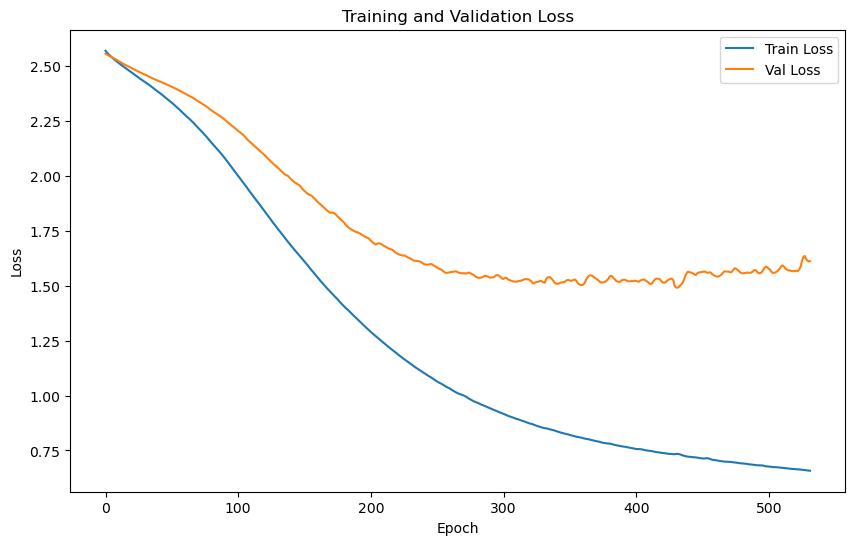

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.3951 | Test Accuracy: 57.29%


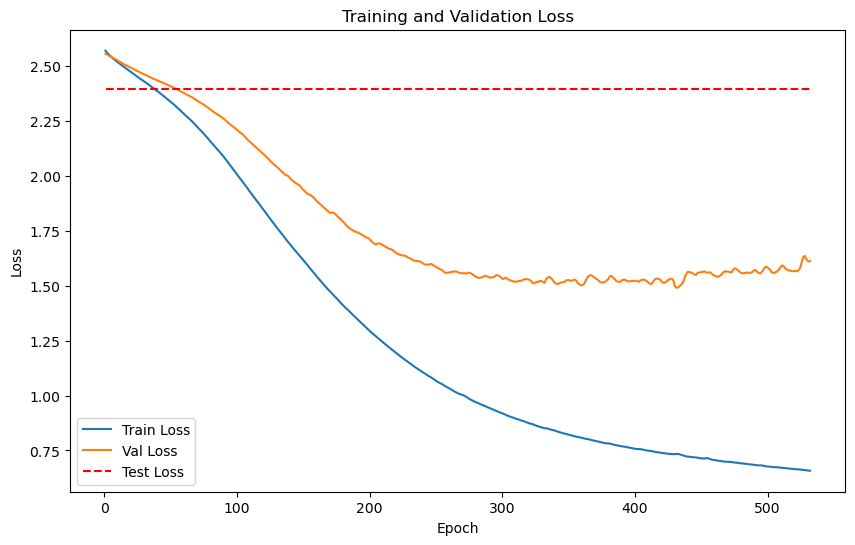

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


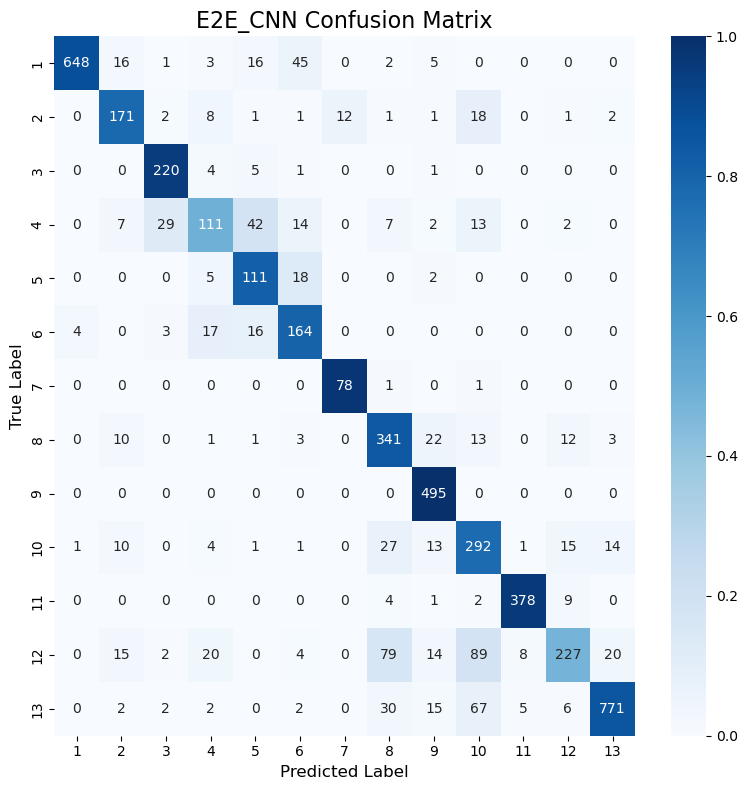

Classification Accuracy: 82.01%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


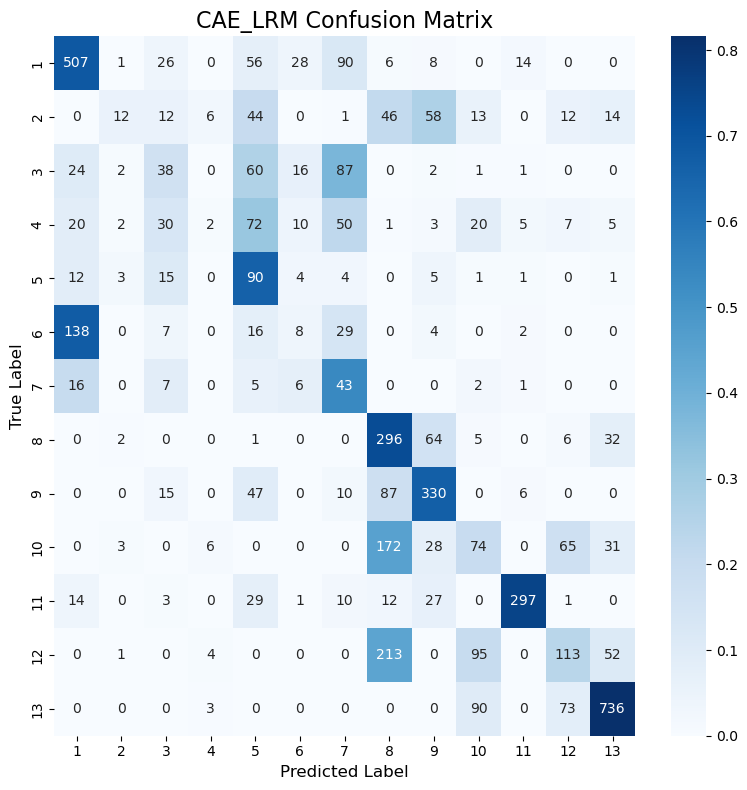

Classification Accuracy: 52.11%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


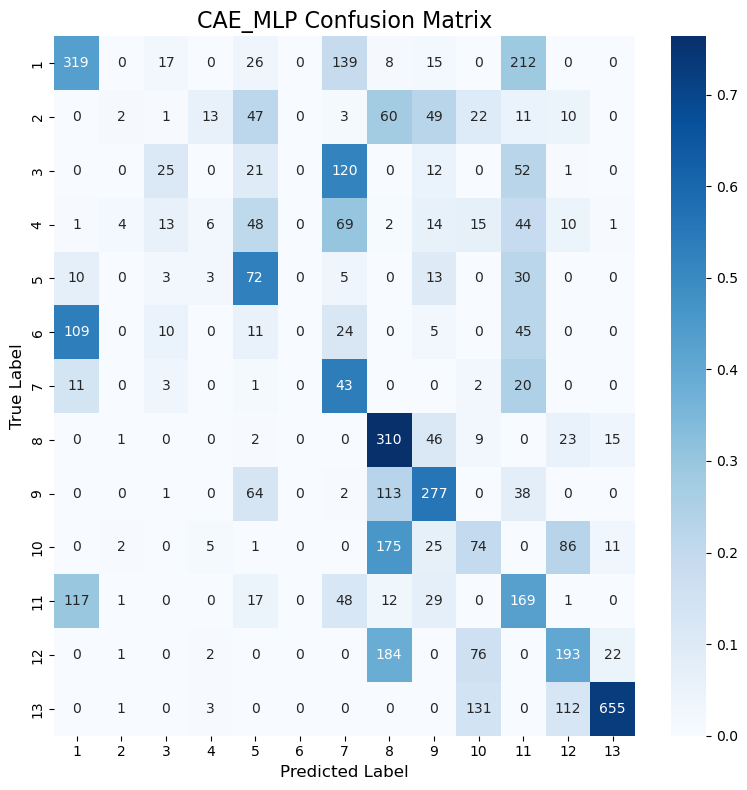

Classification Accuracy: 43.90%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


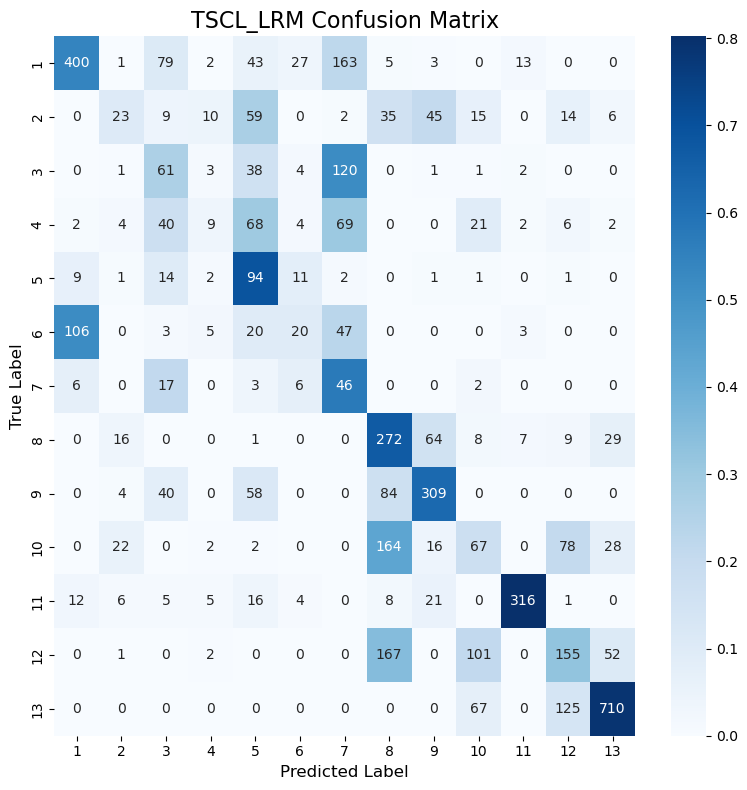

Classification Accuracy: 50.80%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


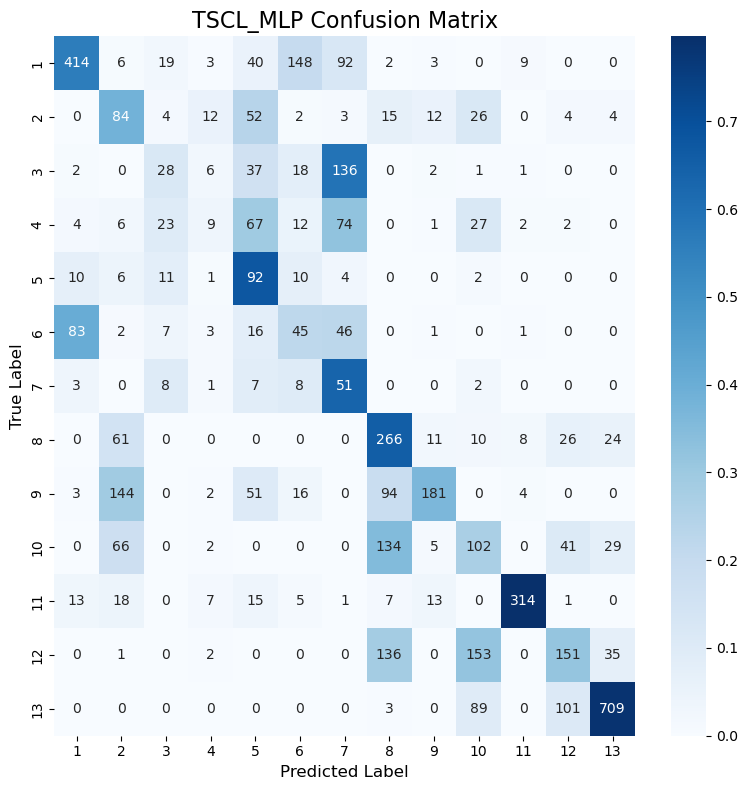

Classification Accuracy: 50.06%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


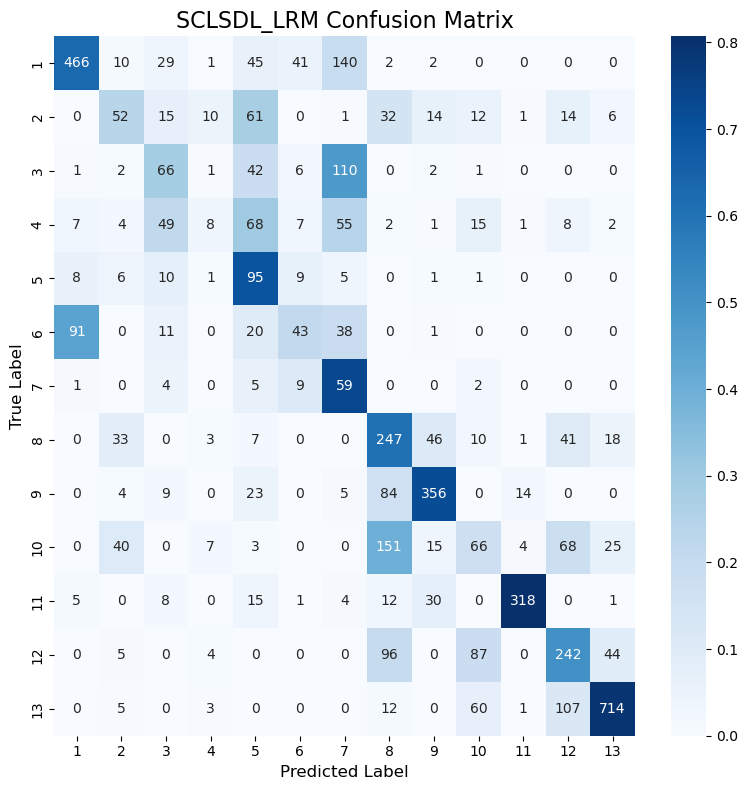

Classification Accuracy: 55.91%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


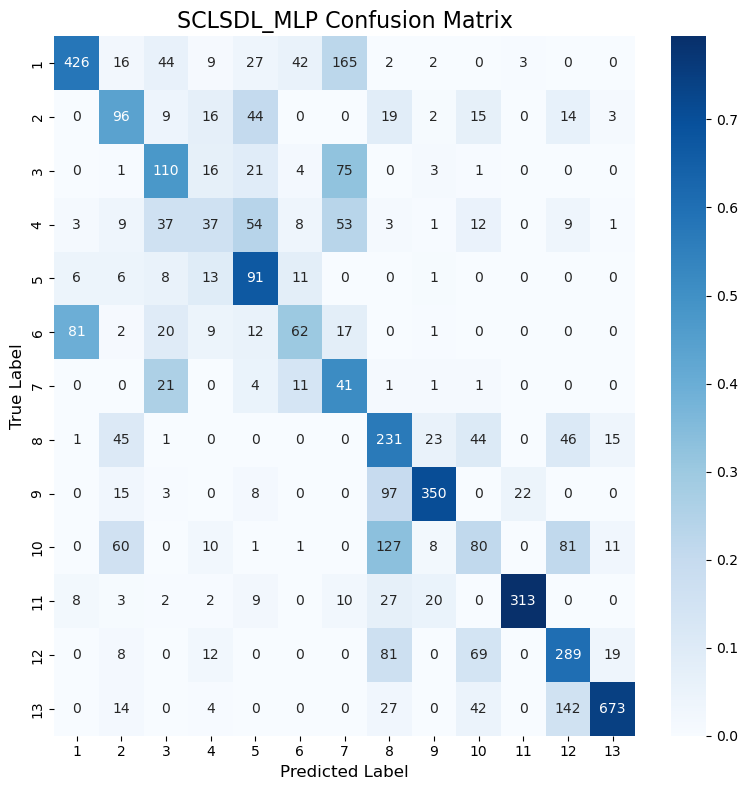

Classification Accuracy: 57.29%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          82.01
1    LRM (CAE)          52.11
2    MLP (CAE)          43.90
3     TSCL LRM          50.80
4     TSCL MLP          50.06
5  SCL_SDL LRM          55.91
6  SCL_SDL MLP          57.29

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          82.01
6  SCL_SDL MLP          57.29
5  SCL_SDL LRM          55.91
1    LRM (CAE)          52.11
3     TSCL LRM          50.80
4     TSCL MLP          50.06
2    MLP (CAE)          43.90
